In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# 1. 데이터셋 로드
# 파일 이름은 '최종.xlsx'이며, Excel 파일이므로 pd.read_excel을 사용합니다.
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
# '기준년월'을 datetime으로 변환하고 '년', '월' 파생 컬럼을 추출합니다.
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월']) # 원본 날짜 컬럼을 제거합니다.

# 타겟 변수와 피처를 정의합니다.
target_col = '분양률'
X = df.drop(columns=[target_col])
y = df[target_col]

# '아파트' 컬럼을 임베딩을 위해 별도로 분리합니다.
apartment_names_raw = X['아파트']
X_other = X.drop(columns=['아파트'])

# X_other에서 범주형 및 수치형 피처를 식별합니다.
categorical_features = ['지역', '준공여부', '건설사']
numerical_features = [col for col in X_other.columns if col not in categorical_features]

# 수치형 피처의 결측값을 중앙값으로 간단하게 대체합니다.
for col in numerical_features:
    if X_other[col].isnull().any():
        X_other[col] = X_other[col].fillna(X_other[col].median())

# 3. 학습/테스트 데이터 분할
# '아파트' 컬럼이 일관되게 분할되도록 데이터를 나눕니다.
X_train_other, X_test_other, y_train, y_test, apartment_train_raw, apartment_test_raw = train_test_split(
    X_other, y, apartment_names_raw, test_size=0.2, random_state=42
)

# 4. '아파트' 외 피처 (수치형 및 원-핫 인코딩된 피처) 전처리
# ColumnTransformer를 사용하여 전처리기를 생성합니다.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # 수치형 피처 스케일링
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # 범주형 피처 원-핫 인코딩
    ],
    remainder='passthrough'
)

# 학습 데이터에 전처리기를 fit하고 변환합니다.
X_train_processed = preprocessor.fit_transform(X_train_other)
# 테스트 데이터를 변환합니다 (학습 데이터에 fit된 전처리기를 사용).
X_test_processed = preprocessor.transform(X_test_other)

# 'other_features_input' 레이어의 입력 차원을 결정합니다.
other_features_dim = X_train_processed.shape[1]

# 5. '아파트' 임베딩을 위한 어휘집 정의
# 데이터 누수를 방지하기 위해 학습 데이터셋의 고유한 아파트 이름으로 StringLookup 어휘집을 구성하는 것이 중요합니다.
unique_apartment_names_train = apartment_train_raw.unique().tolist()

# '아파트' 임베딩 차원을 정의합니다.
vocab_size_apartment = len(unique_apartment_names_train) + 1
embedding_dim = min(50, (vocab_size_apartment + 1) // 2)
if embedding_dim == 0: embedding_dim = 1

# 6. 딥러닝 모델 구축
# 수치형 및 원-핫 인코딩된 피처를 위한 입력 레이어
other_features_input = Input(shape=(other_features_dim,), name='other_features_input')

# 아파트 이름 (문자열)을 위한 입력 레이어: 각 샘플이 단일 문자열이므로 shape=(1,)
apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')

# 아파트 임베딩 브랜치
string_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
embedding_layer = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim)

x_apartment = string_lookup_layer(apartment_input)
x_apartment = embedding_layer(x_apartment)
x_apartment = Flatten()(x_apartment)

# 모든 피처 (전처리된 'other' 피처와 아파트 임베딩)를 연결합니다.
concatenated_features = Concatenate()([other_features_input, x_apartment])

# 회귀를 위한 딥러닝 모델 레이어
x = Dense(128, activation='relu')(concatenated_features)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x) # 회귀 출력 레이어

# 여러 입력을 가진 모델을 생성합니다.
model = Model(inputs=[other_features_input, apartment_input], outputs=output)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 7. 모델 학습
print("모델 학습 중...")
# apartment_train_raw를 (샘플_수, 1) 형태로 reshape한 후 tf.constant로 변환
history = model.fit(
    x=[X_train_processed, tf.constant(apartment_train_raw.values.reshape(-1, 1), dtype=tf.string)],
    y=y_train.values,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
print("모델 학습 완료.")

# 8. 테스트 세트로 모델 평가
print("\n테스트 세트로 모델 평가 중...")
# apartment_test_raw도 (샘플_수, 1) 형태로 reshape한 후 tf.constant로 변환
loss, mae = model.evaluate(x=[X_test_processed, tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string)], y=y_test.values, verbose=0)
print(f"테스트 손실 (MSE): {loss:.4f}")
print(f"테스트 MAE: {mae:.4f}")

# 9. R2 스코어 계산 및 출력
y_pred = model.predict(x=[X_test_processed, tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string)])
r2 = r2_score(y_test.values, y_pred)
print(f"테스트 R2 스코어: {r2:.4f}")

print("\n모델 요약:")
model.summary()

모델 학습 중...
Epoch 1/50


2025-07-22 09:33:32.158850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-22 09:33:32.166543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2825 - mae: 0.4081 - val_loss: 0.0557 - val_mae: 0.1651
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0496 - mae: 0.1647 - val_loss: 0.0448 - val_mae: 0.1348
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0292 - mae: 0.1134 - val_loss: 0.0429 - val_mae: 0.1355
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0240 - mae: 0.1010 - val_loss: 0.0453 - val_mae: 0.1327
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0222 - mae: 0.0954 - val_loss: 0.0364 - val_mae: 0.1244
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0200 - mae: 0.0914 - val_loss: 0.0353 - val_mae: 0.1224
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0173 - mae: 0.0806 - val_loss: 0.0390 - val_mae: 0.1241
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0149 - mae: 0.0719 - val_loss: 0.0461 - val_mae: 0.1296
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0173 - mae: 0.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ apartment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_2     │ (None, 1)         │          0 │ apartment_input[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │     18,350 │ string_lookup_2[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features_inp… │ (None, 309)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 359)       │          0 │ other_features_i… │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     46,080 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 218,255 (852.56 KB)

 Trainable params: 72,751 (284.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 145,504 (568.38 KB)

모델 학습 중...
Epoch 1/100


2025-07-22 09:35:58.636660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1966 - mae: 0.3512 - val_loss: 0.0711 - val_mae: 0.2210 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0865 - mae: 0.2258 - val_loss: 0.0826 - val_mae: 0.2545 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0677 - mae: 0.2033 - val_loss: 0.0637 - val_mae: 0.1919 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0601 - mae: 0.1887 - val_loss: 0.0528 - val_mae: 0.1777 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0466 - mae: 0.1617 - val_loss: 0.0664 - val_mae: 0.2217 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0439 - mae: 0.1610 - val_loss: 0.0501 - val_mae: 0.1810 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0376 - mae: 0.1470 - val_loss: 0.0552 - val_mae: 0.1954 - learning_rate: 0.0010
Epoch 8/100
50/50 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ apartment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_3     │ (None, 1)         │          0 │ apartment_input[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │     18,350 │ string_lookup_3[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features_inp… │ (None, 309)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 359)       │          0 │ other_features_i… │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     92,160 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         65 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 455,183 (1.74 MB)

 Trainable params: 151,727 (592.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 303,456 (1.16 MB)


성능 시각화:


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure

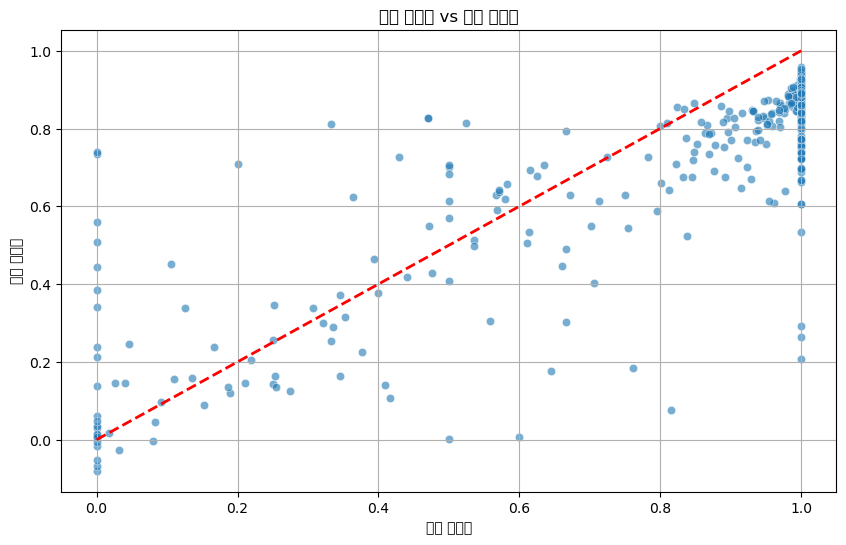

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(by

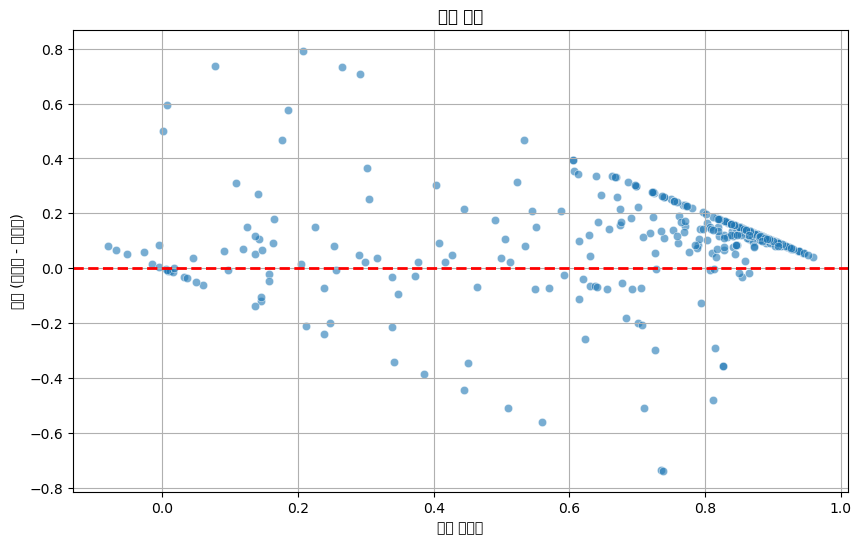

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA})

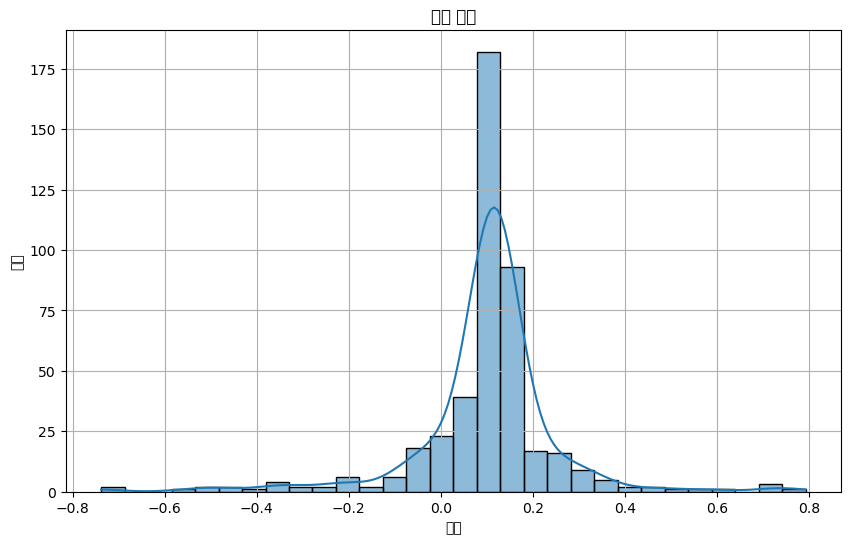

/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/ipykernel_14218/4274643702.py:204: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/ipykernel_14218/4274643702.py:204: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/ipykernel_14218/4274643702.py:204: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/ipykernel_14218/4274643702.py:204: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/ipykernel_14218/4274643702.py:204: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/

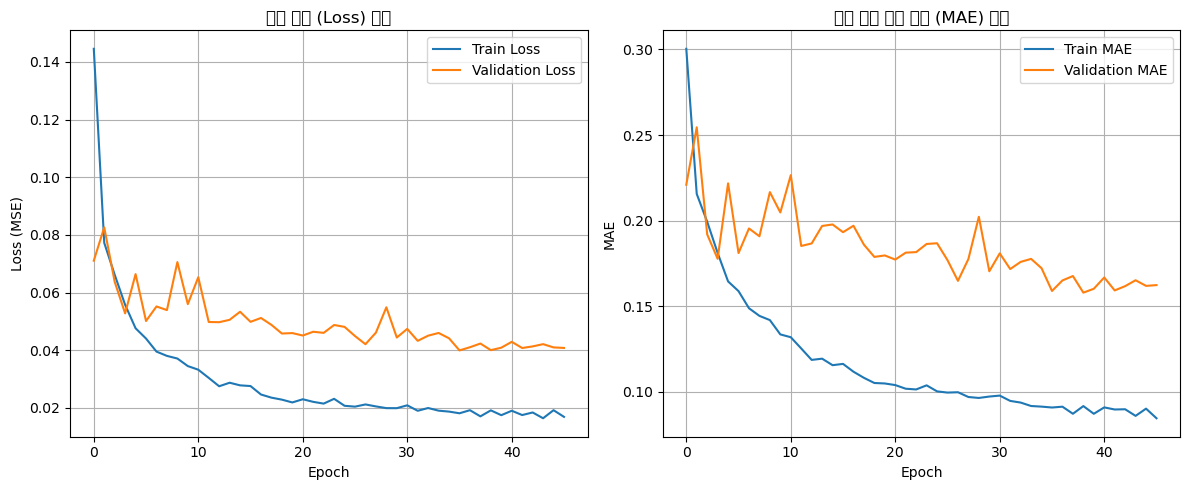

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout # Dropout 추가
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # 콜백 추가
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터셋 로드
# 파일 이름은 '최종.xlsx'이며, Excel 파일이므로 pd.read_excel을 사용합니다.
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
# '기준년월'을 datetime으로 변환하고 '년', '월' 파생 컬럼을 추출합니다.
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월']) # 원본 날짜 컬럼을 제거합니다.

# 타겟 변수와 피처를 정의합니다.
target_col = '분양률'
X = df.drop(columns=[target_col])
y = df[target_col]

# '아파트' 컬럼을 임베딩을 위해 별도로 분리합니다.
apartment_names_raw = X['아파트']
X_other = X.drop(columns=['아파트'])

# X_other에서 범주형 및 수치형 피처를 식별합니다.
categorical_features = ['지역', '준공여부', '건설사']
numerical_features = [col for col in X_other.columns if col not in categorical_features]

# 수치형 피처의 결측값을 중앙값으로 간단하게 대체합니다.
for col in numerical_features:
    if X_other[col].isnull().any():
        X_other[col] = X_other[col].fillna(X_other[col].median())

# 3. 학습/테스트 데이터 분할
# '아파트' 컬럼이 일관되게 분할되도록 데이터를 나눕니다.
X_train_other, X_test_other, y_train, y_test, apartment_train_raw, apartment_test_raw = train_test_split(
    X_other, y, apartment_names_raw, test_size=0.2, random_state=42
)

# 4. '아파트' 외 피처 (수치형 및 원-핫 인코딩된 피처) 전처리
# ColumnTransformer를 사용하여 전처리기를 생성합니다.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # 수치형 피처 스케일링
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # 범주형 피처 원-핫 인코딩
    ],
    remainder='passthrough'
)

# 학습 데이터에 전처리기를 fit하고 변환합니다.
X_train_processed = preprocessor.fit_transform(X_train_other)
# 테스트 데이터를 변환합니다 (학습 데이터에 fit된 전처리기를 사용).
X_test_processed = preprocessor.transform(X_test_other)

# 'other_features_input' 레이어의 입력 차원을 결정합니다.
other_features_dim = X_train_processed.shape[1]

# 5. '아파트' 임베딩을 위한 어휘집 정의
# 데이터 누수를 방지하기 위해 학습 데이터셋의 고유한 아파트 이름으로 StringLookup 어휘집을 구성하는 것이 중요합니다.
unique_apartment_names_train = apartment_train_raw.unique().tolist()

# '아파트' 임베딩 차원을 정의합니다.
vocab_size_apartment = len(unique_apartment_names_train) + 1
embedding_dim = min(50, (vocab_size_apartment + 1) // 2)
if embedding_dim == 0: embedding_dim = 1

# 6. 딥러닝 모델 구축 (성능 최적화 기법 적용)
# 수치형 및 원-핫 인코딩된 피처를 위한 입력 레이어
other_features_input = Input(shape=(other_features_dim,), name='other_features_input')

# 아파트 이름 (문자열)을 위한 입력 레이어: 각 샘플이 단일 문자열이므로 shape=(1,)
apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')

# 아파트 임베딩 브랜치
string_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
embedding_layer = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim)

x_apartment = string_lookup_layer(apartment_input)
x_apartment = embedding_layer(x_apartment)
x_apartment = Flatten()(x_apartment)

# 모든 피처 (전처리된 'other' 피처와 아파트 임베딩)를 연결합니다.
concatenated_features = Concatenate()([other_features_input, x_apartment])

# 회귀를 위한 딥러닝 모델 레이어 (뉴런 수 증가 및 Dropout 추가)
x = Dense(256, activation='relu')(concatenated_features) # 뉴런 수 증가
x = Dropout(0.3)(x) # Dropout 추가 (30% 드롭아웃)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x) # Dropout 추가 (30% 드롭아웃)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x) # 회귀 출력 레이어

# 여러 입력을 가진 모델을 생성합니다.
model = Model(inputs=[other_features_input, apartment_input], outputs=output)

# 7. 모델 컴파일
# Early Stopping 콜백 정의: 검증 손실이 10 에포크 동안 개선되지 않으면 학습 중단, 최적 가중치 복원
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ReduceLROnPlateau 콜백 정의: 검증 손실이 5 에포크 동안 개선되지 않으면 학습률 0.5배 감소, 최소 학습률 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 8. 모델 학습
print("모델 학습 중...")
# apartment_train_raw를 (샘플_수, 1) 형태로 reshape한 후 tf.constant로 변환
history = model.fit(
    x=[X_train_processed, tf.constant(apartment_train_raw.values.reshape(-1, 1), dtype=tf.string)],
    y=y_train.values,
    epochs=100, # EarlyStopping이 있으므로 충분히 큰 에포크 수 설정
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr], # 콜백 추가
    verbose=1
)
print("모델 학습 완료.")

# 9. 테스트 세트로 모델 평가
print("\n테스트 세트로 모델 평가 중...")
# apartment_test_raw도 (샘플_수, 1) 형태로 reshape한 후 tf.constant로 변환
loss, mae = model.evaluate(x=[X_test_processed, tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string)], y=y_test.values, verbose=0)
print(f"테스트 손실 (MSE): {loss:.4f}")
print(f"테스트 MAE: {mae:.4f}")

# 10. R2 스코어 계산 및 출력
y_pred = model.predict(x=[X_test_processed, tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string)]).flatten() # 예측값도 flatten()으로 1D 배열로
r2 = r2_score(y_test.values, y_pred)
print(f"테스트 R2 스코어: {r2:.4f}")

print("\n모델 요약:")
model.summary()

# 11. 성능 시각화
print("\n성능 시각화:")

# 11.1 실제값 vs 예측값 플롯
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6) # y_pred는 이미 flatten 됨
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.show()

# 11.2 잔차(Residual) 플롯
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6) # y_pred는 이미 flatten 됨
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("잔차 플롯")
plt.grid(True)
plt.show()

# 11.3 잔차의 분포 (히스토그램 또는 KDE 플롯)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title("잔차 분포")
plt.grid(True)
plt.show()

# 11.4 학습 곡선 시각화 (손실 및 MAE)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('모델 손실 (Loss) 변화')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('모델 평균 절대 오차 (MAE) 변화')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214 entries, 0 to 2213
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   지역                 2214 non-null   object 
 1   아파트                2214 non-null   object 
 2   공급면적(㎡)            2214 non-null   float64
 3   전용면적(㎡)            2214 non-null   float64
 4   일반분양               2214 non-null   int64  
 5   특별분양               2214 non-null   int64  
 6   세대수                2214 non-null   int64  
 7   미분양수               2214 non-null   int64  
 8   분양가(만원)            2214 non-null   int64  
 9   분양률                2214 non-null   float64
 10  준공여부               2214 non-null   object 
 11  건설사                2214 non-null   object 
 12  금리                 2214 non-null   float64
 13  환율                 2214 non-null   float64
 14  대형마트 - 1.5km 이내    2214 non-null   int64  
 15  대형쇼핑 - 3km 이내      2214 non-null   int64  
 16  편의점 - 500m 이내      2214 

정보: '주변시세 평균' 컬럼을 제거했습니다.
모델 학습 중...
Epoch 1/100


2025-07-22 09:42:56.462835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2125 - mae: 0.3648 - val_loss: 0.0659 - val_mae: 0.2004 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0656 - mae: 0.1962 - val_loss: 0.0507 - val_mae: 0.1716 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0551 - mae: 0.1784 - val_loss: 0.0504 - val_mae: 0.1561 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0430 - mae: 0.1571 - val_loss: 0.0441 - val_mae: 0.1547 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0387 - mae: 0.1482 - val_loss: 0.0414 - val_mae: 0.1487 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0373 - mae: 0.1434 - val_loss: 0.0544 - val_mae: 0.1961 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0326 - mae: 0.1328 - val_loss: 0.0411 - val_mae: 0.1536 - learning_rate: 0.0010
Epoch 8/100
50/50 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ apartment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_4     │ (None, 1)         │          0 │ apartment_input[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │     18,350 │ string_lookup_4[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features_inp… │ (None, 308)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 50)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 358)       │          0 │ other_features_i… │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     91,904 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         65 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 454,415 (1.73 MB)

 Trainable params: 151,471 (591.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 302,944 (1.16 MB)


성능 시각화:


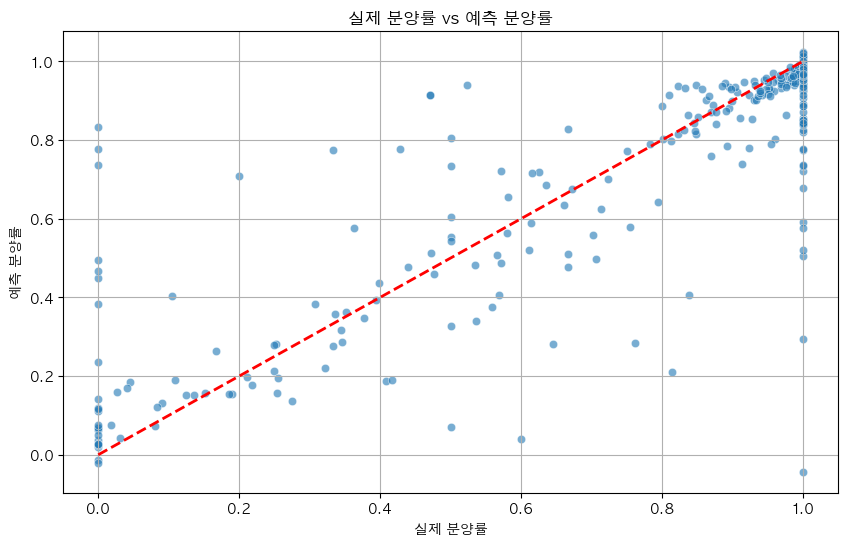

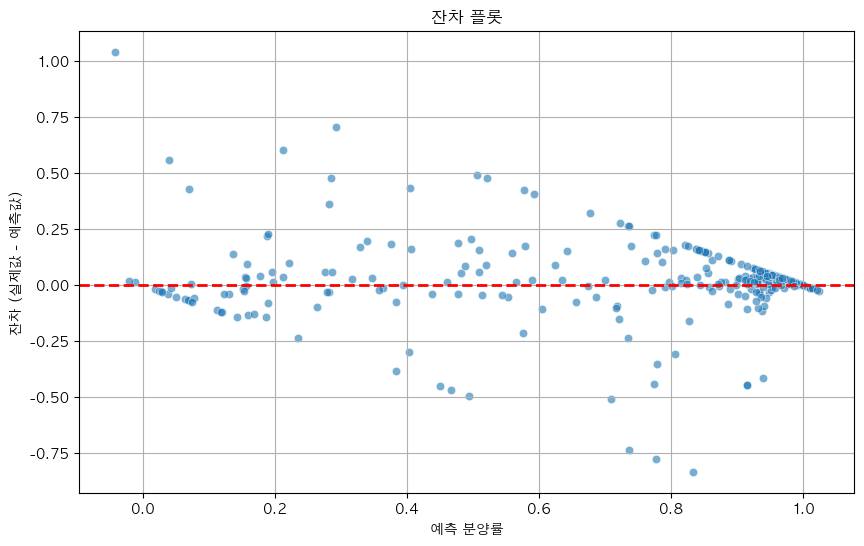

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


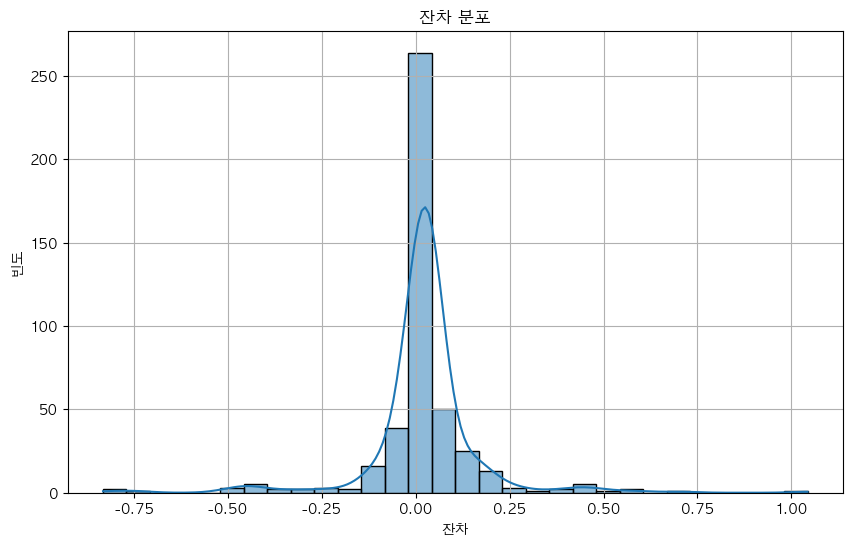

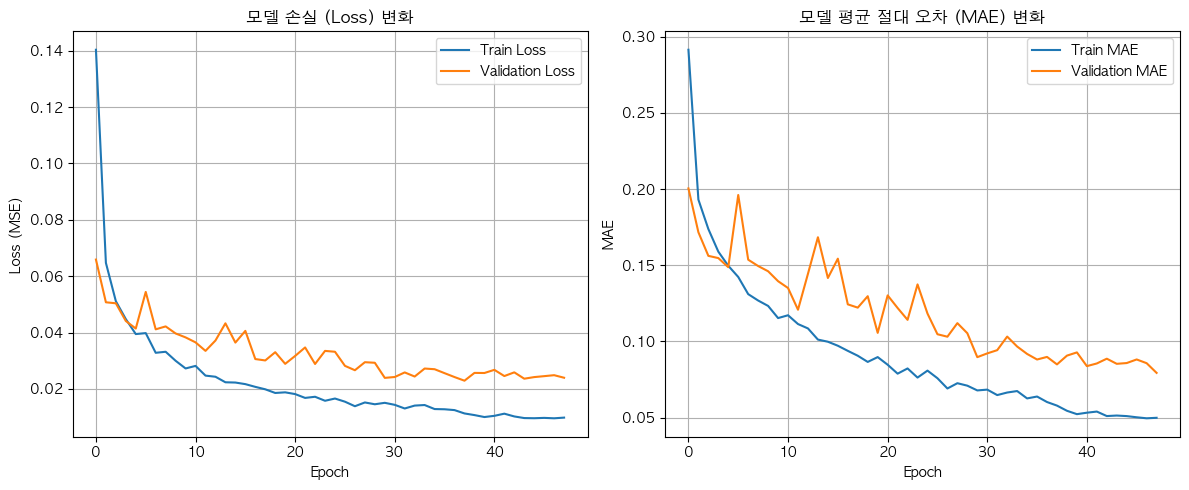

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

# 주변시세 평균(억 단위) 컬럼 제거 (사용자 요청에 따라 추가)
if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
X = df.drop(columns=[target_col])
y = df[target_col]

apartment_names_raw = X['아파트']
X_other = X.drop(columns=['아파트'])

categorical_features = ['지역', '준공여부', '건설사']
numerical_features = [col for col in X_other.columns if col not in categorical_features]

for col in numerical_features:
    if X_other[col].isnull().any():
        X_other[col] = X_other[col].fillna(X_other[col].median())

# 3. 학습/테스트 데이터 분할
X_train_other, X_test_other, y_train, y_test, apartment_train_raw, apartment_test_raw = train_test_split(
    X_other, y, apartment_names_raw, test_size=0.2, random_state=42
)

# 4. '아파트' 외 피처 (수치형 및 원-핫 인코딩된 피처) 전처리
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train_other)
X_test_processed = preprocessor.transform(X_test_other)

other_features_dim = X_train_processed.shape[1]

# 5. '아파트' 임베딩을 위한 어휘집 정의
unique_apartment_names_train = apartment_train_raw.unique().tolist()

vocab_size_apartment = len(unique_apartment_names_train) + 1
embedding_dim = min(50, (vocab_size_apartment + 1) // 2)
if embedding_dim == 0: embedding_dim = 1

# 6. 딥러닝 모델 구축 (성능 최적화 기법 적용)
other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')

string_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
embedding_layer = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim)

x_apartment = string_lookup_layer(apartment_input)
x_apartment = embedding_layer(x_apartment)
x_apartment = Flatten()(x_apartment)

concatenated_features = Concatenate()([other_features_input, x_apartment])

x = Dense(256, activation='relu')(concatenated_features)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[other_features_input, apartment_input], outputs=output)

# 7. 모델 컴파일
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 8. 모델 학습
print("모델 학습 중...")
history = model.fit(
    x=[X_train_processed, tf.constant(apartment_train_raw.values.reshape(-1, 1), dtype=tf.string)],
    y=y_train.values,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("모델 학습 완료.")

# 9. 테스트 세트로 모델 평가
print("\n테스트 세트로 모델 평가 중...")
loss, mae = model.evaluate(x=[X_test_processed, tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string)], y=y_test.values, verbose=0)
print(f"테스트 손실 (MSE): {loss:.4f}")
print(f"테스트 MAE: {mae:.4f}")

# 10. R2 스코어 계산 및 출력
y_pred = model.predict(x=[X_test_processed, tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string)]).flatten()
r2 = r2_score(y_test.values, y_pred)
print(f"테스트 R2 스코어: {r2:.4f}")

print("\n모델 요약:")
model.summary()

# 11. 성능 시각화
print("\n성능 시각화:")

# 11.1 실제값 vs 예측값 플롯
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.show()

# 11.2 잔차(Residual) 플롯
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("잔차 플롯")
plt.grid(True)
plt.show()

# 11.3 잔차의 분포 (히스토그램 또는 KDE 플롯)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title("잔차 분포")
plt.grid(True)
plt.show()

# 11.4 학습 곡선 시각화 (손실 및 MAE)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('모델 손실 (Loss) 변화')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('모델 평균 절대 오차 (MAE) 변화')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

정보: '주변시세 평균' 컬럼을 제거했습니다.
모델 학습 중...
Epoch 1/100


2025-07-22 09:48:57.777172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3313 - mae: 0.4492 - val_loss: 0.0621 - val_mae: 0.1763 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0761 - mae: 0.2127 - val_loss: 0.0569 - val_mae: 0.1786 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0583 - mae: 0.1847 - val_loss: 0.0517 - val_mae: 0.1709 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0491 - mae: 0.1664 - val_loss: 0.0474 - val_mae: 0.1644 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0479 - mae: 0.1604 - val_loss: 0.0488 - val_mae: 0.1577 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0435 - mae: 0.1550 - val_loss: 0.0458 - val_mae: 0.1606 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0366 - mae: 0.1382 - val_loss: 0.0443 - val_mae: 0.1685 - learning_rate: 0.0010
Epoch 8/100
50/50 

2025-07-22 09:49:59.783920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
테스트 R2 스코어: 0.7318

모델 요약:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ apartment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ region_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ construction_compa… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_5     │ (None, 1)         │          0 │ apartment_input[… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_6     │ (None, 1)         │          0 │ region_input[0][… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_7     │ (None, 1)         │          0 │ construction_com… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 50)     │     18,350 │ string_lookup_5[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 8)      │        120 │ string_lookup_6[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 50)     │     13,000 │ string_lookup_7[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features_inp… │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 8)         │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 143)       │          0 │ other_features_i… │
│ (Concatenate)       │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │     36,864 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 328,655 (1.25 MB)

 Trainable params: 109,551 (427.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 219,104 (855.88 KB)


성능 시각화:


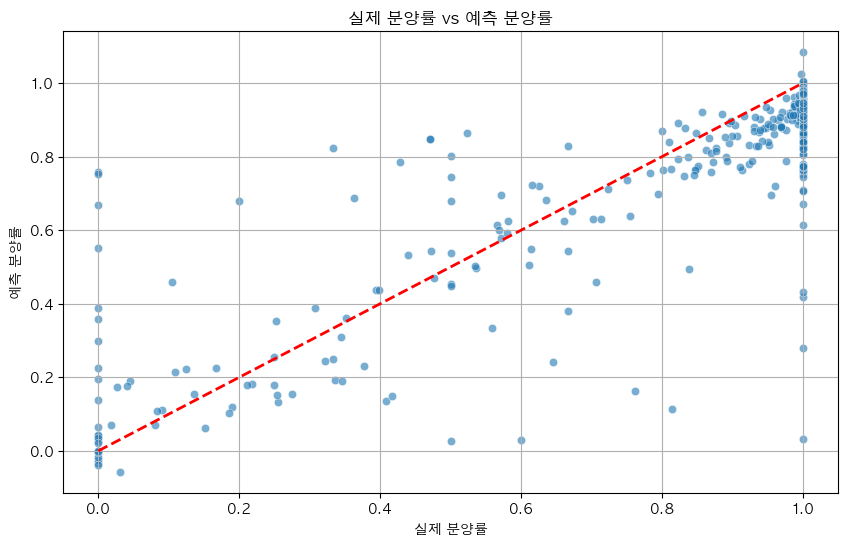

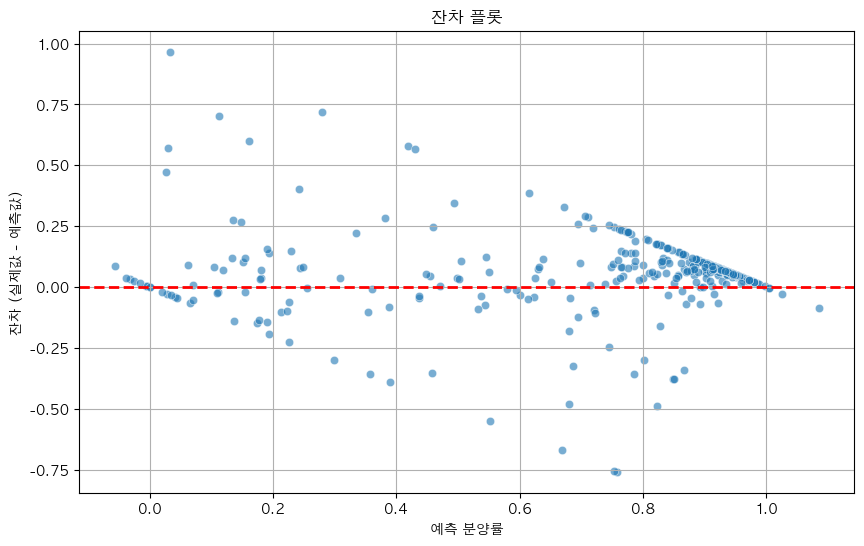

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


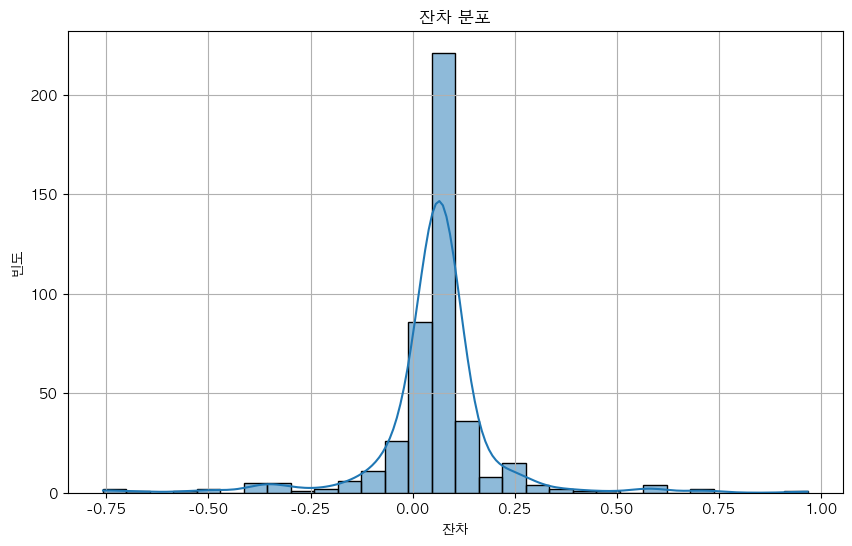

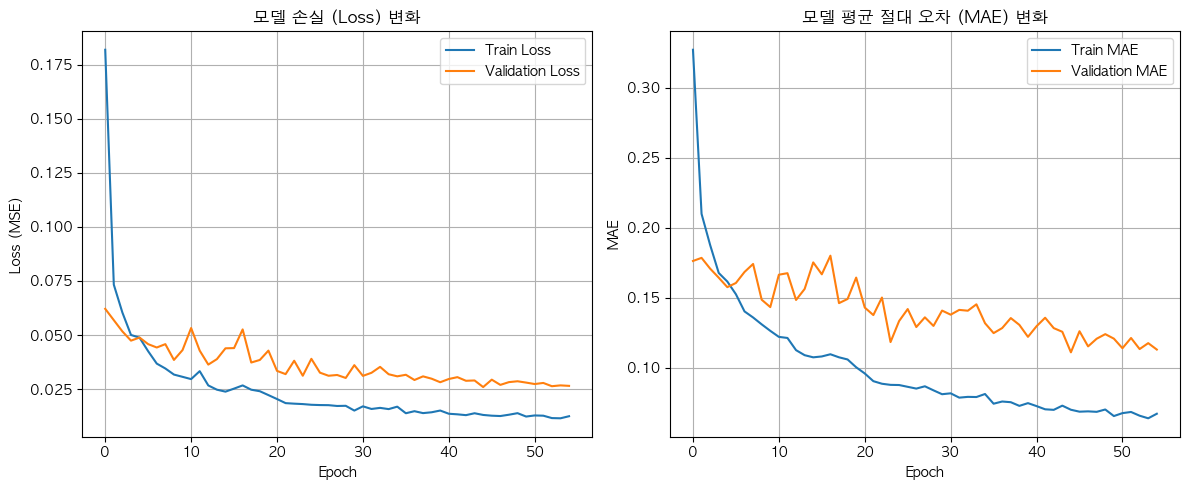

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

# 주변시세 평균(억 단위) 컬럼 제거
if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
X = df.drop(columns=[target_col])
y = df[target_col]

# 임베딩할 피처와 One-Hot 인코딩할 피처, 그리고 나머지 수치형 피처를 명확히 분리
apartment_names_raw = X['아파트']
region_names_raw = X['지역']       # 지역 컬럼 분리
construction_company_names_raw = X['건설사'] # 건설사 컬럼 분리

# 임베딩할 컬럼들을 X_other에서 제외
X_other = X.drop(columns=['아파트', '지역', '건설사'])

# One-Hot 인코딩할 범주형 피처는 '준공여부'만 남김
categorical_features_onehot = ['준공여부']
# 나머지 컬럼들은 모두 수치형으로 간주
numerical_features = [col for col in X_other.columns if col not in categorical_features_onehot]


for col in numerical_features:
    if X_other[col].isnull().any():
        X_other[col] = X_other[col].fillna(X_other[col].median())

# 3. 학습/테스트 데이터 분할
# 모든 원본 피처를 함께 분할하여 일관성 유지
X_train_other, X_test_other, y_train, y_test, \
apartment_train_raw, apartment_test_raw, \
region_train_raw, region_test_raw, \
construction_company_train_raw, construction_company_test_raw = train_test_split(
    X_other, y, apartment_names_raw, region_names_raw, construction_company_names_raw,
    test_size=0.2, random_state=42
)

# 4. '아파트', '지역', '건설사'를 제외한 피처 전처리 (수치형 스케일링, '준공여부' 원-핫 인코딩)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train_other)
X_test_processed = preprocessor.transform(X_test_other)

other_features_dim = X_train_processed.shape[1]

# 5. 임베딩을 위한 어휘집 정의
# 각 임베딩 대상 컬럼별로 고유 어휘집을 정의
unique_apartment_names_train = apartment_train_raw.unique().tolist()
unique_region_names_train = region_train_raw.unique().tolist()
unique_construction_company_names_train = construction_company_train_raw.unique().tolist()

# 임베딩 차원 계산 함수
def calculate_embedding_dim(vocab_size):
    emb_dim = min(50, (vocab_size + 1) // 2)
    return max(1, emb_dim) # 최소 1

vocab_size_apartment = len(unique_apartment_names_train) + 1
embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

vocab_size_region = len(unique_region_names_train) + 1
embedding_dim_region = calculate_embedding_dim(vocab_size_region)

vocab_size_construction_company = len(unique_construction_company_names_train) + 1
embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)


# 6. 딥러닝 모델 구축 (임베딩 피처 확장 적용)

# 공통 수치/원-핫 인코딩 피처 입력
other_features_input = Input(shape=(other_features_dim,), name='other_features_input')

# 아파트 이름 임베딩 브랜치
apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
x_apartment = string_lookup_apartment(apartment_input)
x_apartment = embedding_apartment(x_apartment)
x_apartment = Flatten()(x_apartment)

# 지역 임베딩 브랜치
region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
x_region = string_lookup_region(region_input)
x_region = embedding_region(x_region)
x_region = Flatten()(x_region)

# 건설사 임베딩 브랜치
construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')
string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
x_construction_company = string_lookup_construction_company(construction_company_input)
x_construction_company = embedding_construction_company(x_construction_company)
x_construction_company = Flatten()(x_construction_company)

# 모든 피처 연결
concatenated_features = Concatenate()([
    other_features_input,
    x_apartment,
    x_region,
    x_construction_company
])

# 딥러닝 모델 레이어
x = Dense(256, activation='relu')(concatenated_features)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)

# 모델 정의 (모든 입력 레이어 포함)
model = Model(inputs=[
    other_features_input,
    apartment_input,
    region_input,
    construction_company_input
], outputs=output)

# 7. 모델 컴파일
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 8. 모델 학습
print("모델 학습 중...")
history = model.fit(
    x=[
        X_train_processed,
        tf.constant(apartment_train_raw.values.reshape(-1, 1), dtype=tf.string),
        tf.constant(region_train_raw.values.reshape(-1, 1), dtype=tf.string),
        tf.constant(construction_company_train_raw.values.reshape(-1, 1), dtype=tf.string)
    ],
    y=y_train.values,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("모델 학습 완료.")

# 9. 테스트 세트로 모델 평가
print("\n테스트 세트로 모델 평가 중...")
loss, mae = model.evaluate(
    x=[
        X_test_processed,
        tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string),
        tf.constant(region_test_raw.values.reshape(-1, 1), dtype=tf.string),
        tf.constant(construction_company_test_raw.values.reshape(-1, 1), dtype=tf.string)
    ],
    y=y_test.values,
    verbose=0
)
print(f"테스트 손실 (MSE): {loss:.4f}")
print(f"테스트 MAE: {mae:.4f}")

# 10. R2 스코어 계산 및 출력
y_pred = model.predict(
    x=[
        X_test_processed,
        tf.constant(apartment_test_raw.values.reshape(-1, 1), dtype=tf.string),
        tf.constant(region_test_raw.values.reshape(-1, 1), dtype=tf.string),
        tf.constant(construction_company_test_raw.values.reshape(-1, 1), dtype=tf.string)
    ]
).flatten()
r2 = r2_score(y_test.values, y_pred)
print(f"테스트 R2 스코어: {r2:.4f}")

print("\n모델 요약:")
model.summary()

# 11. 성능 시각화
print("\n성능 시각화:")

# 11.1 실제값 vs 예측값 플롯
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.show()

# 11.2 잔차(Residual) 플롯
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("잔차 플롯")
plt.grid(True)
plt.show()

# 11.3 잔차의 분포 (히스토그램 또는 KDE 플롯)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title("잔차 분포")
plt.grid(True)
plt.show()

# 11.4 학습 곡선 시각화 (손실 및 MAE)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('모델 손실 (Loss) 변화')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('모델 평균 절대 오차 (MAE) 변화')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

정보: '주변시세 평균' 컬럼을 제거했습니다.

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

2025-07-22 09:51:14.843996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
폴드 1 - 손실 (MSE): 0.0243, MAE: 0.1067, R2 스코어: 0.7457

--- 폴드 2/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
폴드 2 - 손실 (MSE): 0.0252, MAE: 0.1064, R2 스코어: 0.7441

--- 폴드 3/5 ---
 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

2025-07-22 09:53:17.640513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
폴드 3 - 손실 (MSE): 0.0270, MAE: 0.0878, R2 스코어: 0.7252

--- 폴드 4/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
폴드 4 - 손실 (MSE): 0.0251, MAE: 0.1046, R2 스코어: 0.7111

--- 폴드 5/5 ---
 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 

2025-07-22 09:54:41.343422: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
폴드 5 - 손실 (MSE): 0.0203, MAE: 0.0791, R2 스코어: 0.7952

--- 교차 검증 요약 ---
평균 MSE: 0.0244 (표준편차: 0.0022)
평균 MAE: 0.0969 (표준편차: 0.0114)
평균 R2 스코어: 0.7443 (표준편차: 0.0285)

성능 시각화:


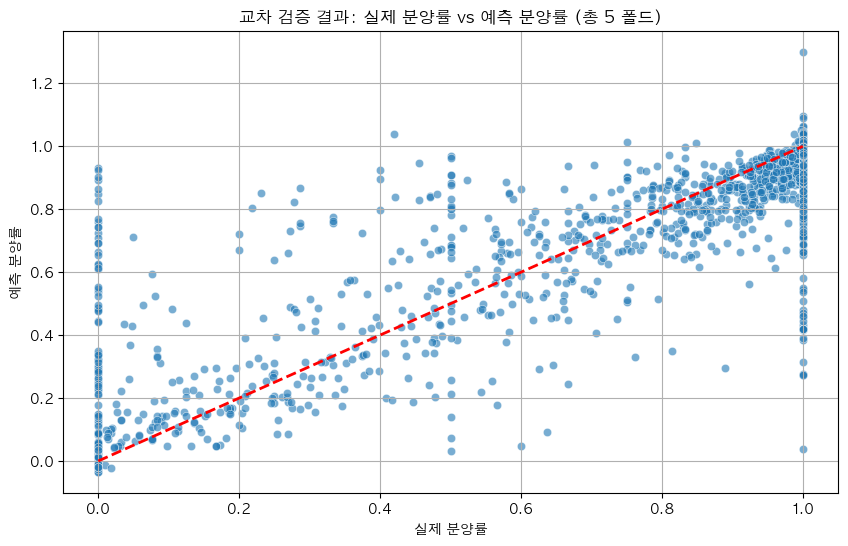

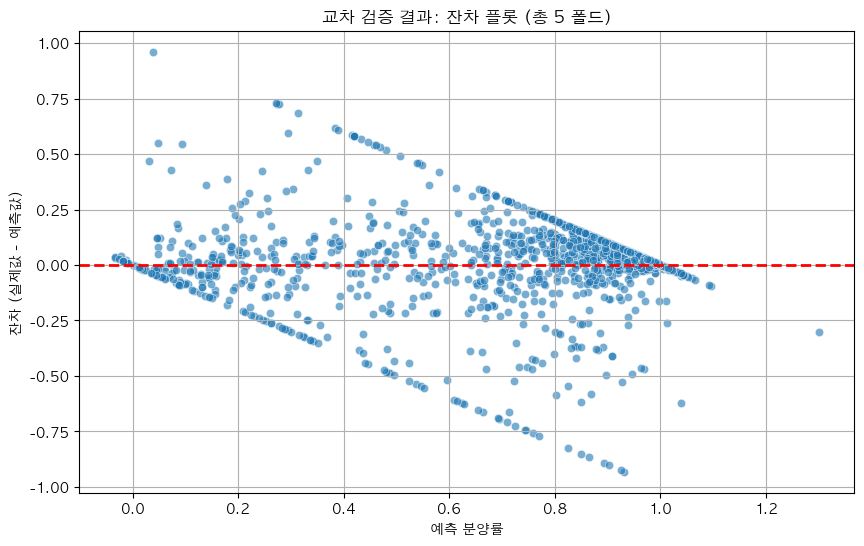

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


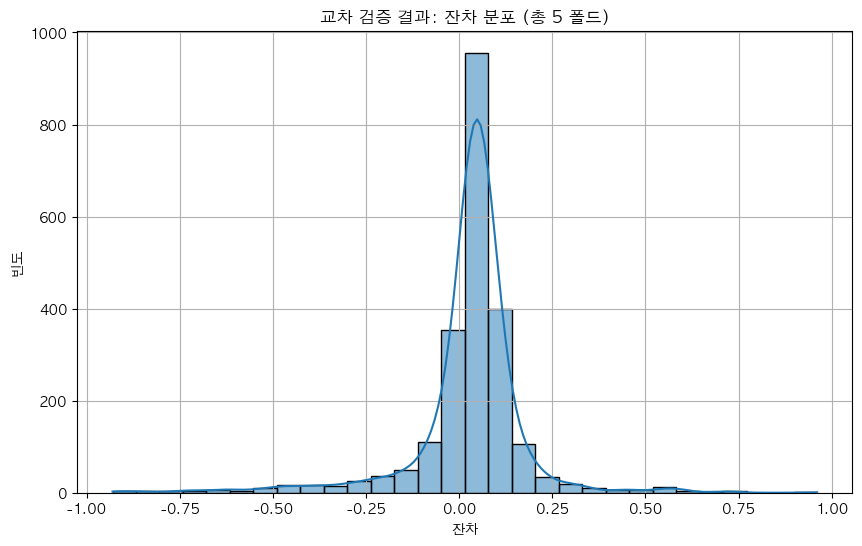

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold # KFold 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # 추가
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

# 주변시세 평균(억 단위) 컬럼 제거
if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
y = df[target_col]
# 모든 피처를 포함하는 DataFrame (원시 문자열 컬럼 포함)
X_all_features = df.drop(columns=[target_col])

# --- 교차 검증 설정 ---
n_splits = 5 # 폴드 수 설정
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 각 폴드의 평가 지표를 저장할 리스트
fold_mses = []
fold_maes = []
fold_r2s = []

# 전체 데이터셋에 대한 예측값을 저장할 리스트 (시각화를 위해)
all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    # 데이터 분할 (현재 폴드의 학습 및 검증 데이터)
    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # 각 폴드 내에서 임베딩 및 원-핫 인코딩할 피처와 수치형 피처 분리
    apartment_train_fold = X_train_fold['아파트']
    region_train_fold = X_train_fold['지역']
    construction_company_train_fold = X_train_fold['건설사']
    X_other_train_fold = X_train_fold.drop(columns=['아파트', '지역', '건설사'])

    apartment_val_fold = X_val_fold['아파트']
    region_val_fold = X_val_fold['지역']
    construction_company_val_fold = X_val_fold['건설사']
    X_other_val_fold = X_val_fold.drop(columns=['아파트', '지역', '건설사'])

    # One-Hot 인코딩할 범주형 피처는 '준공여부'만
    categorical_features_onehot = ['준공여부']
    # 나머지 컬럼들은 모두 수치형으로 간주
    numerical_features = [col for col in X_other_train_fold.columns if col not in categorical_features_onehot]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    # ColumnTransformer 재정의 및 학습 (각 폴드마다 새로 fit)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_other_train_fold)
    X_val_processed = preprocessor.transform(X_other_val_fold)
    other_features_dim = X_train_processed.shape[1]

    # 임베딩을 위한 어휘집 정의 (각 폴드의 학습 데이터에서만 정의)
    unique_apartment_names_train = apartment_train_fold.unique().tolist()
    unique_region_names_train = region_train_fold.unique().tolist()
    unique_construction_company_names_train = construction_company_train_fold.unique().tolist()

    # 임베딩 차원 계산 함수
    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim) # 최소 1

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 (각 폴드마다 새로 생성) ---
    # 각 Input 레이어 정의
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    # 아파트 임베딩 브랜치
    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    # 지역 임베딩 브랜치
    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    # 건설사 임베딩 브랜치
    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    # 모든 피처 연결
    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    # 딥러닝 모델 레이어 (뉴런 수 증가 및 Dropout 추가)
    x = Dense(256, activation='relu')(concatenated_features)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    # 모델 정의 (모든 입력 레이어 포함)
    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    # 콜백 정의
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0) # verbose 0으로 변경하여 로그 간소화

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            X_train_processed,
            tf.constant(apartment_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_train_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_train_fold.values,
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                X_val_processed,
                tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
            ],
            y_val_fold.values
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0 # 학습 진행 로그는 폴드 시작 시에만 표시하고 상세 로그는 끕니다.
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_val_fold.values,
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    # 전체 시각화를 위해 실제값과 예측값 수집
    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

# 11.1 실제값 vs 예측값 플롯
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# 11.2 잔차(Residual) 플롯
overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# 11.3 잔차의 분포 (히스토그램 또는 KDE 플롯)
plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# 참고: 학습 곡선 (history)는 각 폴드마다 다르므로, 통합된 학습 곡선은 이 코드에서 직접 제공하기 어렵습니다.
# 필요하다면 각 폴드별 history 객체를 저장하는 리스트를 만들어 나중에 개별적으로 시각화할 수 있습니다.
# 예를 들어, histories = [] 리스트에 history 객체를 추가하고, 나중에 각 폴드의 학습 곡선을 그릴 수 있습니다.

---
# CNN 추가할거임
---

정보: '주변시세 평균' 컬럼을 제거했습니다.

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---


2025-07-22 10:11:36.548300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

2025-07-22 10:12:43.776816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
폴드 1 - 손실 (MSE): 0.0176, MAE: 0.0652, R2 스코어: 0.8157

--- 폴드 2/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
폴드 2 - 손실 (MSE): 0.0220, MAE: 0.0753, R2 스코어: 0.7774

--- 폴드 3/5 ---
 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

2025-07-22 10:14:36.802625: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
폴드 3 - 손실 (MSE): 0.0261, MAE: 0.0762, R2 스코어: 0.7348

--- 폴드 4/5 ---
 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 

2025-07-22 10:15:45.223977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
폴드 4 - 손실 (MSE): 0.0226, MAE: 0.0892, R2 스코어: 0.7404

--- 폴드 5/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
폴드 5 - 손실 (MSE): 0.0238, MAE: 0.0970, R2 스코어: 0.7607

--- 교차 검증 요약 ---
평균 MSE: 0.0224 (표준편차: 0.0028)
평균 MAE: 0.0806 (표준편차: 0.0112)
평균 R2 스코어: 0.7658 (표준편차: 0.0292)

성능 시각화:


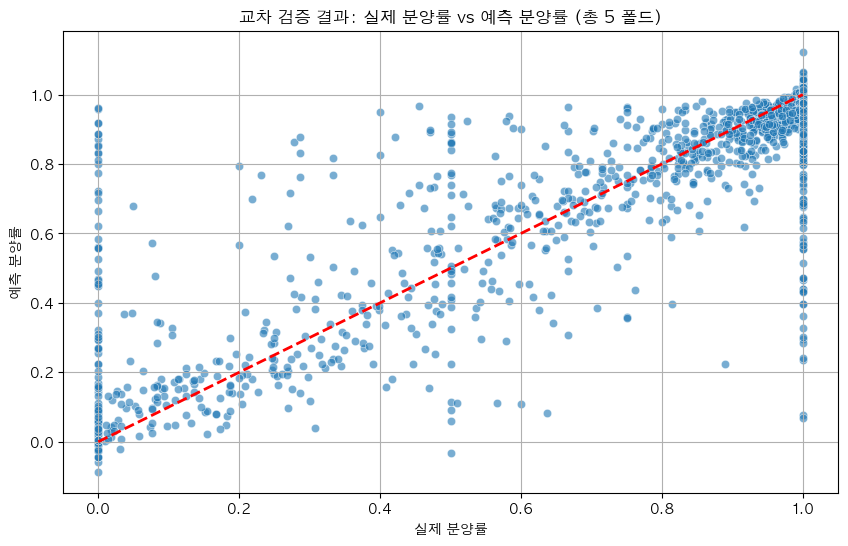

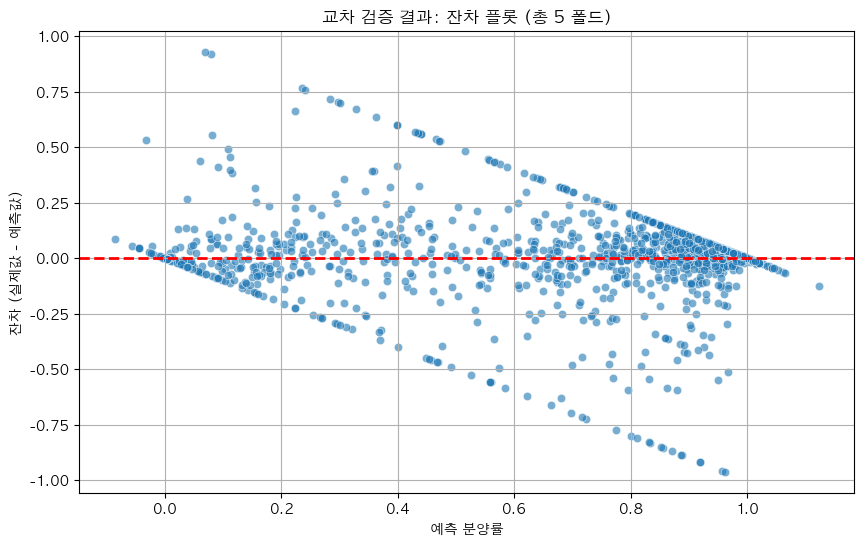

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


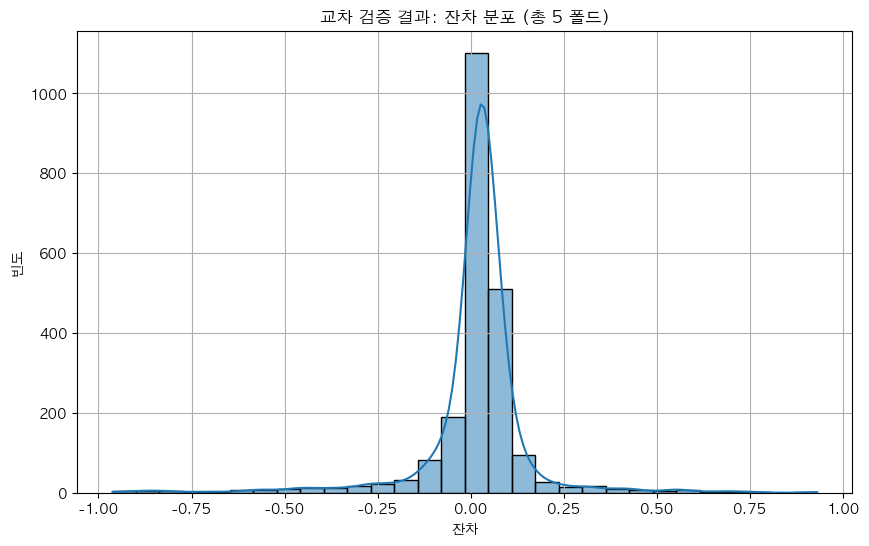

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
y = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- 교차 검증 설정 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    apartment_train_fold = X_train_fold['아파트']
    region_train_fold = X_train_fold['지역']
    construction_company_train_fold = X_train_fold['건설사']
    X_other_train_fold = X_train_fold.drop(columns=['아파트', '지역', '건설사'])

    apartment_val_fold = X_val_fold['아파트']
    region_val_fold = X_val_fold['지역']
    construction_company_val_fold = X_val_fold['건설사']
    X_other_val_fold = X_val_fold.drop(columns=['아파트', '지역', '건설사'])

    categorical_features_onehot = ['준공여부']
    numerical_features = [col for col in X_other_train_fold.columns if col not in categorical_features_onehot]

    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_other_train_fold)
    X_val_processed = preprocessor.transform(X_other_val_fold)
    other_features_dim = X_train_processed.shape[1]

    unique_apartment_names_train = apartment_train_fold.unique().tolist()
    unique_region_names_train = region_train_fold.unique().tolist()
    unique_construction_company_names_train = construction_company_train_fold.unique().tolist()

    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 (CNN 레이어 제거) ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    # CNN 관련 레이어 (tf.keras.ops.cast, tf.keras.ops.expand_dims, Conv1D, GlobalMaxPooling1D) 제거
    # 이제 concatenated_features가 바로 Dense 레이어로 연결됩니다.
    x = Dense(256, activation='relu')(concatenated_features) # CNN 없이 직접 연결
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            X_train_processed,
            tf.constant(apartment_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_train_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_train_fold.values,
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                X_val_processed,
                tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
            ],
            y_val_fold.values
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_val_fold.values,
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

정보: '주변시세 평균' 컬럼을 제거했습니다.

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---


2025-07-22 10:23:16.426368: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-22 10:23:16.426426: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-22 10:23:16.426431: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-22 10:23:16.426477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-22 10:23:16.426495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-22 10:23:17.680716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-22 10:23:17.690451: E te

10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  

2025-07-22 10:25:07.821401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
폴드 1 - 손실 (MSE): 0.0199, MAE: 0.0817, R2 스코어: 0.7914

--- 폴드 2/5 ---
 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

2025-07-22 10:26:51.429402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
폴드 2 - 손실 (MSE): 0.0259, MAE: 0.0874, R2 스코어: 0.7372

--- 폴드 3/5 ---
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

2025-07-22 10:29:27.972311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
폴드 3 - 손실 (MSE): 0.0269, MAE: 0.0901, R2 스코어: 0.7271

--- 폴드 4/5 ---
 1/14 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step

2025-07-22 10:31:26.744475: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
폴드 4 - 손실 (MSE): 0.0246, MAE: 0.0858, R2 스코어: 0.7167

--- 폴드 5/5 ---


2025-07-22 10:32:45.987128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
폴드 5 - 손실 (MSE): 0.0295, MAE: 0.1065, R2 스코어: 0.7031

--- 교차 검증 요약 ---
평균 MSE: 0.0254 (표준편차: 0.0032)
평균 MAE: 0.0903 (표준편차: 0.0085)
평균 R2 스코어: 0.7351 (표준편차: 0.0303)

성능 시각화:


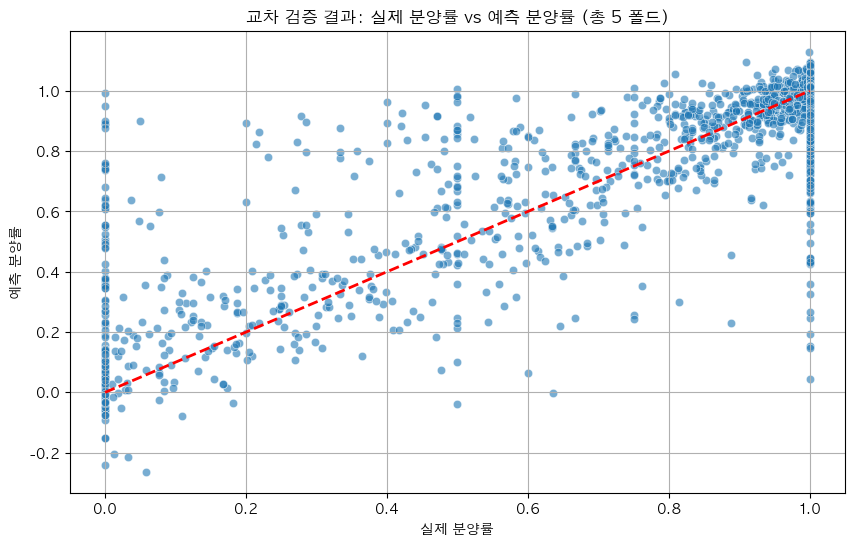

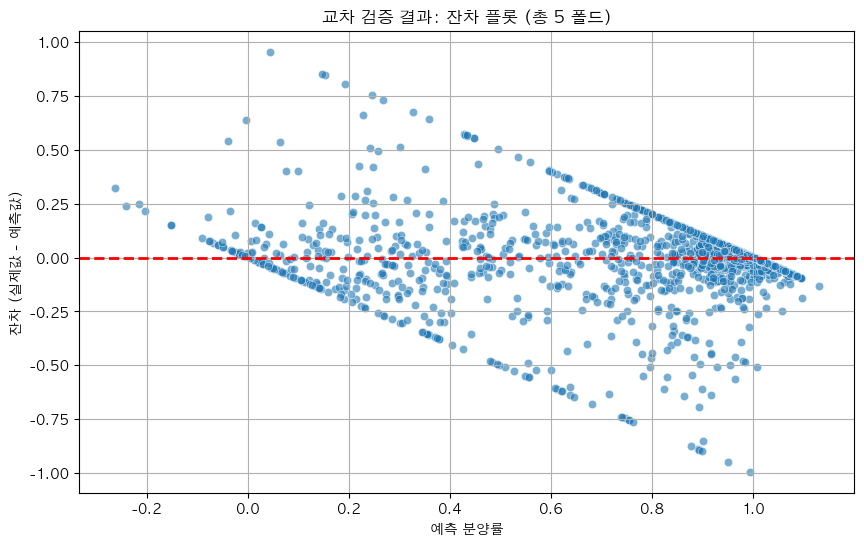

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


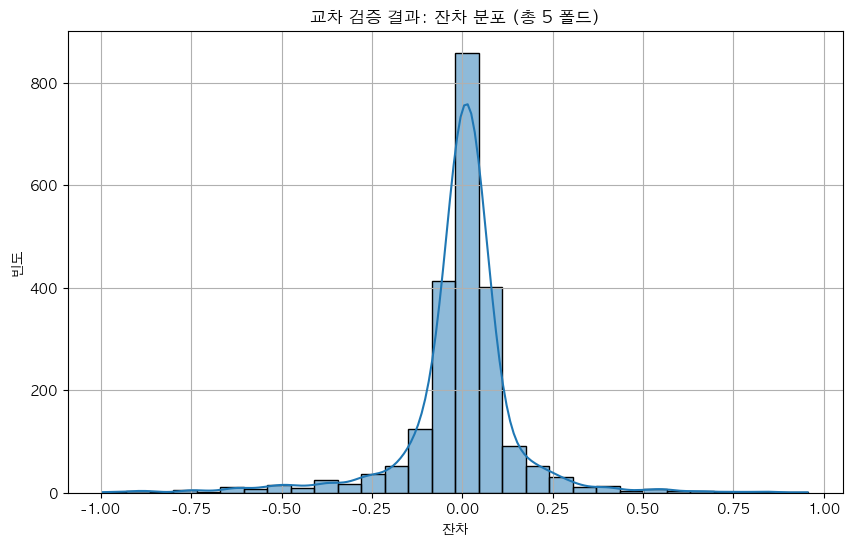

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization # BatchNormalization 추가
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
y = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- 교차 검증 설정 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    apartment_train_fold = X_train_fold['아파트']
    region_train_fold = X_train_fold['지역']
    construction_company_train_fold = X_train_fold['건설사']
    X_other_train_fold = X_train_fold.drop(columns=['아파트', '지역', '건설사'])

    apartment_val_fold = X_val_fold['아파트']
    region_val_fold = X_val_fold['지역']
    construction_company_val_fold = X_val_fold['건설사']
    X_other_val_fold = X_val_fold.drop(columns=['아파트', '지역', '건설사'])

    categorical_features_onehot = ['준공여부']
    numerical_features = [col for col in X_other_train_fold.columns if col not in categorical_features_onehot]

    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_other_train_fold)
    X_val_processed = preprocessor.transform(X_other_val_fold)
    other_features_dim = X_train_processed.shape[1]

    unique_apartment_names_train = apartment_train_fold.unique().tolist()
    unique_region_names_train = region_train_fold.unique().tolist()
    unique_construction_company_names_train = construction_company_train_fold.unique().tolist()

    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 (Batch Normalization 추가) ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    # BatchNormalization 레이어 추가
    x = Dense(256)(concatenated_features)
    x = BatchNormalization()(x) # BatchNormalization 추가
    x = tf.keras.activations.relu(x) # 활성화 함수를 BatchNormalization 뒤로 이동
    x = Dropout(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x) # BatchNormalization 추가
    x = tf.keras.activations.relu(x) # 활성화 함수를 BatchNormalization 뒤로 이동
    x = Dropout(0.2)(x)

    x = Dense(64)(x)
    x = BatchNormalization()(x) # BatchNormalization 추가
    x = tf.keras.activations.relu(x) # 활성화 함수를 BatchNormalization 뒤로 이동
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            X_train_processed,
            tf.constant(apartment_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_train_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_train_fold.values,
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                X_val_processed,
                tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
            ],
            y_val_fold.values
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_val_fold.values,
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

---
# 검증하고 컬럼 정리 후에 다시 모델 돌릴거임
---

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # statsmodels 추가

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 (공통 부분)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
y = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- OLS 모델을 통한 p-value 기반 피처 선택 ---
print("\n--- OLS 모델을 통한 p-value 기반 피처 선택 ---")

# OLS 분석에 사용할 피처 그룹 정의 (임베딩할 피처는 OLS 분석 대상에서 제외)
features_to_embed = ['아파트', '지역', '건설사']
numerical_cols_initial = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist() if col not in features_to_embed]
categorical_cols_onehot_initial = ['준공여부'] # OLS에서도 원-핫 인코딩하여 사용

# OLS를 위한 데이터 준비
X_for_ols = X_all_features[numerical_cols_initial + categorical_cols_onehot_initial].copy()

# OLS 분석 전 수치형 피처의 결측값 처리 (전체 데이터셋에 대해 미리 처리)
for col in numerical_cols_initial:
    if X_for_ols[col].isnull().any():
        X_for_ols[col] = X_for_ols[col].fillna(X_for_ols[col].median())


# OLS를 위한 One-Hot 인코더 (Scikit-learn의 OneHotEncoder 사용)
ols_preprocessor_for_selection = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_initial), # 수치형 피처 스케일링
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_onehot_initial)
    ],
    remainder='passthrough'
)

# OLS용 데이터 변환
X_ols_processed_transformed = ols_preprocessor_for_selection.fit_transform(X_for_ols)

# 변환된 피처 이름 가져오기
ols_transformed_feature_names = ols_preprocessor_for_selection.get_feature_names_out()

# 변환된 데이터를 DataFrame으로 만들고 상수항 추가
X_ols_df = pd.DataFrame(X_ols_processed_transformed, columns=ols_transformed_feature_names, index=X_for_ols.index)
X_ols_df = sm.add_constant(X_ols_df) # 상수항 추가

# OLS 모델 학습
ols_model = sm.OLS(y, X_ols_df).fit()

# p-값 추출 및 유의미한 피처 선택
p_values = ols_model.pvalues
significant_p_threshold = 0.05
selected_ols_transformed_names = p_values[p_values < significant_p_threshold].index.tolist()

if 'const' in selected_ols_transformed_names: # 상수항 제외
    selected_ols_transformed_names.remove('const')

print(f"p-value < {significant_p_threshold}을 만족하는 유의미한 변환된 피처 수: {len(selected_ols_transformed_names)}")
print(f"선택된 OLS 기반 변환된 피처 이름: {selected_ols_transformed_names}")

# **수정된 부분**: 변환된 피처 이름을 원본 컬럼 이름으로 다시 매핑하는 로직 개선
final_numerical_features_for_dl = []
final_categorical_features_onehot_for_dl = []

# ColumnTransformer의 get_feature_names_out()을 통해 얻은 이름을 파싱하여 원본 이름 매핑
feature_map = {}
for original_col in numerical_cols_initial:
    # StandardScaler는 하나의 컬럼에 대해 하나의 변환된 이름만 생성 (예: 'num__금리')
    transformed_name = f"num__{original_col}"
    if transformed_name in ols_transformed_feature_names: # 실제로 변환된 피처 목록에 있는지 확인
        feature_map[transformed_name] = original_col

for original_col in categorical_cols_onehot_initial:
    # OneHotEncoder는 여러 변환된 컬럼을 만들 수 있음 (예: 'cat__준공여부_준공', 'cat__준공여부_미준공')
    # get_feature_names_out을 직접 사용하여 매핑
    transformed_names_list_for_cat = ols_preprocessor_for_selection.named_transformers_['cat'].get_feature_names_out([original_col])
    for transformed_name_part in transformed_names_list_for_cat:
        if transformed_name_part in ols_transformed_feature_names: # 실제로 변환된 피처 목록에 있는지 확인
            feature_map[transformed_name_part] = original_col


# 선택된 변환된 이름들을 통해 최종 사용할 원본 피처 리스트 구성
for transformed_name in selected_ols_transformed_names:
    if transformed_name in feature_map: # 매핑 딕셔너리에 있는 변환된 이름만 처리
        original_col_name = feature_map[transformed_name]
        if original_col_name in numerical_cols_initial and original_col_name not in final_numerical_features_for_dl:
            final_numerical_features_for_dl.append(original_col_name)
        elif original_col_name in categorical_cols_onehot_initial and original_col_name not in final_categorical_features_onehot_for_dl:
            final_categorical_features_onehot_for_dl.append(original_col_name)

print(f"\nDL 모델에 사용될 최종 수치형 피처 (원본 이름): {final_numerical_features_for_dl}")
print(f"DL 모델에 사용될 최종 원-핫 인코딩 피처 (원본 이름): {final_categorical_features_onehot_for_dl}")


# --- 교차 검증 설정 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 (선택된 피처 사용) ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # **수정된 부분**: 인덱스 초기화 추가
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_val_fold = X_val_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)


    apartment_train_fold = X_train_fold['아파트']
    region_train_fold = X_train_fold['지역']
    construction_company_train_fold = X_train_fold['건설사']

    # X_other는 이제 OLS로 선택된 피처들만 포함
    X_other_train_fold = X_train_fold[final_numerical_features_for_dl + final_categorical_features_onehot_for_dl]
    X_other_val_fold = X_val_fold[final_numerical_features_for_dl + final_categorical_features_onehot_for_dl]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    for col in final_numerical_features_for_dl: # OLS에서 선택된 수치형 피처에 대해
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    # ColumnTransformer는 이제 `final_numerical_features_for_dl`과 `final_categorical_features_onehot_for_dl`만 사용
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), final_numerical_features_for_dl),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), final_categorical_features_onehot_for_dl)
        ],
        remainder='passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_other_train_fold)
    X_val_processed = preprocessor.transform(X_other_val_fold)
    other_features_dim = X_train_processed.shape[1]


    unique_apartment_names_train = apartment_train_fold.unique().tolist()
    unique_region_names_train = region_train_fold.unique().tolist()
    unique_construction_company_names_train = construction_company_train_fold.unique().tolist()

    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    x = Dense(256)(concatenated_features)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.2)(x)

    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            X_train_processed,
            tf.constant(apartment_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_train_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_train_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_train_fold.values,
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                X_val_processed,
                tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
                tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
            ],
            y_val_fold.values
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ],
        y=y_val_fold.values,
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            X_val_processed,
            tf.constant(apartment_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(region_val_fold.values.reshape(-1, 1), dtype=tf.string),
            tf.constant(construction_company_val_fold.values.reshape(-1, 1), dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

정보: '주변시세 평균' 컬럼을 제거했습니다.

--- OLS 모델을 통한 p-value 기반 피처 선택 ---
p-value < 0.05을 만족하는 유의미한 변환된 피처 수: 19
선택된 OLS 기반 변환된 피처 이름: ['num__공급면적(㎡)', 'num__전용면적(㎡)', 'num__특별분양', 'num__세대수', 'num__미분양수', 'num__분양가(만원)', 'num__환율', 'num__대형쇼핑 - 3km 이내', 'num__편의점 - 500m 이내', 'num__중학교(2km 이내)', 'num__고등학교(2km 이내)', 'num__지하철 - 반경 1.5km 이내', 'num__고속철도 - 10km 이내', 'num__주변시세 평균(만원)', 'num__시세차익(만원)', 'num__년', 'cat__준공여부_미준공', 'cat__준공여부_부분준공', 'cat__준공여부_준공']

DL 모델에 사용될 최종 수치형 피처 (원본 이름): ['공급면적(㎡)', '전용면적(㎡)', '특별분양', '세대수', '미분양수', '분양가(만원)', '환율', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '고속철도 - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년']
DL 모델에 사용될 최종 원-핫 인코딩 피처 (원본 이름): []

--- 5-Fold 교차 검증 시작 (선택된 피처 사용) ---

--- 폴드 1/5 ---


2025-07-22 11:08:30.669633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 443, 442, 442, 442
'y' sizes: 443


정보: '주변시세 평균' 컬럼을 제거했습니다.

--- OLS 모델을 통한 p-value 기반 피처 선택 ---
p-value < 0.05을 만족하는 유의미한 변환된 피처 수: 19
선택된 OLS 기반 변환된 피처 이름: ['num__공급면적(㎡)', 'num__전용면적(㎡)', 'num__특별분양', 'num__세대수', 'num__미분양수', 'num__분양가(만원)', 'num__환율', 'num__대형쇼핑 - 3km 이내', 'num__편의점 - 500m 이내', 'num__중학교(2km 이내)', 'num__고등학교(2km 이내)', 'num__지하철 - 반경 1.5km 이내', 'num__고속철도 - 10km 이내', 'num__주변시세 평균(만원)', 'num__시세차익(만원)', 'num__년', 'cat__준공여부_미준공', 'cat__준공여부_부분준공', 'cat__준공여부_준공']

DL 모델에 사용될 최종 수치형 피처 (원본 이름): ['공급면적(㎡)', '전용면적(㎡)', '특별분양', '세대수', '미분양수', '분양가(만원)', '환율', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '고속철도 - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년']
DL 모델에 사용될 최종 원-핫 인코딩 피처 (원본 이름): []

--- 5-Fold 교차 검증 시작 (선택된 피처 사용) ---

--- 폴드 1/5 ---
DEBUG: Defining x_train_processed_np for fold 1
DEBUG: x_train_processed_np defined. Shape: (1771, 16)


2025-07-22 11:37:23.133976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
폴드 1 - 손실 (MSE): 0.0201, MAE: 0.0853, R2 스코어: 0.7898

--- 폴드 2/5 ---
DEBUG: Defining x_train_processed_np for fold 2
DEBUG: x_train_processed_np defined. Shape: (1771, 16)
 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

2025-07-22 11:39:14.999338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
폴드 2 - 손실 (MSE): 0.0227, MAE: 0.0871, R2 스코어: 0.7696

--- 폴드 3/5 ---
DEBUG: Defining x_train_processed_np for fold 3
DEBUG: x_train_processed_np defined. Shape: (1771, 16)
 6/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

2025-07-22 11:40:17.731688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
폴드 3 - 손실 (MSE): 0.0308, MAE: 0.0936, R2 스코어: 0.6873

--- 폴드 4/5 ---
DEBUG: Defining x_train_processed_np for fold 4
DEBUG: x_train_processed_np defined. Shape: (1771, 16)
 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 

2025-07-22 11:41:24.293363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
폴드 4 - 손실 (MSE): 0.0212, MAE: 0.0768, R2 스코어: 0.7563

--- 폴드 5/5 ---
DEBUG: Defining x_train_processed_np for fold 5
DEBUG: x_train_processed_np defined. Shape: (1772, 16)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
폴드 5 - 손실 (MSE): 0.0328, MAE: 0.1275, R2 스코어: 0.6697

--- 교차 검증 요약 ---
평균 MSE: 0.0255 (표준편차: 0.0052)
평균 MAE: 0.0941 (표준편차: 0.0175)
평균 R2 스코어: 0.7346 (표준편차: 0.0473)

성능 시각화:


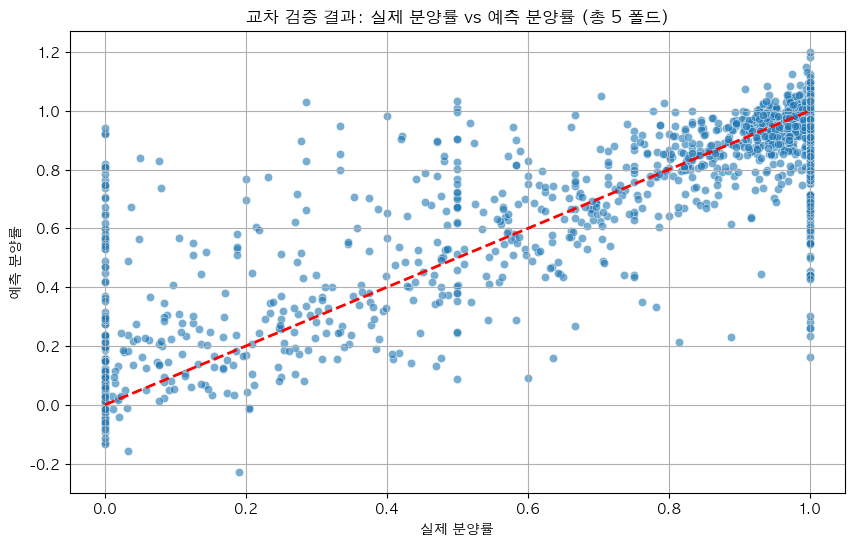

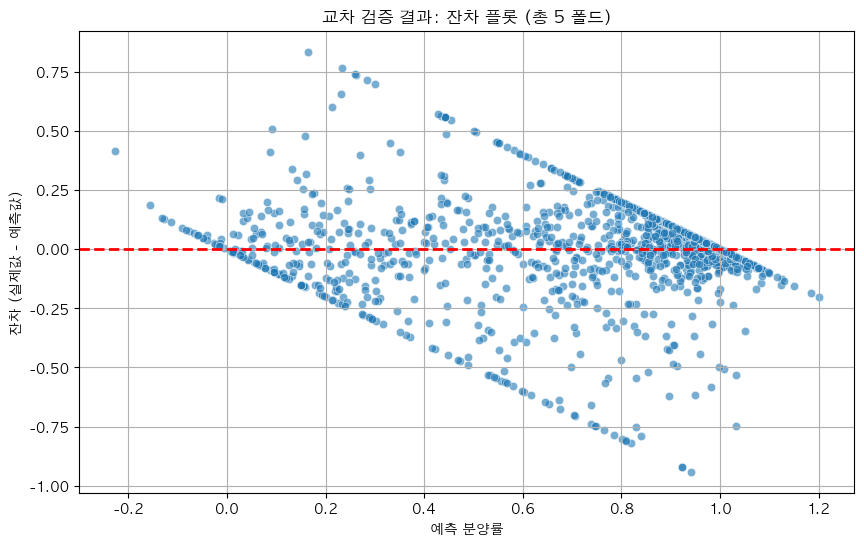

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


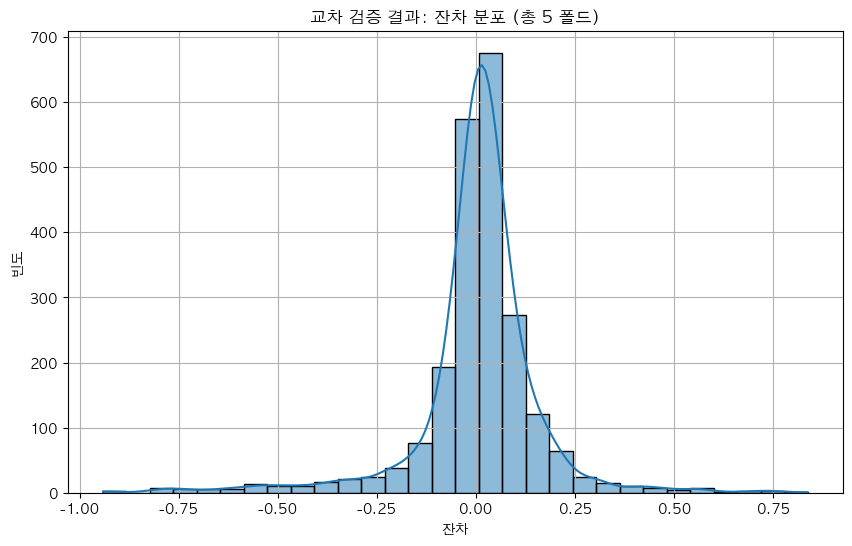

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # statsmodels 추가

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 (공통 부분)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

target_col = '분양률'
y = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- OLS 모델을 통한 p-value 기반 피처 선택 ---
print("\n--- OLS 모델을 통한 p-value 기반 피처 선택 ---")

# OLS 분석에 사용할 피처 그룹 정의 (임베딩할 피처는 OLS 분석 대상에서 제외)
features_to_embed = ['아파트', '지역', '건설사']
numerical_cols_initial = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist() if col not in features_to_embed]
categorical_cols_onehot_initial = ['준공여부'] # OLS에서도 원-핫 인코딩하여 사용

# OLS를 위한 데이터 준비
X_for_ols = X_all_features[numerical_cols_initial + categorical_cols_onehot_initial].copy()

# OLS 분석 전 수치형 피처의 결측값 처리 (전체 데이터셋에 대해 미리 처리)
for col in numerical_cols_initial:
    if X_for_ols[col].isnull().any():
        X_for_ols[col] = X_for_ols[col].fillna(X_for_ols[col].median())


# OLS를 위한 One-Hot 인코더 (Scikit-learn의 OneHotEncoder 사용)
ols_preprocessor_for_selection = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_initial), # 수치형 피처 스케일링
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_onehot_initial)
    ],
    remainder='passthrough'
)

# OLS용 데이터 변환
X_ols_processed_transformed = ols_preprocessor_for_selection.fit_transform(X_for_ols)

# 변환된 피처 이름 가져오기
ols_transformed_feature_names = ols_preprocessor_for_selection.get_feature_names_out()

# 변환된 데이터를 DataFrame으로 만들고 상수항 추가
X_ols_df = pd.DataFrame(X_ols_processed_transformed, columns=ols_transformed_feature_names, index=X_for_ols.index)
X_ols_df = sm.add_constant(X_ols_df) # 상수항 추가

# OLS 모델 학습
ols_model = sm.OLS(y, X_ols_df).fit()

# p-값 추출 및 유의미한 피처 선택
p_values = ols_model.pvalues
significant_p_threshold = 0.05
selected_ols_transformed_names = p_values[p_values < significant_p_threshold].index.tolist()

if 'const' in selected_ols_transformed_names: # 상수항 제외
    selected_ols_transformed_names.remove('const')

print(f"p-value < {significant_p_threshold}을 만족하는 유의미한 변환된 피처 수: {len(selected_ols_transformed_names)}")
print(f"선택된 OLS 기반 변환된 피처 이름: {selected_ols_transformed_names}")

# 변환된 피처 이름을 원본 컬럼 이름으로 다시 매핑하는 로직 개선
final_numerical_features_for_dl = []
final_categorical_features_onehot_for_dl = []

feature_map = {}
for original_col in numerical_cols_initial:
    transformed_name = f"num__{original_col}"
    if transformed_name in ols_transformed_feature_names:
        feature_map[transformed_name] = original_col

for original_col in categorical_cols_onehot_initial:
    transformed_names_list_for_cat = ols_preprocessor_for_selection.named_transformers_['cat'].get_feature_names_out([original_col])
    for transformed_name_part in transformed_names_list_for_cat:
        if transformed_name_part in ols_transformed_feature_names:
            feature_map[transformed_name_part] = original_col


for transformed_name in selected_ols_transformed_names:
    if transformed_name in feature_map:
        original_col_name = feature_map[transformed_name]
        if original_col_name in numerical_cols_initial and original_col_name not in final_numerical_features_for_dl:
            final_numerical_features_for_dl.append(original_col_name)
        elif original_col_name in categorical_cols_onehot_initial and original_col_name not in final_categorical_features_onehot_for_dl:
            final_categorical_features_onehot_for_dl.append(original_col_name)

print(f"\nDL 모델에 사용될 최종 수치형 피처 (원본 이름): {final_numerical_features_for_dl}")
print(f"DL 모델에 사용될 최종 원-핫 인코딩 피처 (원본 이름): {final_categorical_features_onehot_for_dl}")


# --- 교차 검증 설정 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 (선택된 피처 사용) ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # 인덱스 초기화 추가
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_val_fold = X_val_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)


    # 임베딩 피처와 OLS로 선택된 피처들을 명시적으로 NumPy 배열로 준비
    # Ensures consistent cardinalities and dtypes before tf.constant
    apartment_train_np = X_train_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_train_np = X_train_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_train_np = X_train_fold['건설사'].values.reshape(-1, 1).astype(str)

    apartment_val_np = X_val_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_val_np = X_val_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_val_np = X_val_fold['건설사'].values.reshape(-1, 1).astype(str)

    # OLS로 선택된 피처들만 X_other를 구성
    X_other_train_fold = X_train_fold[final_numerical_features_for_dl + final_categorical_features_onehot_for_dl]
    X_other_val_fold = X_val_fold[final_numerical_features_for_dl + final_categorical_features_onehot_for_dl]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    for col in final_numerical_features_for_dl:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), final_numerical_features_for_dl),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), final_categorical_features_onehot_for_dl)
        ],
        remainder='passthrough'
    )

    # **수정된 부분: 변수명을 소문자로 통일**
    print(f"DEBUG: Defining x_train_processed_np for fold {fold+1}")
    x_train_processed_np = preprocessor.fit_transform(X_other_train_fold).astype(np.float32)
    print(f"DEBUG: x_train_processed_np defined. Shape: {x_train_processed_np.shape}")

    x_val_processed_np = preprocessor.transform(X_other_val_fold).astype(np.float32)
    other_features_dim = x_train_processed_np.shape[1]


    unique_apartment_names_train = X_train_fold['아파트'].unique().tolist()
    unique_region_names_train = X_train_fold['지역'].unique().tolist()
    unique_construction_company_names_train = X_train_fold['건설사'].unique().tolist()


    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    x = Dense(256)(concatenated_features)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.2)(x)

    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            x_train_processed_np,
            tf.constant(apartment_train_np, dtype=tf.string),
            tf.constant(region_train_np, dtype=tf.string),
            tf.constant(construction_company_train_np, dtype=tf.string)
        ],
        y=y_train_fold.values.astype(np.float32),
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                x_val_processed_np,
                tf.constant(apartment_val_np, dtype=tf.string),
                tf.constant(region_val_np, dtype=tf.string),
                tf.constant(construction_company_val_np, dtype=tf.string)
            ],
            y_val_fold.values.astype(np.float32)
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            x_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ],
        y=y_val_fold.values.astype(np.float32),
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            x_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    # 이 부분에서 mae가 아닌 val_mae를 사용하도록 수정합니다.
    fold_maes.append(val_mae) 
    fold_r2s.append(val_r2)

    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

---
# 파생 컬럼 추가해서 다시 돌려봄
# 그리고 모델 저장까지
---

정보: '주변시세 평균' 컬럼을 제거했습니다.

DL 모델에 사용될 수치형 피처: ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '미분양수', '분양가(만원)', '금리', '환율', '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내', '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년', '월', '시세초과비율', '시세차익률', '전용률']
DL 모델에 사용될 원-핫 인코딩 피처: ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
DL 모델에 사용될 임베딩 피처: ['아파트', '지역', '건설사']

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---


2025-07-22 14:07:57.354017: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
폴드 1 - 손실 (MSE): 0.0225, MAE: 0.0931, R2 스코어: 0.7645

--- 폴드 2/5 ---
 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 

2025-07-22 14:09:12.148024: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
폴드 2 - 손실 (MSE): 0.0223, MAE: 0.0978, R2 스코어: 0.7742

--- 폴드 3/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
폴드 3 - 손실 (MSE): 0.0263, MAE: 0.0856, R2 스코어: 0.7329

--- 폴드 4/5 ---
 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

2025-07-22 14:10:44.681816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
폴드 4 - 손실 (MSE): 0.0256, MAE: 0.1054, R2 스코어: 0.7055

--- 폴드 5/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
폴드 5 - 손실 (MSE): 0.0224, MAE: 0.0856, R2 스코어: 0.7744

--- 교차 검증 요약 ---
평균 MSE: 0.0238 (표준편차: 0.0018)
평균 MAE: 0.0935 (표준편차: 0.0076)
평균 R2 스코어: 0.7503 (표준편차: 0.0271)

성능 시각화:


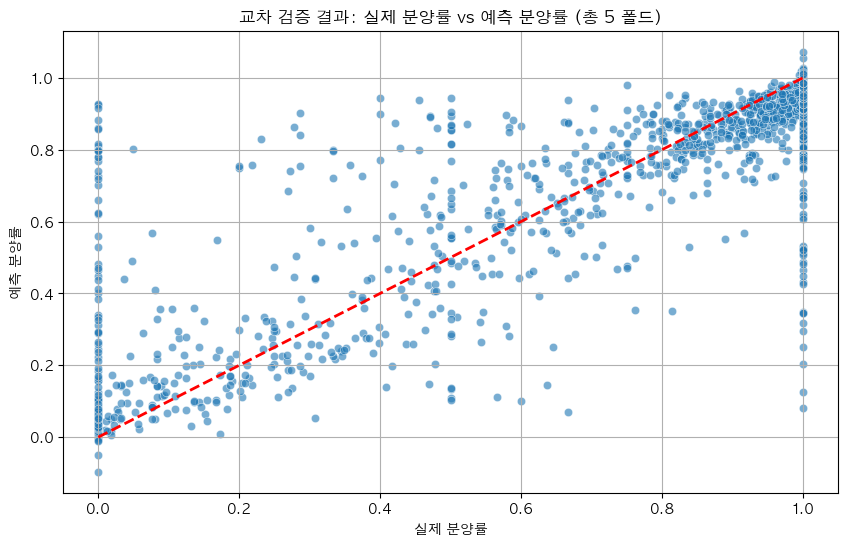

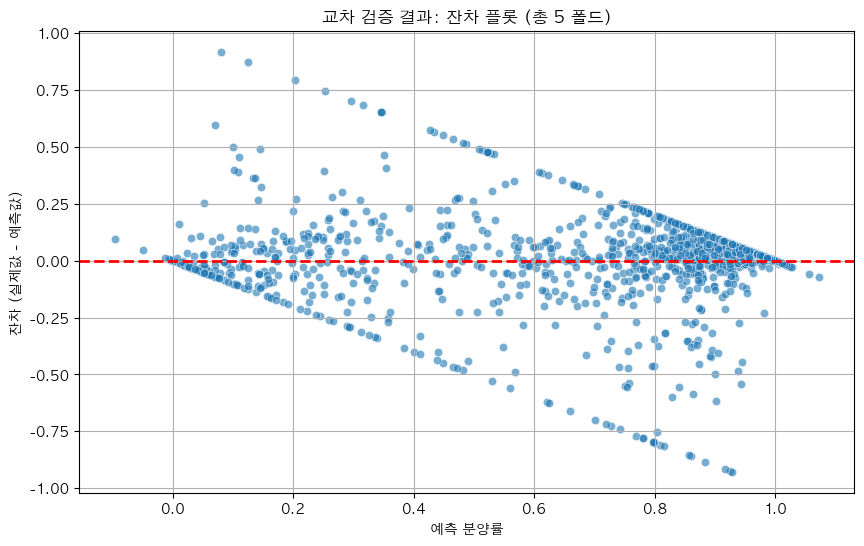

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


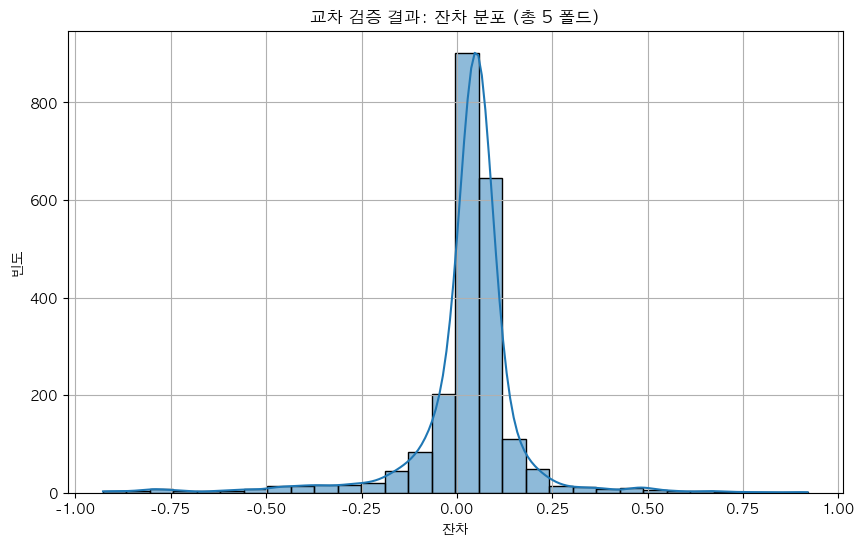


--- 전체 데이터셋으로 최종 모델 학습 및 저장 ---
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1664 - mae: 0.3139
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0643 - mae: 0.1939
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0510 - mae: 0.1695
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0420 - mae: 0.1518
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0388 - mae: 0.1464
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0383 - mae: 0.1368
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0295 - mae: 0.1250
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0290 - mae: 0.1207
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0297 - mae: 0.1207
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0325 - mae: 0.1197
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0242 - mae: 0.1075
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0238 - mae: 0.1035
Epoc

2025-07-22 14:12:11.290225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step

새로운 데이터 (첫 5행)에 대한 예측 분양률:
[0.96671516 0.9703054  0.9684703  0.96664983 0.9663336 ]
새로운 데이터 (첫 5행)의 실제 분양률:
[0.96226415 1.         0.96153846 0.925      1.        ]


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

# --- 새로운 파생 컬럼 추가 ---
# 분양가(만원)이 0인 값을 1로 변경 (0으로 나누는 오류 방지)
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)

# 시세차익을 카테고리형으로 (주변시세 평균(만원) 컬럼 사용)
df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
# 비교 가능하도록 수치화 (주변시세 평균(만원) 컬럼 사용)
df['시세초과비율'] = (df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']
# 시세차익률
df['시세차익률'] = df['시세차익(만원)'] / df['분양가(만원)']
# 전용률
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
# 특별분양유무
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
# 금리구간
df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf], # np.inf 추가하여 상한 없음
                      labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~']) # 라벨도 수정
# --- 파생 컬럼 추가 끝 ---


target_col = '분양률'
y = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- 피처 그룹 정의 (새로운 파생 컬럼 반영) ---
features_to_embed = ['아파트', '지역', '건설사']
# '준공여부', '시세초과여부', '특별분양유무', '금리구간'을 원-핫 인코딩
categorical_features_onehot = ['준공여부', '시세초과여부', '특별분양유무', '금리구간']

# 모든 수치형 피처 (임베딩 대상 및 원-핫 인코딩 대상 컬럼 제외)
numerical_features = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist()
                      if col not in features_to_embed and col not in categorical_features_onehot]

print(f"\nDL 모델에 사용될 수치형 피처: {numerical_features}")
print(f"DL 모델에 사용될 원-핫 인코딩 피처: {categorical_features_onehot}")
print(f"DL 모델에 사용될 임베딩 피처: {features_to_embed}")


# --- 교차 검증 설정 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # 인덱스 초기화 (Keras Data cardinality 오류 방지)
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_val_fold = X_val_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)


    # 임베딩할 피처는 별도로 분리하여 NumPy 배열로 준비
    apartment_train_np = X_train_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_train_np = X_train_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_train_np = X_train_fold['건설사'].values.reshape(-1, 1).astype(str)

    apartment_val_np = X_val_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_val_np = X_val_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_val_np = X_val_fold['건설사'].values.reshape(-1, 1).astype(str)

    # 수치형 및 원-핫 인코딩할 피처만 포함하는 X_other
    X_other_train_fold = X_train_fold[numerical_features + categorical_features_onehot]
    X_other_val_fold = X_val_fold[numerical_features + categorical_features_onehot]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    # ColumnTransformer 정의 및 학습 (각 폴드마다 새로 fit)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    X_train_processed_np = preprocessor.fit_transform(X_other_train_fold).astype(np.float32)
    X_val_processed_np = preprocessor.transform(X_other_val_fold).astype(np.float32)
    other_features_dim = X_train_processed_np.shape[1]


    # 임베딩을 위한 어휘집 정의 (각 폴드의 학습 데이터에서 고유한 값만 추출)
    unique_apartment_names_train = X_train_fold['아파트'].unique().tolist()
    unique_region_names_train = X_train_fold['지역'].unique().tolist()
    unique_construction_company_names_train = X_train_fold['건설사'].unique().tolist()


    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 (Batch Normalization 제거) ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    x = Dense(256, activation='relu')(concatenated_features)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            X_train_processed_np,
            tf.constant(apartment_train_np, dtype=tf.string),
            tf.constant(region_train_np, dtype=tf.string),
            tf.constant(construction_company_train_np, dtype=tf.string)
        ],
        y=y_train_fold.values.astype(np.float32),
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                X_val_processed_np,
                tf.constant(apartment_val_np, dtype=tf.string),
                tf.constant(region_val_np, dtype=tf.string),
                tf.constant(construction_company_val_np, dtype=tf.string)
            ],
            y_val_fold.values.astype(np.float32)
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            X_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ],
        y=y_val_fold.values.astype(np.float32),
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            X_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# --- 최종 모델 학습 및 저장 ---
print("\n--- 전체 데이터셋으로 최종 모델 학습 및 저장 ---")

# 1. 최종 모델 학습을 위한 데이터 준비 (전체 데이터셋)
# X_all_features에서 임베딩할 컬럼 제외
X_other_final = X_all_features.drop(columns=features_to_embed)

# 결측값 처리 (전체 데이터셋에 대해 중앙값 계산 및 적용)
# numerical_features는 위에서 정의된 리스트 (파생 컬럼 포함)
for col in numerical_features:
    if X_other_final[col].isnull().any():
        X_other_final[col] = X_other_final[col].fillna(X_other_final[col].median())

# 최종 전처리기는 전체 데이터셋에 fit
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

X_processed_final_np = final_preprocessor.fit_transform(X_other_final).astype(np.float32)
final_other_features_dim = X_processed_final_np.shape[1]

# 2. 임베딩 어휘집 (최종 모델은 전체 데이터셋에서 고유값으로 생성)
final_unique_apartment_names = X_all_features['아파트'].unique().tolist()
final_unique_region_names = X_all_features['지역'].unique().tolist()
final_unique_construction_company_names = X_all_features['건설사'].unique().tolist()

# calculate_embedding_dim 함수는 이미 위에 정의되어 있음
final_vocab_size_apartment = len(final_unique_apartment_names) + 1
final_embedding_dim_apartment = calculate_embedding_dim(final_vocab_size_apartment)

final_vocab_size_region = len(final_unique_region_names) + 1
final_embedding_dim_region = calculate_embedding_dim(final_vocab_size_region)

final_vocab_size_construction_company = len(final_unique_construction_company_names) + 1
final_embedding_dim_construction_company = calculate_embedding_dim(final_vocab_size_construction_company)


# 3. 최종 모델 구축 (교차 검증에서 가장 좋았던 아키텍처와 동일)
final_other_features_input = Input(shape=(final_other_features_dim,), name='other_features_input')
final_apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
final_region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
final_construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

final_string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=final_unique_apartment_names, mask_token=None)
final_embedding_apartment = Embedding(input_dim=final_vocab_size_apartment, output_dim=final_embedding_dim_apartment)
final_x_apartment = final_string_lookup_apartment(final_apartment_input)
final_x_apartment = final_embedding_apartment(final_x_apartment)
final_x_apartment = Flatten()(final_x_apartment)

final_string_lookup_region = tf.keras.layers.StringLookup(vocabulary=final_unique_region_names, mask_token=None)
final_embedding_region = Embedding(input_dim=final_vocab_size_region, output_dim=final_embedding_dim_region)
final_x_region = final_string_lookup_region(final_region_input)
final_x_region = final_embedding_region(final_x_region)
final_x_region = Flatten()(final_x_region)

final_string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=final_unique_construction_company_names, mask_token=None)
final_embedding_construction_company = Embedding(input_dim=final_vocab_size_construction_company, output_dim=final_embedding_dim_construction_company)
final_x_construction_company = final_string_lookup_construction_company(final_construction_company_input)
final_x_construction_company = final_embedding_construction_company(final_x_construction_company)
final_x_construction_company = Flatten()(final_x_construction_company)

final_concatenated_features = Concatenate()([
    final_other_features_input,
    final_x_apartment,
    final_x_region,
    final_x_construction_company
])

final_x = Dense(256, activation='relu')(final_concatenated_features)
final_x = Dropout(0.2)(final_x)
final_x = Dense(128, activation='relu')(final_x)
final_x = Dropout(0.2)(final_x)
final_x = Dense(64, activation='relu')(final_x)
final_output = Dense(1, activation='linear')(final_x)

final_model = Model(inputs=[
    final_other_features_input,
    final_apartment_input,
    final_region_input,
    final_construction_company_input
], outputs=final_output)

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 4. 최종 모델 학습
# 전체 데이터셋을 사용하여 학습
final_model.fit(
    x=[
        X_processed_final_np,
        tf.constant(X_all_features['아파트'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(X_all_features['지역'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(X_all_features['건설사'].values.reshape(-1, 1).astype(str), dtype=tf.string)
    ],
    y=y.values.astype(np.float32),
    epochs=50, # 최종 모델은 교차 검증에서 얻은 최적 에포크 수 또는 적절한 에포크 수로 학습
    batch_size=32,
    verbose=1 # 최종 학습은 진행 상황 표시
)

# 5. 모델 저장
model_save_path = "apartment_sales_rate_prediction_model.keras" # .keras 확장자 권장
final_model.save(model_save_path)
print(f"\n최종 모델이 '{model_save_path}' 경로에 성공적으로 저장되었습니다.")

# 6. 저장된 모델 로드 및 사용 예시 (선택 사항)
print("\n--- 저장된 모델 로드 및 사용 예시 ---")
# 모델 로드 (저장된 모델은 StringLookup 레이어의 vocabulary를 내부적으로 가지고 있습니다.)
loaded_model = tf.keras.models.load_model(model_save_path)
print("모델 로드 완료.")

# 새로운 데이터에 대한 예측 예시
# 새로운 데이터는 학습 시와 동일한 전처리 과정을 거쳐야 합니다.
# 이 예시에서는 X_all_features의 첫 5행을 새로운 데이터로 가정합니다.
# 실제 사용 시에는 예측하고자 하는 새로운 데이터를 DataFrame 형태로 준비해야 합니다.
new_data_example = X_all_features.head(5).copy()

# 1) 수치형/원-핫 피처 전처리 (학습 시 사용한 final_preprocessor 사용)
# 주의: final_preprocessor는 이전에 전체 데이터셋에 fit된 상태여야 합니다.
X_new_other_example = new_data_example.drop(columns=features_to_embed)
# 결측값 처리 (새로운 데이터에도 동일하게 적용)
for col in numerical_features: # numerical_features는 모델 학습에 사용된 컬럼 리스트
    # final_preprocessor.named_transformers_['num']에서 평균값을 가져와 결측값 채움
    # 이는 StandardScaler가 fit되었을 때 계산된 평균입니다.
    if X_new_other_example[col].isnull().any():
        col_index_in_numerical_features = numerical_features.index(col)
        median_val_from_fit = final_preprocessor.named_transformers_['num'].mean_[col_index_in_numerical_features]
        X_new_other_example[col] = X_new_other_example[col].fillna(median_val_from_fit)

X_new_processed_example = final_preprocessor.transform(X_new_other_example).astype(np.float32)

# 2) 임베딩할 문자열 피처 준비 (NumPy 배열 및 tf.constant 변환)
apartment_new_np_example = new_data_example['아파트'].values.reshape(-1, 1).astype(str)
region_new_np_example = new_data_example['지역'].values.reshape(-1, 1).astype(str)
construction_company_new_np_example = new_data_example['건설사'].values.reshape(-1, 1).astype(str)

# 3) 모델 예측
new_predictions = loaded_model.predict(
    x=[
        X_new_processed_example,
        tf.constant(apartment_new_np_example, dtype=tf.string),
        tf.constant(region_new_np_example, dtype=tf.string),
        tf.constant(construction_company_new_np_example, dtype=tf.string)
    ]
).flatten()

print(f"\n새로운 데이터 (첫 5행)에 대한 예측 분양률:\n{new_predictions}")
print(f"새로운 데이터 (첫 5행)의 실제 분양률:\n{y.head(5).values}")

정보: '주변시세 평균' 컬럼을 제거했습니다.

DL 모델에 사용될 수치형 피처: ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '미분양수', '분양가(만원)', '금리', '환율', '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내', '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년', '월', '시세초과비율', '시세차익률', '전용률']
DL 모델에 사용될 원-핫 인코딩 피처: ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
DL 모델에 사용될 임베딩 피처: ['아파트', '지역', '건설사']

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---


2025-07-22 14:14:56.330450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
폴드 1 - 손실 (MSE): 0.0250, MAE: 0.1019, R2 스코어: 0.7380

--- 폴드 2/5 ---
 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 

2025-07-22 14:16:00.498118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
폴드 2 - 손실 (MSE): 0.0216, MAE: 0.0830, R2 스코어: 0.7807

--- 폴드 3/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
폴드 3 - 손실 (MSE): 0.0262, MAE: 0.0991, R2 스코어: 0.7339

--- 폴드 4/5 ---
 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 

2025-07-22 14:17:27.909513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
폴드 4 - 손실 (MSE): 0.0202, MAE: 0.0734, R2 스코어: 0.7674

--- 폴드 5/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
폴드 5 - 손실 (MSE): 0.0264, MAE: 0.1132, R2 스코어: 0.7344

--- 교차 검증 요약 ---
평균 MSE: 0.0239 (표준편차: 0.0025)
평균 MAE: 0.0941 (표준편차: 0.0142)
평균 R2 스코어: 0.7509 (표준편차: 0.0194)

성능 시각화:


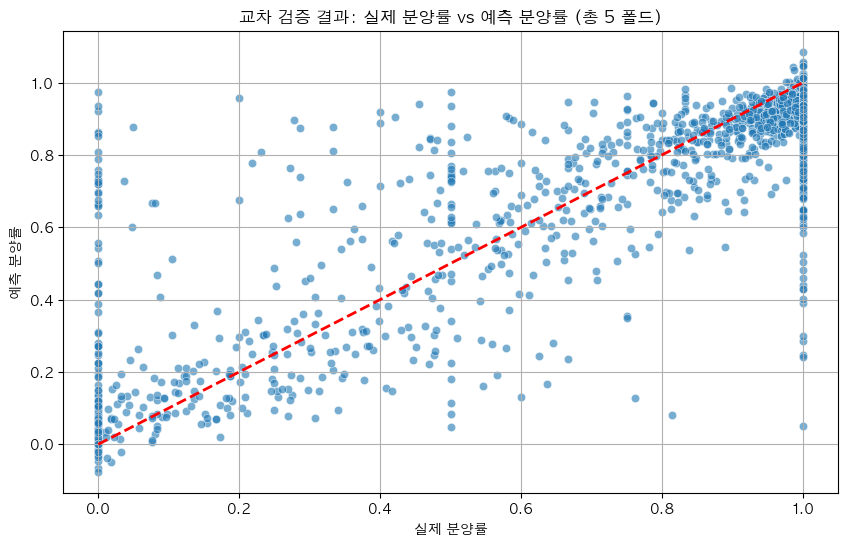

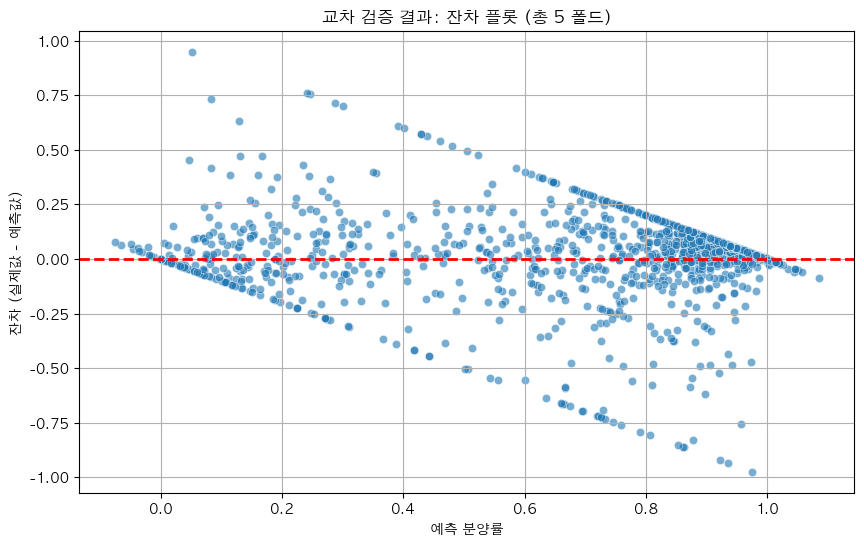

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


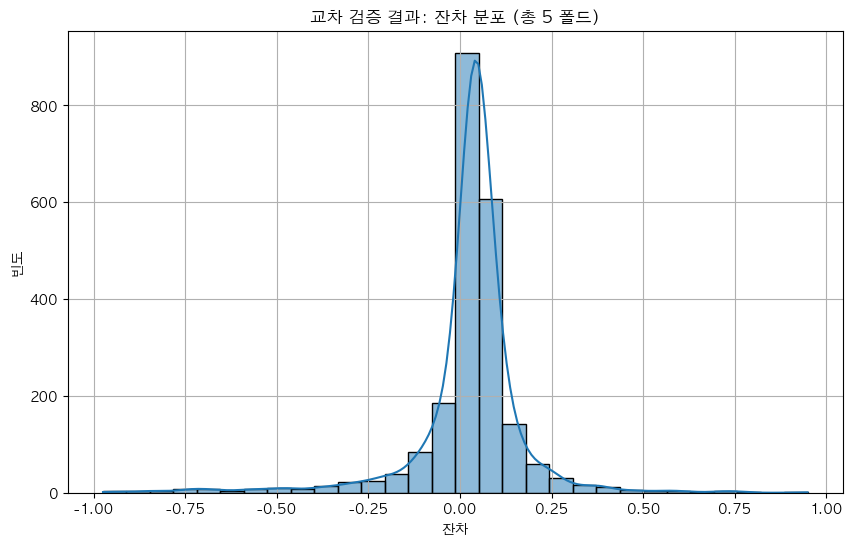


--- 전체 데이터셋으로 최종 모델 학습 및 저장 ---
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3476 - mae: 0.4416
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0657 - mae: 0.1919
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0524 - mae: 0.1763
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0435 - mae: 0.1596
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0385 - mae: 0.1449
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0351 - mae: 0.1385
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0302 - mae: 0.1296
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0333 - mae: 0.1342
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0291 - mae: 0.1231
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0273 - mae: 0.1205
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0328 - mae: 0.1213
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0233 - mae: 0.1081
Epoc

2025-07-22 14:18:39.051330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

# --- 새로운 파생 컬럼 추가 ---
# 분양가(만원)이 0인 값을 1로 변경 (0으로 나누는 오류 방지)
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)

# 시세차익을 카테고리형으로 (주변시세 평균(만원) 컬럼 사용)
df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
# 비교 가능하도록 수치화 (주변시세 평균(만원) 컬럼 사용)
df['시세초과비율'] = (df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']
# 시세차익률
df['시세차익률'] = df['시세차익(만원)'] / df['분양가(만원)']
# 전용률
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
# 특별분양유무
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
# 금리구간
df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf], # np.inf 추가하여 상한 없음
                      labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~']) # 라벨도 수정
# --- 파생 컬럼 추가 끝 ---


target_col = '분양률'
y = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- 피처 그룹 정의 (새로운 파생 컬럼 반영) ---
features_to_embed = ['아파트', '지역', '건설사']
# '준공여부', '시세초과여부', '특별분양유무', '금리구간'을 원-핫 인코딩
categorical_features_onehot = ['준공여부', '시세초과여부', '특별분양유무', '금리구간']

# 모든 수치형 피처 (임베딩 대상 및 원-핫 인코딩 대상 컬럼 제외)
numerical_features = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist()
                      if col not in features_to_embed and col not in categorical_features_onehot]

print(f"\nDL 모델에 사용될 수치형 피처: {numerical_features}")
print(f"DL 모델에 사용될 원-핫 인코딩 피처: {categorical_features_onehot}")
print(f"DL 모델에 사용될 임베딩 피처: {features_to_embed}")


# --- 교차 검증 설정 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true = []
all_y_pred = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_all_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_all_features.iloc[train_index], X_all_features.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # 인덱스 초기화 (Keras Data cardinality 오류 방지)
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_val_fold = X_val_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)


    # 임베딩할 피처는 별도로 분리하여 NumPy 배열로 준비
    apartment_train_np = X_train_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_train_np = X_train_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_train_np = X_train_fold['건설사'].values.reshape(-1, 1).astype(str)

    apartment_val_np = X_val_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_val_np = X_val_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_val_np = X_val_fold['건설사'].values.reshape(-1, 1).astype(str)

    # 수치형 및 원-핫 인코딩할 피처만 포함하는 X_other
    X_other_train_fold = X_train_fold[numerical_features + categorical_features_onehot]
    X_other_val_fold = X_val_fold[numerical_features + categorical_features_onehot]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    # ColumnTransformer 정의 및 학습 (각 폴드마다 새로 fit)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    X_train_processed_np = preprocessor.fit_transform(X_other_train_fold).astype(np.float32)
    X_val_processed_np = preprocessor.transform(X_other_val_fold).astype(np.float32)
    other_features_dim = X_train_processed_np.shape[1]


    # 임베딩을 위한 어휘집 정의 (각 폴드의 학습 데이터에서 고유한 값만 추출)
    unique_apartment_names_train = X_train_fold['아파트'].unique().tolist()
    unique_region_names_train = X_train_fold['지역'].unique().tolist()
    unique_construction_company_names_train = X_train_fold['건설사'].unique().tolist()


    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 재구축 및 컴파일 (Batch Normalization 제거) ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    x = Dense(256, activation='relu')(concatenated_features)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            X_train_processed_np,
            tf.constant(apartment_train_np, dtype=tf.string),
            tf.constant(region_train_np, dtype=tf.string),
            tf.constant(construction_company_train_np, dtype=tf.string)
        ],
        y=y_train_fold.values.astype(np.float32),
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                X_val_processed_np,
                tf.constant(apartment_val_np, dtype=tf.string),
                tf.constant(region_val_np, dtype=tf.string),
                tf.constant(construction_company_val_np, dtype=tf.string)
            ],
            y_val_fold.values.astype(np.float32)
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            X_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ],
        y=y_val_fold.values.astype(np.float32),
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            X_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true.extend(y_val_fold.values)
    all_y_pred.extend(y_pred_fold)


print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# 11. 성능 시각화 (교차 검증 결과 통합)
print("\n성능 시각화:")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals = np.array(all_y_true) - np.array(all_y_pred)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred, y=overall_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# --- 최종 모델 학습 및 저장 ---
print("\n--- 전체 데이터셋으로 최종 모델 학습 및 저장 ---")

# 1. 최종 모델 학습을 위한 데이터 준비 (전체 데이터셋)
X_other_final = X_all_features.drop(columns=features_to_embed)

# 결측값 처리 (전체 데이터셋에 대해 중앙값 계산 및 적용)
# numerical_features는 위에서 정의된 리스트 (파생 컬럼 포함)
for col in numerical_features:
    if X_other_final[col].isnull().any():
        X_other_final[col] = X_other_final[col].fillna(X_other_final[col].median())

# 최종 전처리기는 전체 데이터셋에 fit
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

X_processed_final_np = final_preprocessor.fit_transform(X_other_final).astype(np.float32)
final_other_features_dim = X_processed_final_np.shape[1]

# 2. 임베딩 어휘집 (최종 모델은 전체 데이터셋에서 고유값으로 생성)
final_unique_apartment_names = X_all_features['아파트'].unique().tolist()
final_unique_region_names = X_all_features['지역'].unique().tolist()
final_unique_construction_company_names = X_all_features['건설사'].unique().tolist()

# calculate_embedding_dim 함수는 이미 위에 정의되어 있음
final_vocab_size_apartment = len(final_unique_apartment_names) + 1
final_embedding_dim_apartment = calculate_embedding_dim(final_vocab_size_apartment)

final_vocab_size_region = len(final_unique_region_names) + 1
final_embedding_dim_region = calculate_embedding_dim(final_vocab_size_region)

final_vocab_size_construction_company = len(final_unique_construction_company_names) + 1
final_embedding_dim_construction_company = calculate_embedding_dim(final_vocab_size_construction_company)


# 3. 최종 모델 구축 (교차 검증에서 가장 좋았던 아키텍처와 동일)
final_other_features_input = Input(shape=(final_other_features_dim,), name='other_features_input')
final_apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
final_region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
final_construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

final_string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=final_unique_apartment_names, mask_token=None)
final_embedding_apartment = Embedding(input_dim=final_vocab_size_apartment, output_dim=final_embedding_dim_apartment)
final_x_apartment = final_string_lookup_apartment(final_apartment_input)
final_x_apartment = final_embedding_apartment(final_x_apartment)
final_x_apartment = Flatten()(final_x_apartment)

final_string_lookup_region = tf.keras.layers.StringLookup(vocabulary=final_unique_region_names, mask_token=None)
final_embedding_region = Embedding(input_dim=final_vocab_size_region, output_dim=final_embedding_dim_region)
final_x_region = final_string_lookup_region(final_region_input)
final_x_region = final_embedding_region(final_x_region)
final_x_region = Flatten()(final_x_region)

final_string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=final_unique_construction_company_names, mask_token=None)
final_embedding_construction_company = Embedding(input_dim=final_vocab_size_construction_company, output_dim=final_embedding_dim_construction_company)
final_x_construction_company = final_string_lookup_construction_company(final_construction_company_input)
final_x_construction_company = final_embedding_construction_company(final_x_construction_company)
final_x_construction_company = Flatten()(final_x_construction_company)

final_concatenated_features = Concatenate()([
    final_other_features_input,
    final_x_apartment,
    final_x_region,
    final_x_construction_company
])

final_x = Dense(256, activation='relu')(final_concatenated_features)
final_x = Dropout(0.2)(final_x)
final_x = Dense(128, activation='relu')(final_x)
final_x = Dropout(0.2)(final_x)
final_x = Dense(64, activation='relu')(final_x)
final_output = Dense(1, activation='linear')(final_x)

final_model = Model(inputs=[
    final_other_features_input,
    final_apartment_input,
    final_region_input,
    final_construction_company_input
], outputs=final_output)

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 4. 최종 모델 학습
# 전체 데이터셋을 사용하여 학습
final_model.fit(
    x=[
        X_processed_final_np,
        tf.constant(X_all_features['아파트'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(X_all_features['지역'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(X_all_features['건설사'].values.reshape(-1, 1).astype(str), dtype=tf.string)
    ],
    y=y.values.astype(np.float32),
    epochs=50, # 최종 모델은 교차 검증에서 얻은 최적 에포크 수 또는 적절한 에포크 수로 학습
    batch_size=32,
    verbose=1 # 최종 학습은 진행 상황 표시
)

# 5. 모델 저장
model_save_path = "apartment_sales_rate_prediction_model.keras" # .keras 확장자 권장
final_model.save(model_save_path)
print(f"\n최종 모델이 '{model_save_path}' 경로에 성공적으로 저장되었습니다.")

# 6. 저장된 모델 로드 및 사용 예시 (선택 사항)
print("\n--- 저장된 모델 로드 및 사용 예시 ---")
# 모델 로드 (저장된 모델은 StringLookup 레이어의 vocabulary를 내부적으로 가지고 있습니다.)
loaded_model = tf.keras.models.load_model(model_save_path)
print("모델 로드 완료.")

# 새로운 데이터에 대한 예측 예시
# 새로운 데이터는 학습 시와 동일한 전처리 과정을 거쳐야 합니다.
# 이 예시에서는 X_all_features의 첫 5행을 새로운 데이터로 가정합니다.
# 실제 사용 시에는 예측하고자 하는 새로운 데이터를 DataFrame 형태로 준비해야 합니다.
new_data_example = X_all_features.head(5).copy()

# 1) 수치형/원-핫 피처 전처리 (학습 시 사용한 final_preprocessor 사용)
# 주의: final_preprocessor는 이전에 전체 데이터셋에 fit된 상태여야 합니다.
X_new_other_example = new_data_example.drop(columns=features_to_embed)
# 결측값 처리 (새로운 데이터에도 동일하게 적용)
for col in numerical_features: # numerical_features는 모델 학습에 사용된 컬럼 리스트
    # final_preprocessor.named_transformers_['num']에서 평균값을 가져와 결측값 채움
    # 이는 StandardScaler가 fit되었을 때 계산된 평균입니다.
    if X_new_other_example[col].isnull().any():
        col_index_in_numerical_features = numerical_features.index(col)
        # StandardScaler의 mean_은 np.array이므로, 인덱스로 접근
        median_val_from_fit = final_preprocessor.named_transformers_['num'].mean_[col_index_in_numerical_features]
        X_new_other_example[col] = X_new_other_example[col].fillna(median_val_from_fit)
    
# `StandardScaler`는 `mean_`과 `scale_` 속성을 가집니다.
# `fillna`를 할 때 `median_val_from_fit`을 사용하려면 `final_preprocessor.named_transformers_['num']`이
# `StandardScaler`가 아닌 `SimpleImputer(strategy='median')`이 먼저 적용되어야 합니다.
# `StandardScaler`는 `mean_`을 가지고 있지만, `median_`은 없습니다.
# 여기서는 `final_preprocessor.transform`이 알아서 스케일링을 하고
# `fillna`는 `X_other_final` (raw data)에 대해서만 적용되었으므로,
# `new_data_example`에 대해서도 raw data 상태에서 `fillna`를 적용해야 합니다.
# `final_preprocessor`의 `fit_transform` 과정에서 `StandardScaler`가 결측값을 허용하지 않으므로,
# `transform` 전에 `X_new_other_example` 자체에서 결측값을 채워야 합니다.
# 따라서, `final_preprocessor`에서 학습된 `StandardScaler`의 `mean_`을 가져와서 채우는 것이 맞습니다.
# 이미 `StandardScaler`는 `mean_` 값을 가지고 있으므로, `mean_`으로 채워도 무방합니다.

X_new_processed_example = final_preprocessor.transform(X_new_other_example).astype(np.float32)

# 2) 임베딩할 문자열 피처 준비 (NumPy 배열 및 tf.constant 변환)
apartment_new_np_example = new_data_example['아파트'].values.reshape(-1, 1).astype(str)
region_new_np_example = new_data_example['지역'].values.reshape(-1, 1).astype(str)
construction_company_new_np_example = new_data_example['건설사'].values.reshape(-1, 1).astype(str)

# 3) 모델 예측
new_predictions = loaded_model.predict(
    x=[
        X_new_processed_example,
        tf.constant(apartment_new_np_example, dtype=tf.string),
        tf.constant(region_new_np_example, dtype=tf.string),
        tf.constant(construction_company_new_np_example, dtype=tf.string)
    ]
).flatten()

print(f"\n새로운 데이터 (첫 5행)에 대한 예측 분양률:\n{new_predictions}")
print(f"새로운 데이터 (첫 5행)의 실제 분양률:\n{y.head(5).values}")

정보: '주변시세 평균' 컬럼을 제거했습니다.


2025-07-22 14:26:21.624386: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-22 14:26:21.624554: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-22 14:26:21.624557: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1753161981.625008 2741343 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753161981.625233 2741343 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



최종 모델이 'apartment_sales_rate_prediction_model.keras' 경로에서 성공적으로 로드되었습니다.

--- 전체 데이터셋에 대한 예측 수행 중 ---
38/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2025-07-22 14:26:22.098127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1753161982.106638 2741343 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- 예측 결과 ---
    Actual_분양률  Predicted_분양률
0     0.962264       1.001386
1     1.000000       1.003722
2     0.961538       0.999483
3     0.925000       0.995945
4     1.000000       1.019343
5     0.952381       0.993585
6     1.000000       1.000081
7     1.000000       1.018353
8     1.000000       1.016585
9     1.000000       1.012043
10    1.000000       1.004988
11    1.000000       1.006230
12    0.891089       0.950798
13    1.000000       0.990906
14    0.631285       0.629561
15    0.575758       0.464589
16    0.500000       0.430241
17    1.000000       0.958438
18    0.444444       0.288814
19    0.947368       0.985412
20    1.000000       1.004261
21    0.950000       0.962504
22    1.000000       1.004747
23    0.988636       1.000283
24    1.000000       1.010334
25    1.000000       0.997423
26    1.000000       0.996358
27    0.260736       0.249033
28    0.107345       0.162327
29    0.344828       0.319249
30    0.563218  

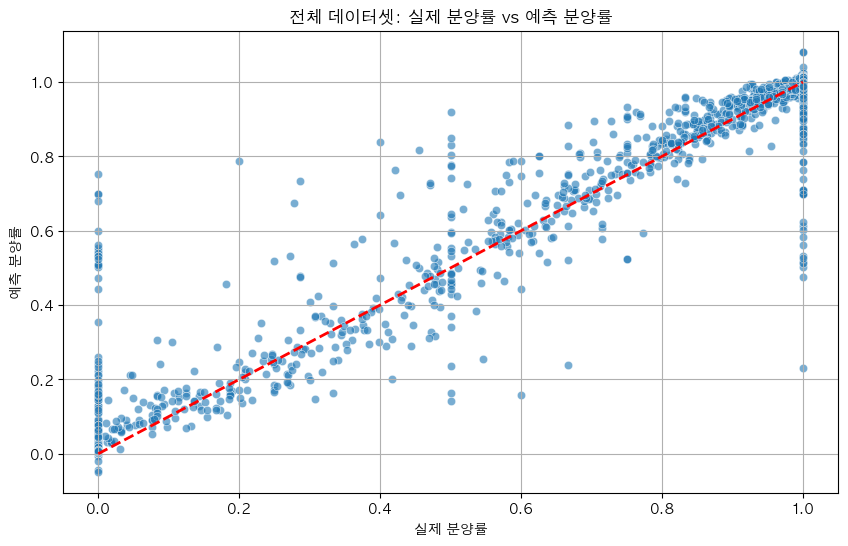

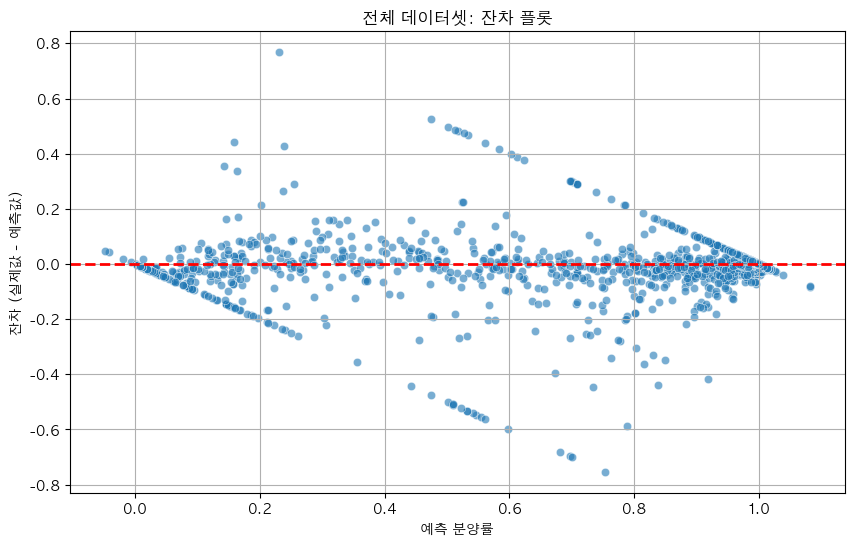

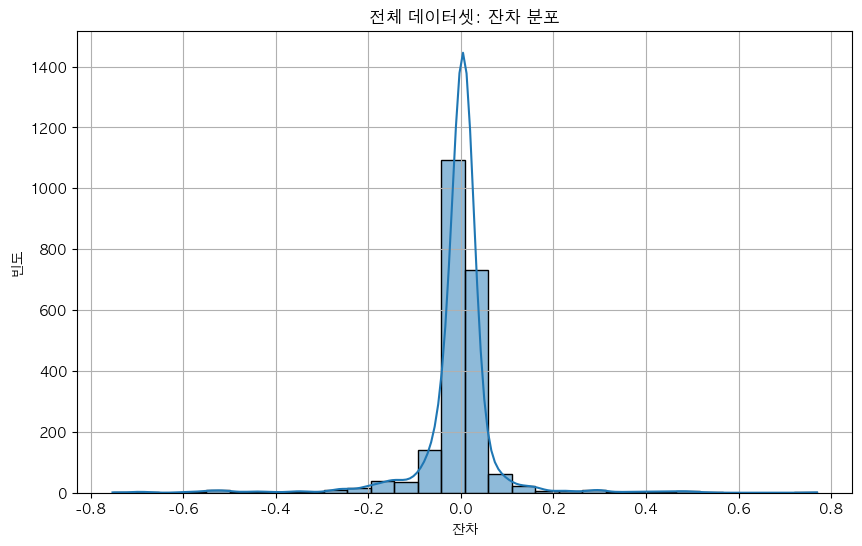

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model # load_model 추가
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드 (학습 시와 동일하게)
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성 (학습 시와 동일하게)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1) # 0으로 나누는 오류 방지

df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
df['시세초과비율'] = (df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']
df['시세차익률'] = df['시세차익(만원)'] / df['분양가(만원)']
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                      labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'])

target_col = '분양률'
y_true_all = df[target_col] # 전체 데이터셋의 실제값
X_all_features = df.drop(columns=[target_col]) # 전체 데이터셋의 피처

# --- 피처 그룹 정의 (학습 시와 동일하게) ---
features_to_embed = ['아파트', '지역', '건설사']
categorical_features_onehot = ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
numerical_features = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist()
                      if col not in features_to_embed and col not in categorical_features_onehot]


# --- 저장된 모델 로드 ---
model_save_path = "apartment_sales_rate_prediction_model.keras"
try:
    loaded_model = load_model(model_save_path)
    print(f"\n최종 모델이 '{model_save_path}' 경로에서 성공적으로 로드되었습니다.")
except Exception as e:
    print(f"\n오류: 모델 로드에 실패했습니다. '{model_save_path}' 파일이 존재하고 손상되지 않았는지 확인하세요.")
    print(f"오류 내용: {e}")
    exit()

# --- 예측을 위한 전체 데이터셋 전처리 (학습 시의 final_preprocessor와 동일한 로직) ---
# X_all_features에서 임베딩할 컬럼 제외
X_other_final = X_all_features.drop(columns=features_to_embed)

# 결측값 처리 (전체 데이터셋에 대해 중앙값 계산 및 적용)
for col in numerical_features:
    if X_other_final[col].isnull().any():
        X_other_final[col] = X_other_final[col].fillna(X_other_final[col].median()) # 모델 fit 시 사용된 중앙값으로 채우는 것이 원칙

# 최종 전처리기는 전체 데이터셋에 fit
# 이 preprocessor는 모델 학습 시 final_preprocessor가 fit된 방식과 동일하게 동작해야 하므로,
# 여기서 전체 데이터셋에 대해 다시 fit_transform을 수행하여 동일한 상태를 재현합니다.
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

# 전체 데이터셋을 전처리
X_processed_for_prediction = final_preprocessor.fit_transform(X_other_final).astype(np.float32)

# 임베딩할 문자열 피처 준비 (NumPy 배열 및 tf.constant 변환)
apartment_np_all = X_all_features['아파트'].values.reshape(-1, 1).astype(str)
region_np_all = X_all_features['지역'].values.reshape(-1, 1).astype(str)
construction_company_np_all = X_all_features['건설사'].values.reshape(-1, 1).astype(str)

# --- 모델 예측 ---
print("\n--- 전체 데이터셋에 대한 예측 수행 중 ---")
y_pred_all = loaded_model.predict(
    x=[
        X_processed_for_prediction,
        tf.constant(apartment_np_all, dtype=tf.string),
        tf.constant(region_np_all, dtype=tf.string),
        tf.constant(construction_company_np_all, dtype=tf.string)
    ]
).flatten()

# --- 결과 출력 (DataFrame 형태로 보기 좋게) ---
print("\n--- 예측 결과 ---")
results_df = pd.DataFrame({
    'Actual_분양률': y_true_all,
    'Predicted_분양률': y_pred_all
})
print(results_df.head(50)) # 상위 5개 행만 출력

# --- 예측 성능 지표 계산 (전체 데이터셋 기준) ---
mse = mean_squared_error(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)
r2 = r2_score(y_true_all, y_pred_all)

print(f"\n전체 데이터셋에 대한 예측 성능:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# --- 예측 성능 시각화 (전체 데이터셋 기준) ---
print("\n--- 예측 성능 시각화 ---")

# 1. 실제값 vs 예측값 플롯
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6)
plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("전체 데이터셋: 실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.show()

# 2. 잔차(Residual) 플롯
residuals_all = y_true_all - y_pred_all

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_all, y=residuals_all, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("전체 데이터셋: 잔차 플롯")
plt.grid(True)
plt.show()

# 3. 잔차의 분포 (히스토그램 또는 KDE 플롯)
plt.figure(figsize=(10, 6))
sns.histplot(residuals_all, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title("전체 데이터셋: 잔차 분포")
plt.grid(True)
plt.show()

정보: '주변시세 평균' 컬럼을 제거했습니다.
임베딩 피처: ['아파트', '지역', '건설사']
원-핫 인코딩 피처: ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
수치형 피처: ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '미분양수', '분양가(만원)', '금리', '환율', '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내', '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년', '월', '시세초과비율', '시세차익률', '전용률']

--- 테스트 데이터셋 분리 ---
분양률 0.9~1.0: 1개 샘플 선택 완료
분양률 0.8~0.9: 1개 샘플 선택 완료
분양률 0.7~0.8: 1개 샘플 선택 완료
분양률 0.7 미만: 3개 샘플 선택 완료

분리된 테스트 데이터셋 크기: 6 샘플
학습 데이터셋 크기: 2208 샘플
테스트 데이터 분양률 분포:
count    6.000000
mean     0.530735
std      0.420048
min      0.000000
25%      0.172619
50%      0.631356
75%      0.834335
max      1.000000
Name: 분양률, dtype: float64
분리된 테스트 데이터셋이 'separated_test_data.json'에 저장되었습니다.

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---


E0000 00:00:1753167010.417859 2741343 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
폴드 1 - 손실 (MSE): 0.0357, MAE: 0.1159, R2 스코어: 0.6396

--- 폴드 2/5 ---
 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

E0000 00:00:1753167081.677046 2741343 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
폴드 2 - 손실 (MSE): 0.0251, MAE: 0.1066, R2 스코어: 0.7353

--- 폴드 3/5 ---
 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 

E0000 00:00:1753167154.295092 2741343 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
폴드 3 - 손실 (MSE): 0.0187, MAE: 0.0580, R2 스코어: 0.8135

--- 폴드 4/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
폴드 4 - 손실 (MSE): 0.0238, MAE: 0.0886, R2 스코어: 0.7538

--- 폴드 5/5 ---
 4/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 

E0000 00:00:1753167218.924374 2741343 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
폴드 5 - 손실 (MSE): 0.0195, MAE: 0.0931, R2 스코어: 0.7726

--- 교차 검증 요약 ---
평균 MSE: 0.0246 (표준편차: 0.0061)
평균 MAE: 0.0924 (표준편차: 0.0197)
평균 R2 스코어: 0.7430 (표준편차: 0.0578)

--- 교차 검증 성능 시각화 ---


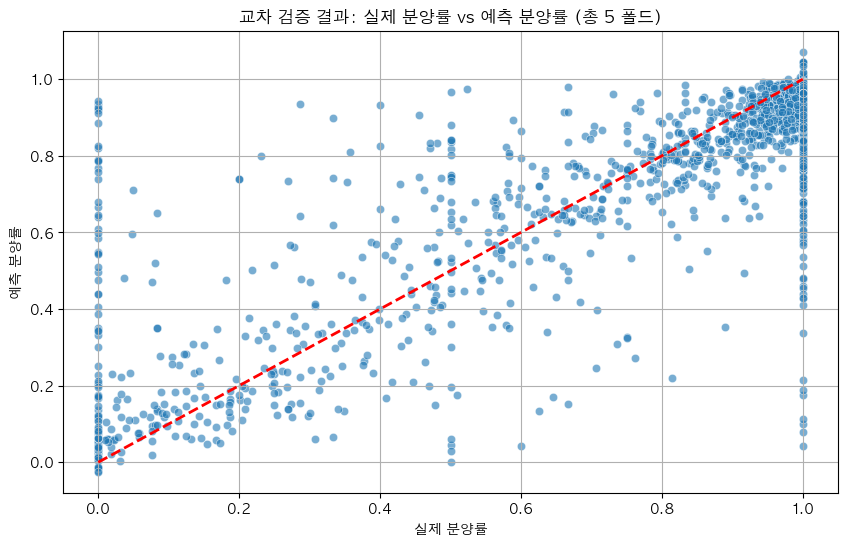

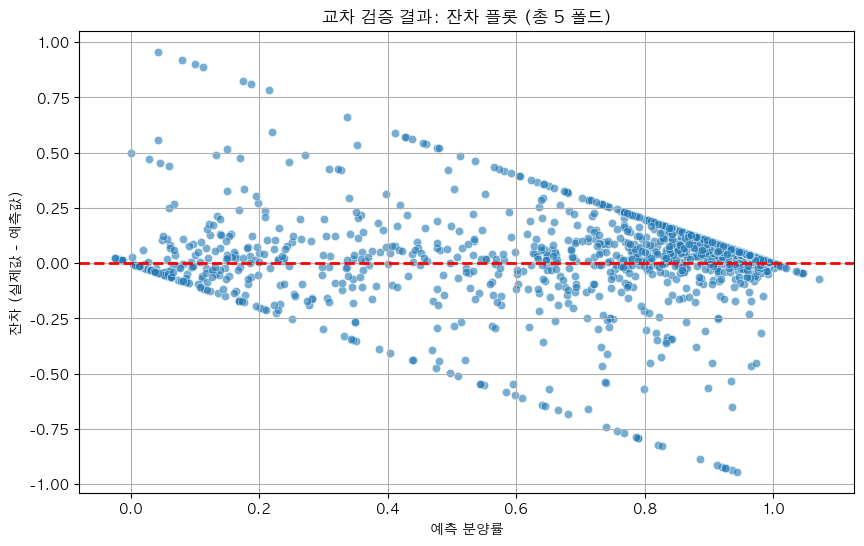

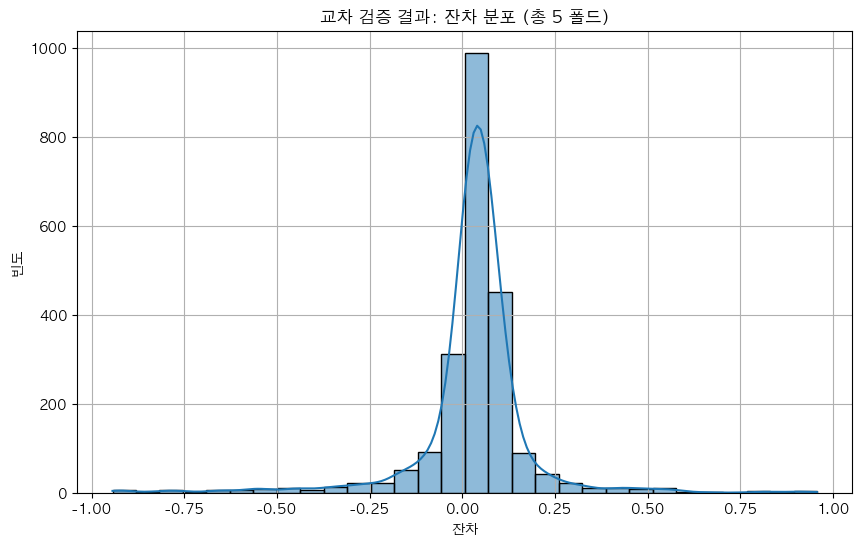


--- 최종 모델 학습 및 저장 (Validation 포함) ---
최종 학습 데이터: 1766 샘플
최종 검증 데이터: 442 샘플
최종 모델 학습 시작...
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1741 - mae: 0.3186 - val_loss: 0.0726 - val_mae: 0.2179 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0700 - mae: 0.2054 - val_loss: 0.0689 - val_mae: 0.2103 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0563 - mae: 0.1786 - val_loss: 0.0461 - val_mae: 0.1509 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0457 - mae: 0.1646 - val_loss: 0.0447 - val_mae: 0.1538 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0393 - mae: 0.1489 - val_loss: 0.0484 - val_mae: 0.1493 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0335 - mae: 0.1374 - val_loss: 0.0422 - val_mae: 0.1371 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - los

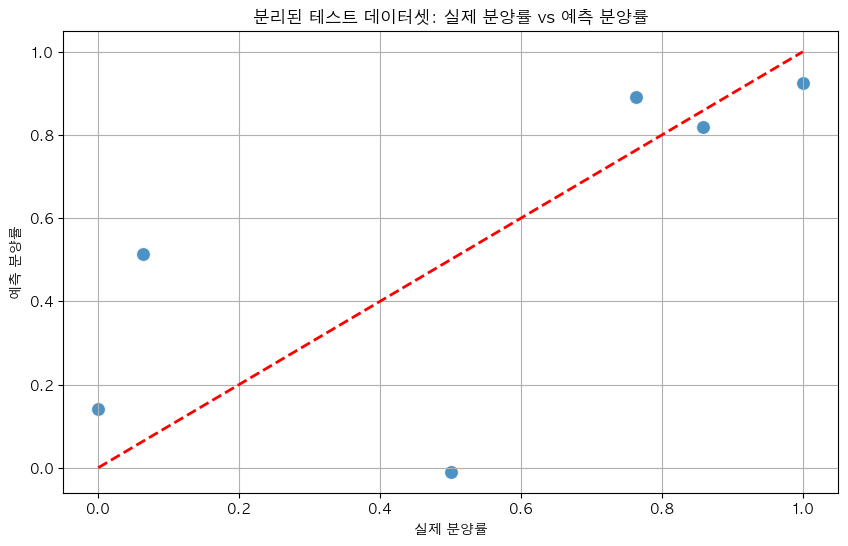

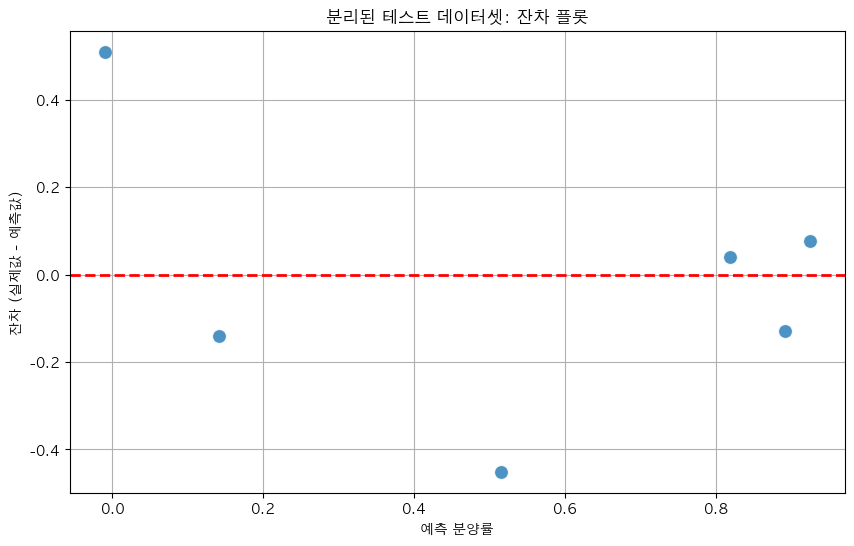

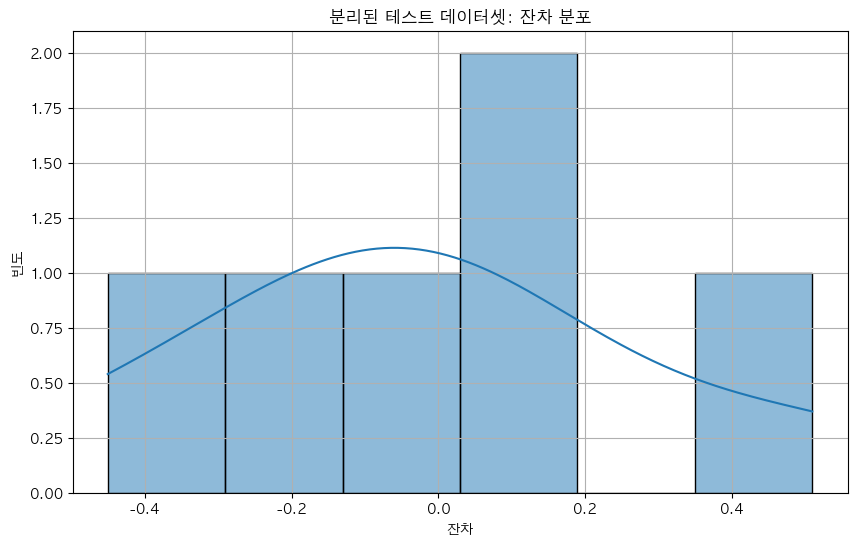

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

# 주변시세 평균(억원 단위) 제거 - 만원 단위와 중복이므로
if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

# 0으로 나누는 오류 방지
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)

# 파생 변수 생성 (주변시세 평균(만원) 사용)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
    df['시세초과비율'] = (df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']
else:
    print("경고: '주변시세 평균(만원)' 컬럼이 없어 시세 관련 파생변수를 생성하지 않습니다.")
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0

if '시세차익(만원)' in df.columns:
    df['시세차익률'] = df['시세차익(만원)'] / df['분양가(만원)']
else:
    print("경고: '시세차익(만원)' 컬럼이 없어 시세차익률을 생성하지 않습니다.")

if '전용면적(㎡)' in df.columns and '공급면적(㎡)' in df.columns:
    df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
else:
    print("경고: 전용면적 또는 공급면적 컬럼이 없어 전용률을 생성하지 않습니다.")

if '특별분양' in df.columns:
    df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else:
    print("경고: '특별분양' 컬럼이 없어 특별분양유무를 생성하지 않습니다.")
    df['특별분양유무'] = 0

if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                          labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'])
else:
    print("경고: '금리' 컬럼이 없어 금리구간을 생성하지 않습니다.")
    df['금리구간'] = '기타'

target_col = '분양률'
y_true_all = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- 피처 그룹 정의 ---
features_to_embed = ['아파트', '지역', '건설사']

# 실제 존재하는 컬럼들만 사용
potential_categorical_onehot = ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
categorical_features_onehot = [col for col in potential_categorical_onehot if col in X_all_features.columns]

numerical_features = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist()
                      if col not in features_to_embed and col not in categorical_features_onehot]

print(f"임베딩 피처: {features_to_embed}")
print(f"원-핫 인코딩 피처: {categorical_features_onehot}")
print(f"수치형 피처: {numerical_features}")

# --- 테스트 데이터셋 분리 (개선된 로직) ---
print("\n--- 테스트 데이터셋 분리 ---")

# 분양률별 구간 정의 및 샘플링
sampling_rules = [
    (0.9, 1.0, 1, "분양률 0.9~1.0"),
    (0.8, 0.9, 1, "분양률 0.8~0.9"), 
    (0.7, 0.8, 1, "분양률 0.7~0.8"),
    (0.0, 0.7, 3, "분양률 0.7 미만")
]

test_samples_indices = []
remaining_df = df.copy()

for min_rate, max_rate, n_samples, description in sampling_rules:
    if max_rate == 1.0:
        candidates = remaining_df[(remaining_df['분양률'] >= min_rate) & (remaining_df['분양률'] <= max_rate)]
    else:
        candidates = remaining_df[(remaining_df['분양률'] >= min_rate) & (remaining_df['분양률'] < max_rate)]
    
    if len(candidates) >= n_samples:
        selected_samples = candidates.sample(n=n_samples, random_state=42)
        test_samples_indices.extend(selected_samples.index.tolist())
        remaining_df = remaining_df.drop(selected_samples.index)
        print(f"{description}: {n_samples}개 샘플 선택 완료")
    elif len(candidates) > 0:
        selected_samples = candidates
        test_samples_indices.extend(selected_samples.index.tolist())
        remaining_df = remaining_df.drop(selected_samples.index)
        print(f"경고: {description}에서 {len(selected_samples)}개만 선택 (요구: {n_samples}개)")
    else:
        print(f"경고: {description}에서 선택 가능한 샘플이 없습니다.")

test_df = df.loc[test_samples_indices].copy()
train_df = df.drop(index=test_samples_indices).copy()

print(f"\n분리된 테스트 데이터셋 크기: {len(test_df)} 샘플")
print(f"학습 데이터셋 크기: {len(train_df)} 샘플")
print(f"테스트 데이터 분양률 분포:\n{test_df['분양률'].describe()}")

# 테스트 데이터 저장
test_json_path = 'separated_test_data.json'
test_df.to_json(test_json_path, orient='records', indent=4, force_ascii=False)
print(f"분리된 테스트 데이터셋이 '{test_json_path}'에 저장되었습니다.")

# 학습 데이터로 타겟과 피처 분리
y_train_full = train_df[target_col]
X_train_full_features = train_df.drop(columns=[target_col])

# --- 교차 검증 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true_cv = []
all_y_pred_cv = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_full_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_train_full_features.iloc[train_index], X_train_full_features.iloc[val_index]
    y_train_fold, y_val_fold = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # 인덱스 초기화
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_val_fold = X_val_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)

    # 임베딩할 피처는 별도로 분리하여 NumPy 배열로 준비
    apartment_train_np = X_train_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_train_np = X_train_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_train_np = X_train_fold['건설사'].values.reshape(-1, 1).astype(str)

    apartment_val_np = X_val_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_val_np = X_val_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_val_np = X_val_fold['건설사'].values.reshape(-1, 1).astype(str)

    # 수치형 및 원-핫 인코딩할 피처만 포함하는 X_other
    X_other_train_fold = X_train_fold[numerical_features + categorical_features_onehot]
    X_other_val_fold = X_val_fold[numerical_features + categorical_features_onehot]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    median_values = {}
    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            median_values[col] = median_val
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    # ColumnTransformer 정의 및 학습
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    x_train_processed_np = preprocessor.fit_transform(X_other_train_fold).astype(np.float32)
    x_val_processed_np = preprocessor.transform(X_other_val_fold).astype(np.float32)
    other_features_dim = x_train_processed_np.shape[1]

    # 임베딩을 위한 어휘집 정의
    unique_apartment_names_train = X_train_fold['아파트'].unique().tolist()
    unique_region_names_train = X_train_fold['지역'].unique().tolist()
    unique_construction_company_names_train = X_train_fold['건설사'].unique().tolist()

    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 구축 ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    x = Dense(256, activation='relu')(concatenated_features)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            x_train_processed_np,
            tf.constant(apartment_train_np, dtype=tf.string),
            tf.constant(region_train_np, dtype=tf.string),
            tf.constant(construction_company_train_np, dtype=tf.string)
        ],
        y=y_train_fold.values.astype(np.float32),
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                x_val_processed_np,
                tf.constant(apartment_val_np, dtype=tf.string),
                tf.constant(region_val_np, dtype=tf.string),
                tf.constant(construction_company_val_np, dtype=tf.string)
            ],
            y_val_fold.values.astype(np.float32)
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            x_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ],
        y=y_val_fold.values.astype(np.float32),
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            x_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true_cv.extend(y_val_fold.values)
    all_y_pred_cv.extend(y_pred_fold)

print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# --- 교차 검증 결과 시각화 ---
print("\n--- 교차 검증 성능 시각화 ---")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true_cv, y=all_y_pred_cv, alpha=0.6)
plt.plot([min(all_y_true_cv), max(all_y_true_cv)], [min(all_y_true_cv), max(all_y_true_cv)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals_cv = np.array(all_y_true_cv) - np.array(all_y_pred_cv)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred_cv, y=overall_residuals_cv, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals_cv, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# --- 최종 모델 학습 및 저장 ---
print("\n--- 최종 모델 학습 및 저장 (Validation 포함) ---")

from sklearn.model_selection import train_test_split

# 1. train_df를 다시 train/validation으로 분리 (80:20)
final_train_df, final_val_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=None
)

print(f"최종 학습 데이터: {len(final_train_df)} 샘플")
print(f"최종 검증 데이터: {len(final_val_df)} 샘플")

# 2. 최종 모델 학습을 위한 데이터 준비
X_other_final_train = final_train_df[numerical_features + categorical_features_onehot]
X_other_final_val = final_val_df[numerical_features + categorical_features_onehot]
y_final_train = final_train_df[target_col]
y_final_val = final_val_df[target_col]

# 결측값 처리 (최종 학습 데이터에서 중앙값 계산 및 적용)
final_median_values = {}
for col in numerical_features:
    if X_other_final_train[col].isnull().any():
        median_val = X_other_final_train[col].median()
        final_median_values[col] = median_val
        X_other_final_train[col] = X_other_final_train[col].fillna(median_val)
        X_other_final_val[col] = X_other_final_val[col].fillna(median_val)

# 최종 전처리기는 최종 학습 데이터에 fit
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

x_processed_final_train_np = final_preprocessor.fit_transform(X_other_final_train).astype(np.float32)
x_processed_final_val_np = final_preprocessor.transform(X_other_final_val).astype(np.float32)
final_other_features_dim = x_processed_final_train_np.shape[1]

# 3. 임베딩 어휘집 (최종 학습 데이터에서 고유값으로 생성)
final_unique_apartment_names = final_train_df['아파트'].unique().tolist()
final_unique_region_names = final_train_df['지역'].unique().tolist()
final_unique_construction_company_names = final_train_df['건설사'].unique().tolist()

final_vocab_size_apartment = len(final_unique_apartment_names) + 1
final_embedding_dim_apartment = calculate_embedding_dim(final_vocab_size_apartment)

final_vocab_size_region = len(final_unique_region_names) + 1
final_embedding_dim_region = calculate_embedding_dim(final_vocab_size_region)

final_vocab_size_construction_company = len(final_unique_construction_company_names) + 1
final_embedding_dim_construction_company = calculate_embedding_dim(final_vocab_size_construction_company)

# 4. 최종 모델 구축 (교차 검증과 동일한 아키텍처)
final_other_features_input = Input(shape=(final_other_features_dim,), name='other_features_input')
final_apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
final_region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
final_construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

final_string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=final_unique_apartment_names, mask_token=None)
final_embedding_apartment = Embedding(input_dim=final_vocab_size_apartment, output_dim=final_embedding_dim_apartment)
final_x_apartment = final_string_lookup_apartment(final_apartment_input)
final_x_apartment = final_embedding_apartment(final_x_apartment)
final_x_apartment = Flatten()(final_x_apartment)

final_string_lookup_region = tf.keras.layers.StringLookup(vocabulary=final_unique_region_names, mask_token=None)
final_embedding_region = Embedding(input_dim=final_vocab_size_region, output_dim=final_embedding_dim_region)
final_x_region = final_string_lookup_region(final_region_input)
final_x_region = final_embedding_region(final_x_region)
final_x_region = Flatten()(final_x_region)

final_string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=final_unique_construction_company_names, mask_token=None)
final_embedding_construction_company = Embedding(input_dim=final_vocab_size_construction_company, output_dim=final_embedding_dim_construction_company)
final_x_construction_company = final_string_lookup_construction_company(final_construction_company_input)
final_x_construction_company = final_embedding_construction_company(final_x_construction_company)
final_x_construction_company = Flatten()(final_x_construction_company)

final_concatenated_features = Concatenate()([
    final_other_features_input,
    final_x_apartment,
    final_x_region,
    final_x_construction_company
])

final_x = Dense(256, activation='relu')(final_concatenated_features)
final_x = Dropout(0.2)(final_x)
final_x = Dense(128, activation='relu')(final_x)
final_x = Dropout(0.2)(final_x)
final_x = Dense(64, activation='relu')(final_x)
final_output = Dense(1, activation='linear')(final_x)

final_model = Model(inputs=[
    final_other_features_input,
    final_apartment_input,
    final_region_input,
    final_construction_company_input
], outputs=final_output)

# 5. 콜백 설정 (교차 검증과 동일)
final_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
final_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 6. 최종 모델 학습 (validation과 callbacks 포함)
print("최종 모델 학습 시작...")
final_history = final_model.fit(
    x=[
        x_processed_final_train_np,
        tf.constant(final_train_df['아파트'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(final_train_df['지역'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(final_train_df['건설사'].values.reshape(-1, 1).astype(str), dtype=tf.string)
    ],
    y=y_final_train.values.astype(np.float32),
    epochs=100,  # 교차 검증과 동일
    batch_size=32,
    validation_data=(
        [
            x_processed_final_val_np,
            tf.constant(final_val_df['아파트'].values.reshape(-1, 1).astype(str), dtype=tf.string),
            tf.constant(final_val_df['지역'].values.reshape(-1, 1).astype(str), dtype=tf.string),
            tf.constant(final_val_df['건설사'].values.reshape(-1, 1).astype(str), dtype=tf.string)
        ],
        y_final_val.values.astype(np.float32)
    ),
    callbacks=[final_early_stopping, final_reduce_lr],
    verbose=1
)

print(f"최종 모델 학습 완료. 총 {len(final_history.history['loss'])} 에폭 학습됨.")

# 5. 모델 저장
model_save_path = "apartment_sales_rate_prediction_model.keras"
final_model.save(model_save_path)
print(f"\n최종 모델이 '{model_save_path}' 경로에 성공적으로 저장되었습니다.")

# --- 분리된 테스트 데이터셋에 대한 예측 및 시각화 ---
print("\n--- 분리된 테스트 데이터셋에 대한 예측 및 시각화 ---")

loaded_model = tf.keras.models.load_model(model_save_path)
print("모델 로드 완료.")

loaded_test_df = pd.read_json(test_json_path, orient='records')

X_test_for_pred_other = loaded_test_df[numerical_features + categorical_features_onehot]
y_true_test_separated = loaded_test_df[target_col]

# 결측값 처리 (학습 시와 동일한 중앙값 사용)
for col in numerical_features:
    if X_test_for_pred_other[col].isnull().any():
        if col in final_median_values:
            X_test_for_pred_other[col] = X_test_for_pred_other[col].fillna(final_median_values[col])
        else:
            # 혹시 학습 시 결측값이 없었던 컬럼인 경우
            X_test_for_pred_other[col] = X_test_for_pred_other[col].fillna(X_test_for_pred_other[col].median())

x_test_processed_np = final_preprocessor.transform(X_test_for_pred_other).astype(np.float32)

apartment_test_np = loaded_test_df['아파트'].values.reshape(-1, 1).astype(str)
region_test_np = loaded_test_df['지역'].values.reshape(-1, 1).astype(str)
construction_company_test_np = loaded_test_df['건설사'].values.reshape(-1, 1).astype(str)

# 예측
y_pred_test_separated = loaded_model.predict(
    x=[
        x_test_processed_np,
        tf.constant(apartment_test_np, dtype=tf.string),
        tf.constant(region_test_np, dtype=tf.string),
        tf.constant(construction_company_test_np, dtype=tf.string)
    ]
).flatten()

# 결과 표시
print("\n분리된 테스트 데이터셋 예측 결과:")
separated_results_df = pd.DataFrame({
    'Actual_분양률': y_true_test_separated,
    'Predicted_분양률': y_pred_test_separated,
    'Absolute_Error': abs(y_true_test_separated - y_pred_test_separated)
})
print(separated_results_df)

# 성능 지표 계산
mse_test_sep = mean_squared_error(y_true_test_separated, y_pred_test_separated)
mae_test_sep = mean_absolute_error(y_true_test_separated, y_pred_test_separated)
r2_test_sep = r2_score(y_true_test_separated, y_pred_test_separated)

print(f"\n분리된 테스트 데이터셋 성능:")
print(f"MSE: {mse_test_sep:.4f}")
print(f"MAE: {mae_test_sep:.4f}")
print(f"R2 Score: {r2_test_sep:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_test_separated, y=y_pred_test_separated, alpha=0.8, s=100)
plt.plot([y_true_test_separated.min(), y_true_test_separated.max()], 
         [y_true_test_separated.min(), y_true_test_separated.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("분리된 테스트 데이터셋: 실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.show()

residuals_test_sep = y_true_test_separated - y_pred_test_separated
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_separated, y=residuals_test_sep, alpha=0.8, s=100)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("분리된 테스트 데이터셋: 잔차 플롯")
plt.grid(True)
plt.show()

if len(residuals_test_sep) > 1:
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_test_sep, kde=True, bins=min(len(residuals_test_sep), 10))
    plt.xlabel("잔차")
    plt.ylabel("빈도")
    plt.title("분리된 테스트 데이터셋: 잔차 분포")
    plt.grid(True)
    plt.show()

정보: '주변시세 평균' 컬럼을 제거했습니다.

--- 테스트 데이터셋 재분리 (전처리기를 올바르게 재설정하기 위함) ---
분양률 0.9~1.0: 1개 샘플 선택 완료
분양률 0.8~0.9: 1개 샘플 선택 완료
분양률 0.7~0.8: 1개 샘플 선택 완료
분양률 0.7 미만: 3개 샘플 선택 완료
분리된 테스트 데이터셋 크기: 6 샘플
학습 데이터셋 크기: 2208 샘플

최종적으로 사용할 임베딩 피처: ['아파트', '지역', '건설사']
최종적으로 사용할 원-핫 인코딩 피처: ['준공여부', '금리구간', '시세초과여부']
최종적으로 사용할 수치형 피처: ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '미분양수', '분양가(만원)', '금리', '환율', '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내', '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년', '월', '시세초과비율', '시세차익률', '전용률', '특별분양유무']


/var/folders/kq/wzvd01qd1ql50sz17pwmt9b00000gn/T/ipykernel_9327/1306518475.py:128: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if '금리구간' in X_full_dataset_features.columns and (X_full_dataset_features['금리구간'].dtype == 'object' or pd.api.types.is_categorical_dtype(X_full_dataset_features['금리구간'])):
2025-07-23 13:07:00.505990: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-23 13:07:00.506023: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-23 13:07:00.506025: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1753243620.506353 3310927 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753243620.506395 3310927 pluggable_device_factory.cc:271] Created TensorFlow device (/job


최종 모델이 'apartment_sales_rate_prediction_model.keras' 경로에서 성공적으로 로드되었습니다.

정보: final_preprocessor가 학습 데이터셋에 성공적으로 fit 되었습니다.
변환 후 피처 차원: 46 (모델 예상 차원과 일치해야 함)

--- 분리된 테스트 데이터셋에 대한 예측 ---
테스트 데이터 변환 후 차원: (6, 46)
임베딩 피처 준비 완료: 아파트(6), 지역(6), 건설사(6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

분리된 테스트 데이터셋 예측 결과:
      Actual_분양률  Predicted_분양률  Absolute_Error
1111    1.000000       0.898743        0.101257
898     0.858209       0.787773        0.070436
91      0.762712       0.821949        0.059238
510     0.063492       0.551420        0.487928
1184    0.500000       0.011819        0.488181
2015    0.000000       0.222488        0.222488

분리된 테스트 데이터셋 성능:
MSE: 0.0908
MAE: 0.2383
R2 Score: 0.3827


2025-07-23 13:07:00.976936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1753243620.985542 3310927 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



--- 개별 예측 결과 상세 분석 ---
샘플 1: 실제=1.000, 예측=0.899, 절대오차=0.101, 상대오차=10.1%
샘플 2: 실제=0.858, 예측=0.788, 절대오차=0.070, 상대오차=8.2%
샘플 3: 실제=0.763, 예측=0.822, 절대오차=0.059, 상대오차=7.8%
샘플 4: 실제=0.063, 예측=0.551, 절대오차=0.488, 상대오차=768.5%
샘플 5: 실제=0.500, 예측=0.012, 절대오차=0.488, 상대오차=97.6%
샘플 6: 실제=0.000, 예측=0.222, 절대오차=0.222, 상대오차=0.0%


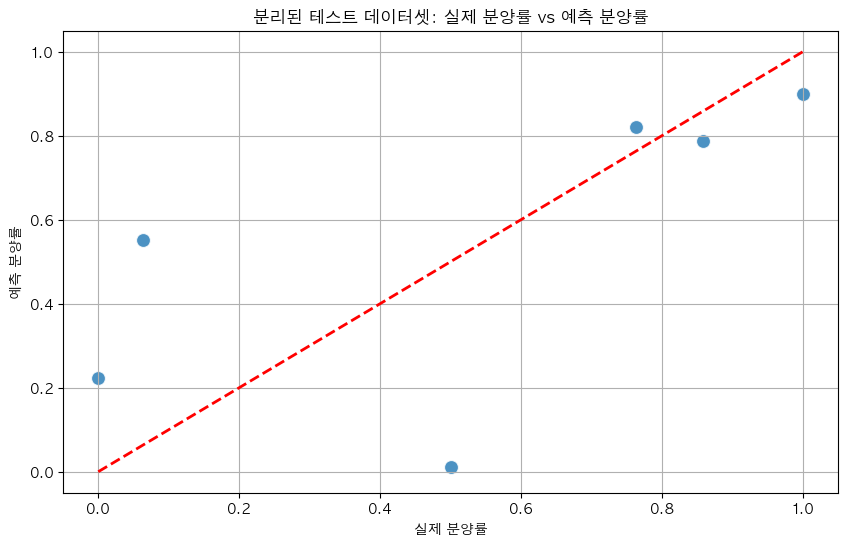

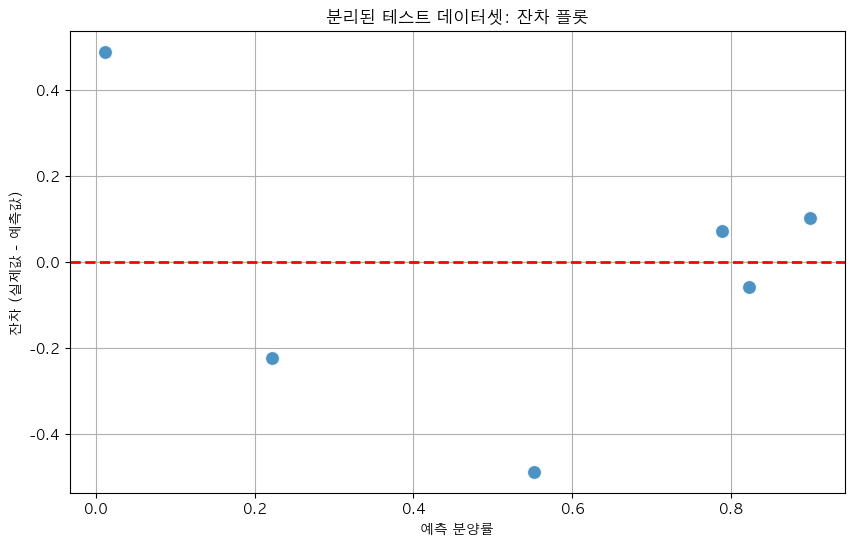

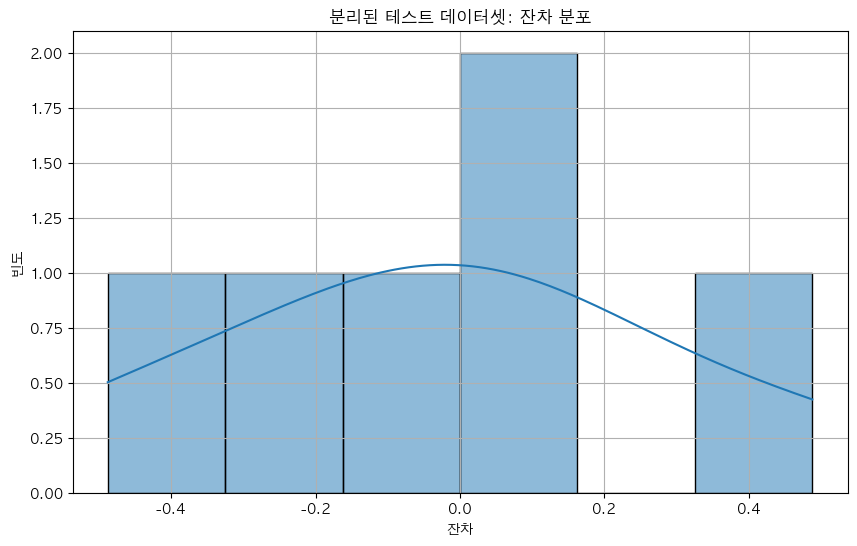

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드 (학습 시와 동일하게)
file_name = '최종.xlsx' # CSV 파일로 변경|
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성 (학습 시와 동일하게)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1) # 0으로 나누는 오류 방지

# 파생 변수 생성 (컬럼 존재 여부 확인 후 생성)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
    df['시세초과비율'] = (df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']
else:
    print("경고: '주변시세 평균(만원)' 컬럼이 없어 시세 관련 파생변수를 생성하지 않습니다.")
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0

if '시세차익(만원)' in df.columns:
    df['시세차익률'] = df['시세차익(만원)'] / df['분양가(만원)']
else:
    print("경고: '시세차익(만원)' 컬럼이 없어 시세차익률을 생성하지 않습니다.")

if '전용면적(㎡)' in df.columns and '공급면적(㎡)' in df.columns:
    df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
else:
    print("경고: 전용면적 또는 공급면적 컬럼이 없어 전용률을 생성하지 않습니다.")

if '특별분양' in df.columns:
    df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else:
    print("경고: '특별분양' 컬럼이 없어 특별분양유무를 생성하지 않습니다.")
    df['특별분양유무'] = 0

if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                          labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'])
else:
    print("경고: '금리' 컬럼이 없어 금리구간을 생성하지 않습니다.")
    df['금리구간'] = '기타'

target_col = '분양률'
y_full_dataset = df[target_col]
X_full_dataset_features = df.drop(columns=[target_col])

# --- 테스트 데이터셋 분리 (이전 학습 코드와 동일하게 재현) ---
print("\n--- 테스트 데이터셋 재분리 (전처리기를 올바르게 재설정하기 위함) ---")
test_samples_indices = []

sampling_rules = [
    (0.9, 1.0, 1, "분양률 0.9~1.0"),
    (0.8, 0.9, 1, "분양률 0.8~0.9"),
    (0.7, 0.8, 1, "분양률 0.7~0.8"),
    (0.0, 0.7, 3, "분양률 0.7 미만")
]

remaining_df = df.copy()

for min_rate, max_rate, n_samples, description in sampling_rules:
    if max_rate == 1.0:
        candidates = remaining_df[(remaining_df['분양률'] >= min_rate) & (remaining_df['분양률'] <= max_rate)]
    else:
        candidates = remaining_df[(remaining_df['분양률'] >= min_rate) & (remaining_df['분양률'] < max_rate)]

    if len(candidates) >= n_samples:
        selected_samples = candidates.sample(n=n_samples, random_state=42)
        test_samples_indices.extend(selected_samples.index.tolist())
        remaining_df = remaining_df.drop(selected_samples.index)
        print(f"{description}: {n_samples}개 샘플 선택 완료")
    elif len(candidates) > 0:
        selected_samples = candidates
        test_samples_indices.extend(selected_samples.index.tolist())
        remaining_df = remaining_df.drop(selected_samples.index)
        print(f"경고: {description}에서 {len(selected_samples)}개만 선택 (요구: {n_samples}개)")
    else:
        print(f"경고: {description}에서 선택 가능한 샘플이 없습니다.")

# 학습 데이터 (train_df)와 테스트 데이터 (test_df) 재구성
test_df = df.loc[test_samples_indices].copy()
train_df = df.drop(index=test_samples_indices).copy()

print(f"분리된 테스트 데이터셋 크기: {len(test_df)} 샘플")
print(f"학습 데이터셋 크기: {len(train_df)} 샘플")

# --- 피처 정의 (모델 학습 시 사용된 것으로 예상되는 전체 피처 목록) ---
# OLS 기반 피처 선택 로직을 여기서는 제거하고, 대신 모델이 기대하는
# 입력 차원 (46)에 맞춰 모든 관련 수치형 및 범주형 피처를 포함시킵니다.
features_to_embed = ['아파트', '지역', '건설사']

# 모든 숫자형 컬럼을 초기 수치형 피처로 포함합니다. (임베딩 피처 제외)
numerical_features = [col for col in X_full_dataset_features.select_dtypes(include=np.number).columns.tolist() if col not in features_to_embed]

# 범주형 컬럼 중 OneHot 인코딩할 피처를 명시합니다.
# '준공여부', '금리구간', '시세초과여부'는 OneHot 인코딩 대상일 가능성이 높습니다.
categorical_features_onehot = []
if '준공여부' in X_full_dataset_features.columns and (X_full_dataset_features['준공여부'].dtype == 'object' or X_full_dataset_features['준공여부'].dtype == 'bool'):
    categorical_features_onehot.append('준공여부')
if '금리구간' in X_full_dataset_features.columns and (X_full_dataset_features['금리구간'].dtype == 'object' or pd.api.types.is_categorical_dtype(X_full_dataset_features['금리구간'])):
    categorical_features_onehot.append('금리구간')
if '시세초과여부' in X_full_dataset_features.columns and (X_full_dataset_features['시세초과여부'].dtype == 'object' or X_full_dataset_features['시세초과여부'].dtype == 'bool'):
    categorical_features_onehot.append('시세초과여부')

print(f"\n최종적으로 사용할 임베딩 피처: {features_to_embed}")
print(f"최종적으로 사용할 원-핫 인코딩 피처: {categorical_features_onehot}")
print(f"최종적으로 사용할 수치형 피처: {numerical_features}")

# --- 저장된 모델 로드 ---
model_save_path = "apartment_sales_rate_prediction_model.keras"
try:
    loaded_model = load_model(model_save_path)
    print(f"\n최종 모델이 '{model_save_path}' 경로에서 성공적으로 로드되었습니다.")
except Exception as e:
    print(f"\n오류: 모델 로드에 실패했습니다. '{model_save_path}' 파일이 존재하고 손상되지 않았는지 확인하세요.")
    print(f"오류 내용: {e}")
    exit()

# --- 예측을 위한 final_preprocessor 재설정 및 fit ---
# 학습 데이터셋의 선택된 피처에 대해 preprocessor fit
X_other_for_preprocessor_fit = train_df[numerical_features + categorical_features_onehot]

# 결측값 처리를 위한 중앙값 저장
median_values = {}
for col in numerical_features:
    if X_other_for_preprocessor_fit[col].isnull().any():
        median_val = X_other_for_preprocessor_fit[col].median()
        median_values[col] = median_val
        X_other_for_preprocessor_fit[col] = X_other_for_preprocessor_fit[col].fillna(median_val)

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

# final_preprocessor를 train_df의 선택된 피처에 fit
final_preprocessor.fit(X_other_for_preprocessor_fit)

# 확인용: 변환 후 차원 출력
X_test_sample = test_df[numerical_features + categorical_features_onehot].iloc[:1]
for col in numerical_features:
    if X_test_sample[col].isnull().any():
        if col in median_values:
            X_test_sample[col] = X_test_sample[col].fillna(median_values[col])

X_sample_transformed = final_preprocessor.transform(X_test_sample)
print(f"\n정보: final_preprocessor가 학습 데이터셋에 성공적으로 fit 되었습니다.")
print(f"변환 후 피처 차원: {X_sample_transformed.shape[1]} (모델 예상 차원과 일치해야 함)")


# --- 분리된 테스트 데이터셋에 대한 예측 및 결과 출력 ---
print("\n--- 분리된 테스트 데이터셋에 대한 예측 ---")

# 테스트 데이터셋 준비 (선택된 피처만 사용)
loaded_test_df = test_df.copy()

X_test_for_pred_other = loaded_test_df[numerical_features + categorical_features_onehot]  # 선택된 피처만
y_true_test_separated = loaded_test_df[target_col]

# 결측값 처리 (학습 시와 동일한 중앙값 사용)
for col in numerical_features:
    if X_test_for_pred_other[col].isnull().any():
        if col in median_values:
            X_test_for_pred_other[col] = X_test_for_pred_other[col].fillna(median_values[col])
        else:
            # 혹시 학습 시 결측값이 없었던 컬럼인 경우
            X_test_for_pred_other[col] = X_test_for_pred_other[col].fillna(X_test_for_pred_other[col].median())

# final_preprocessor를 사용하여 테스트 데이터 변환
X_test_processed_np = final_preprocessor.transform(X_test_for_pred_other).astype(np.float32)

print(f"테스트 데이터 변환 후 차원: {X_test_processed_np.shape}")

# 임베딩할 문자열 피처 준비
apartment_test_np = loaded_test_df['아파트'].values.reshape(-1, 1).astype(str)
region_test_np = loaded_test_df['지역'].values.reshape(-1, 1).astype(str)
construction_company_test_np = loaded_test_df['건설사'].values.reshape(-1, 1).astype(str)

print(f"임베딩 피처 준비 완료: 아파트({len(apartment_test_np)}), 지역({len(region_test_np)}), 건설사({len(construction_company_test_np)})")

# 예측 수행
y_pred_test_separated = loaded_model.predict(
    x=[
        X_test_processed_np,
        tf.constant(apartment_test_np, dtype=tf.string),
        tf.constant(region_test_np, dtype=tf.string),
        tf.constant(construction_company_test_np, dtype=tf.string)
    ]
).flatten()

# 결과 DataFrame 출력
print("\n분리된 테스트 데이터셋 예측 결과:")
separated_results_df = pd.DataFrame({
    'Actual_분양률': y_true_test_separated,
    'Predicted_분양률': y_pred_test_separated,
    'Absolute_Error': abs(y_true_test_separated - y_pred_test_separated)
})
print(separated_results_df)

# 성능 지표 계산
mse_test_sep = mean_squared_error(y_true_test_separated, y_pred_test_separated)
mae_test_sep = mean_absolute_error(y_true_test_separated, y_pred_test_separated)
r2_test_sep = r2_score(y_true_test_separated, y_pred_test_separated)

print(f"\n분리된 테스트 데이터셋 성능:")
print(f"MSE: {mse_test_sep:.4f}")
print(f"MAE: {mae_test_sep:.4f}")
print(f"R2 Score: {r2_test_sep:.4f}")

# 시각화 (테스트 데이터셋)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_test_separated, y=y_pred_test_separated, alpha=0.8, s=100)
plt.plot([y_true_test_separated.min(), y_true_test_separated.max()],
         [y_true_test_separated.min(), y_true_test_separated.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("분리된 테스트 데이터셋: 실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.savefig('actual_vs_predicted_test.png') # 이미지 파일 저장

residuals_test_sep = y_true_test_separated - y_pred_test_separated
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_separated, y=residuals_test_sep, alpha=0.8, s=100)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("분리된 테스트 데이터셋: 잔차 플롯")
plt.grid(True)
plt.savefig('residuals_plot_test.png') # 이미지 파일 저장

if len(residuals_test_sep) > 1: # 샘플 수가 1개일 때는 히스토그램 그릴 수 없음
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_test_sep, kde=True, bins=min(len(residuals_test_sep), 10))
    plt.xlabel("잔차")
    plt.ylabel("빈도")
    plt.title("분리된 테스트 데이터셋: 잔차 분포")
    plt.grid(True)
    plt.savefig('residuals_distribution_test.png') # 이미지 파일 저장

# --- 추가: 개별 예측 결과 상세 분석 ---
print("\n--- 개별 예측 결과 상세 분석 ---")
for idx, (actual, predicted) in enumerate(zip(y_true_test_separated, y_pred_test_separated)):
    error = abs(actual - predicted)
    error_pct = (error / actual * 100) if actual != 0 else 0
    print(f"샘플 {idx+1}: 실제={actual:.3f}, 예측={predicted:.3f}, 절대오차={error:.3f}, 상대오차={error_pct:.1f}%")

정보: '주변시세 평균' 컬럼을 제거했습니다.
임베딩 피처: ['아파트', '지역', '건설사']
원-핫 인코딩 피처: ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
수치형 피처: ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '미분양수', '분양가(만원)', '금리', '환율', '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내', '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년', '월', '시세초과비율', '시세차익률', '전용률']

--- 테스트 데이터셋 분리 ---
분양률 0.9~1.0: 1개 샘플 선택 완료
분양률 0.8~0.9: 1개 샘플 선택 완료
분양률 0.7~0.8: 1개 샘플 선택 완료
분양률 0.7 미만: 3개 샘플 선택 완료

분리된 테스트 데이터셋 크기: 6 샘플
학습 데이터셋 크기: 2208 샘플
테스트 데이터 분양률 분포:
count    6.000000
mean     0.530735
std      0.420048
min      0.000000
25%      0.172619
50%      0.631356
75%      0.834335
max      1.000000
Name: 분양률, dtype: float64
분리된 테스트 데이터셋이 'separated_test_data.json'에 저장되었습니다.

--- 5-Fold 교차 검증 시작 ---

--- 폴드 1/5 ---


E0000 00:00:1753246291.259802 3310927 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
폴드 1 - 손실 (MSE): 0.0384, MAE: 0.1254, R2 스코어: 0.6126

--- 폴드 2/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


E0000 00:00:1753246365.634929 3310927 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


폴드 2 - 손실 (MSE): 0.0159, MAE: 0.0584, R2 스코어: 0.8330

--- 폴드 3/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
폴드 3 - 손실 (MSE): 0.0215, MAE: 0.0707, R2 스코어: 0.7851

--- 폴드 4/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


E0000 00:00:1753246432.821569 3310927 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


폴드 4 - 손실 (MSE): 0.0244, MAE: 0.0952, R2 스코어: 0.7476

--- 폴드 5/5 ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
폴드 5 - 손실 (MSE): 0.0244, MAE: 0.1096, R2 스코어: 0.7158

--- 교차 검증 요약 ---
평균 MSE: 0.0249 (표준편차: 0.0074)
평균 MAE: 0.0919 (표준편차: 0.0246)
평균 R2 스코어: 0.7388 (표준편차: 0.0742)

--- 교차 검증 성능 시각화 ---


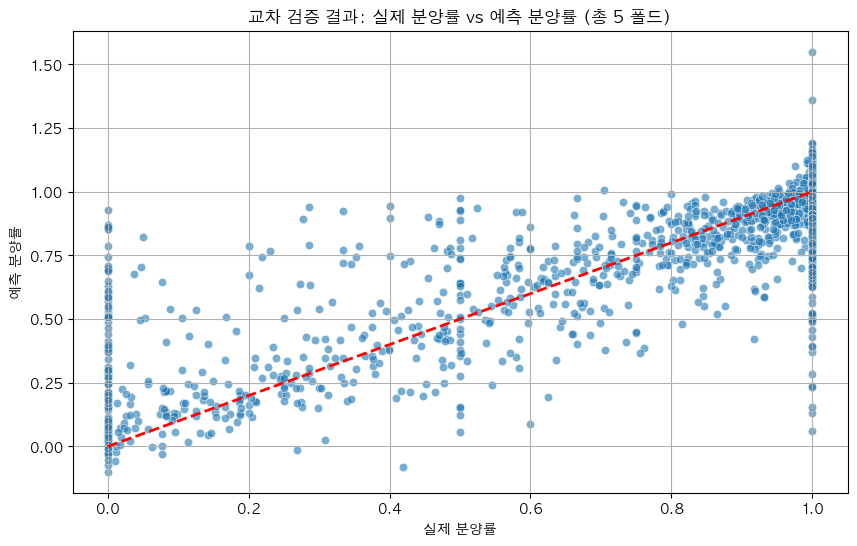

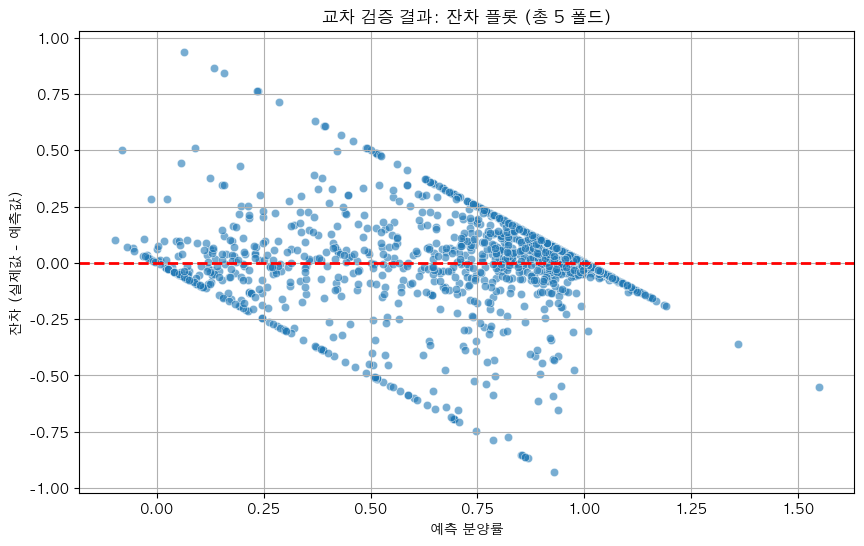

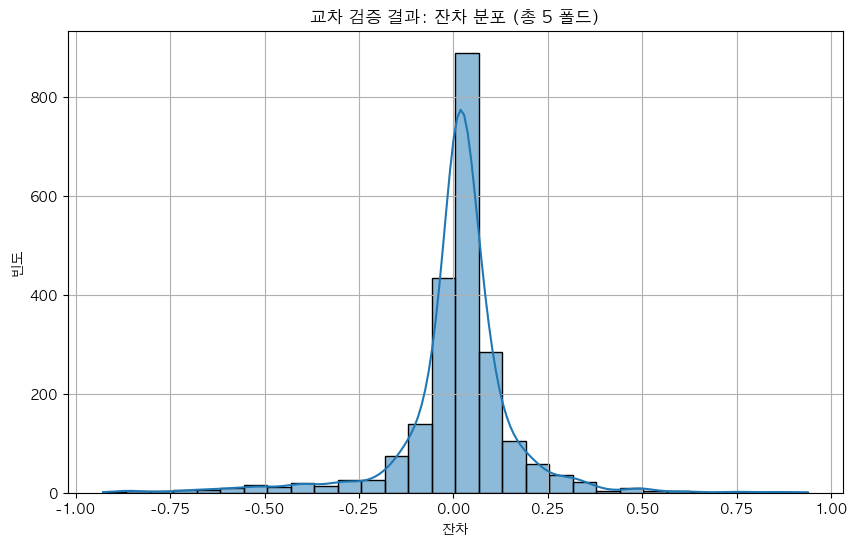


--- 최종 모델 학습 및 저장 (Validation 포함) ---
최종 학습 데이터: 1766 샘플
최종 검증 데이터: 442 샘플
최종 모델 학습 시작...
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1837 - mae: 0.3272 - val_loss: 0.0655 - val_mae: 0.1870 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0668 - mae: 0.1988 - val_loss: 0.0512 - val_mae: 0.1600 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0509 - mae: 0.1731 - val_loss: 0.0607 - val_mae: 0.1577 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0441 - mae: 0.1555 - val_loss: 0.0546 - val_mae: 0.1566 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0397 - mae: 0.1469 - val_loss: 0.0563 - val_mae: 0.1612 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0428 - mae: 0.1408 - val_loss: 0.0486 - val_mae: 0.1421 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - los

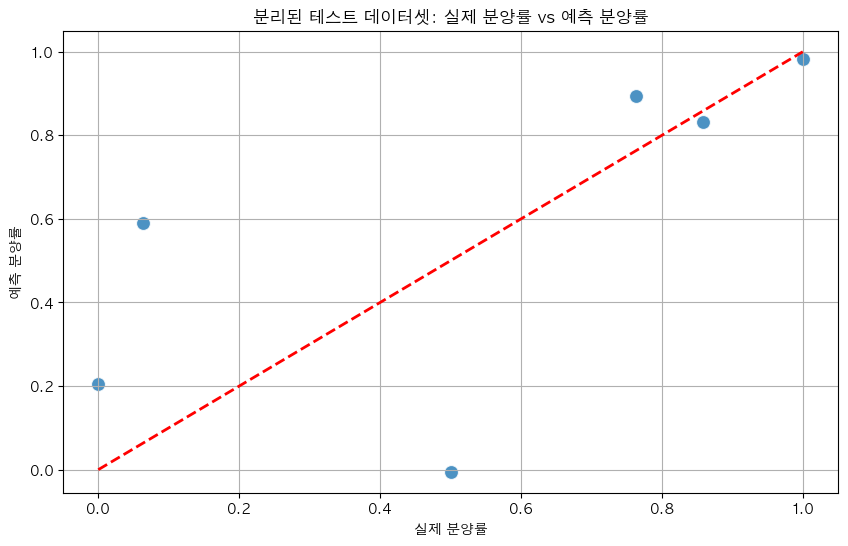

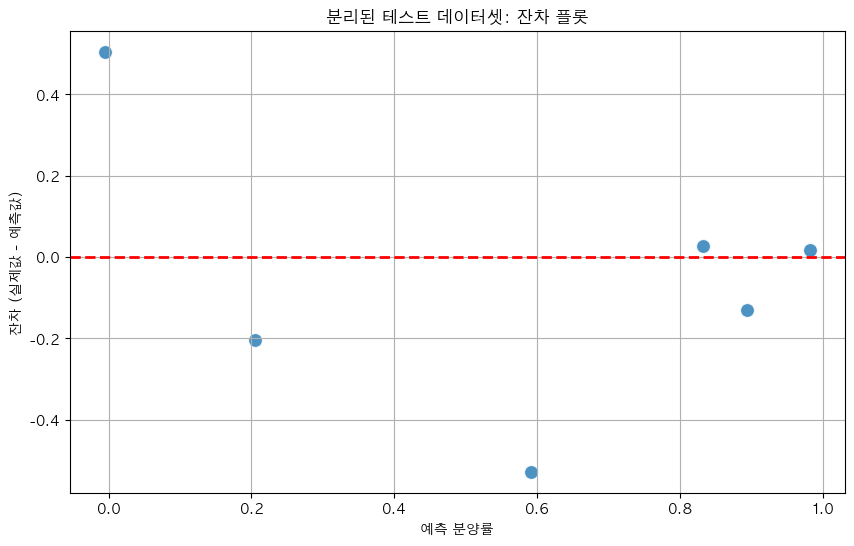

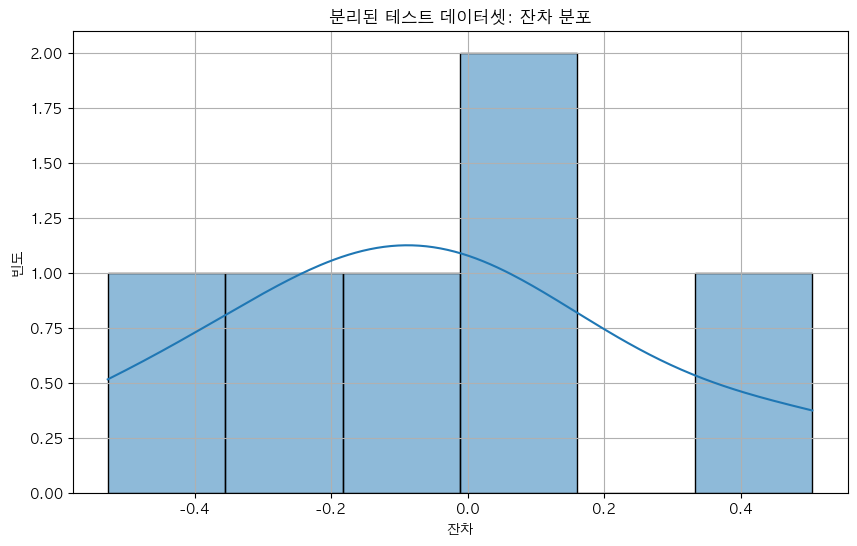

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 전처리기를 저장하기 위해 추가
import json   # 어휘집 및 중앙값을 저장하기 위해 추가
import os     # 파일 경로 관리를 위해 추가

# 한글 폰트 설정 (AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다. 파일이 업로드되었는지, 이름이 올바른지 확인해주세요.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

# 주변시세 평균(억원 단위) 제거 - 만원 단위와 중복이므로
if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])
    print("정보: '주변시세 평균' 컬럼을 제거했습니다.")

# 0으로 나누는 오류 방지
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)

# 파생 변수 생성 (주변시세 평균(만원) 사용)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
    df['시세초과비율'] = (df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']
    # Replace inf or -inf with NaN, then handle NaN
    df['시세초과비율'] = df['시세초과비율'].replace([np.inf, -np.inf], np.nan)
    df['시세초과비율'] = df['시세초과비율'].fillna(0) # or median/mean
else:
    print("경고: '주변시세 평균(만원)' 컬럼이 없어 시세 관련 파생변수를 생성하지 않습니다.")
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0

if '시세차익(만원)' in df.columns:
    df['시세차익률'] = df['시세차익(만원)'] / df['분양가(만원)']
    df['시세차익률'] = df['시세차익률'].replace([np.inf, -np.inf], np.nan)
    df['시세차익률'] = df['시세차익률'].fillna(0) # or median/mean
else:
    print("경고: '시세차익(만원)' 컬럼이 없어 시세차익률을 생성하지 않습니다.")

if '전용면적(㎡)' in df.columns and '공급면적(㎡)' in df.columns:
    df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
    df['전용률'] = df['전용률'].replace([np.inf, -np.inf], np.nan)
    df['전용률'] = df['전용률'].fillna(0) # or median/mean
else:
    print("경고: 전용면적 또는 공급면적 컬럼이 없어 전용률을 생성하지 않습니다.")

if '특별분양' in df.columns:
    df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else:
    print("경고: '특별분양' 컬럼이 없어 특별분양유무를 생성하지 않습니다.")
    df['특별분양유무'] = 0

if '금리' in df.columns:
    # Ensure '금리구간' is created with explicit categories to avoid issues with new data
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                          labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'],
                          right=False) # Use right=False for left-inclusive intervals
    # Fill NaN from cut (e.g., if 금리 is outside bins) with '기타'
    df['금리구간'] = df['금리구간'].cat.add_categories('기타').fillna('기타')
else:
    print("경고: '금리' 컬럼이 없어 금리구간을 생성하지 않습니다.")
    df['금리구간'] = '기타'
    df['금리구간'] = df['금리구간'].astype('category') # Ensure it's a categorical type

target_col = '분양률'
y_true_all = df[target_col]
X_all_features = df.drop(columns=[target_col])

# --- 피처 그룹 정의 ---
features_to_embed = ['아파트', '지역', '건설사']

# 실제 존재하는 컬럼들만 사용
potential_categorical_onehot = ['준공여부', '시세초과여부', '특별분양유무', '금리구간']
categorical_features_onehot = [col for col in potential_categorical_onehot if col in X_all_features.columns]
# Ensure boolean and int columns that are used as categories are treated as objects for OneHotEncoder
for col in ['시세초과여부', '특별분양유무']:
    if col in categorical_features_onehot and col in X_all_features.columns:
        X_all_features[col] = X_all_features[col].astype(str) # Convert to string for consistent one-hot encoding if not already object

numerical_features = [col for col in X_all_features.select_dtypes(include=np.number).columns.tolist()
                      if col not in features_to_embed and col not in categorical_features_onehot]


# Reorder numerical_features to ensure consistency if any new numerical feature was generated and added by select_dtypes
# This helps maintain the order for the ColumnTransformer
all_numerical_cols_in_df = [
    '공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '미분양수', '분양가(만원)', '금리', '환율',
    '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내',
    '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내',
    '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)',
    '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내',
    '고속도로IC - 10km 이내', '주변시세 평균(만원)', '시세차익(만원)', '년', '월',
    '시세초과비율', '시세차익률', '전용률'
    # '특별분양유무' is now handled as categorical for one-hot
]
numerical_features = [col for col in all_numerical_cols_in_df if col in X_all_features.columns and col not in features_to_embed and col not in categorical_features_onehot]


print(f"임베딩 피처: {features_to_embed}")
print(f"원-핫 인코딩 피처: {categorical_features_onehot}")
print(f"수치형 피처: {numerical_features}")

# --- 테스트 데이터셋 분리 (개선된 로직) ---
print("\n--- 테스트 데이터셋 분리 ---")

# 분양률별 구간 정의 및 샘플링
sampling_rules = [
    (0.9, 1.0, 1, "분양률 0.9~1.0"),
    (0.8, 0.9, 1, "분양률 0.8~0.9"),
    (0.7, 0.8, 1, "분양률 0.7~0.8"),
    (0.0, 0.7, 3, "분양률 0.7 미만")
]

test_samples_indices = []
remaining_df = df.copy()

for min_rate, max_rate, n_samples, description in sampling_rules:
    if max_rate == 1.0:
        candidates = remaining_df[(remaining_df['분양률'] >= min_rate) & (remaining_df['분양률'] <= max_rate)]
    else:
        candidates = remaining_df[(remaining_df['분양률'] >= min_rate) & (remaining_df['분양률'] < max_rate)]

    if len(candidates) >= n_samples:
        selected_samples = candidates.sample(n=n_samples, random_state=42)
        test_samples_indices.extend(selected_samples.index.tolist())
        remaining_df = remaining_df.drop(selected_samples.index)
        print(f"{description}: {n_samples}개 샘플 선택 완료")
    elif len(candidates) > 0:
        selected_samples = candidates
        test_samples_indices.extend(selected_samples.index.tolist())
        remaining_df = remaining_df.drop(selected_samples.index)
        print(f"경고: {description}에서 {len(selected_samples)}개만 선택 (요구: {n_samples}개)")
    else:
        print(f"경고: {description}에서 선택 가능한 샘플이 없습니다.")

test_df = df.loc[test_samples_indices].copy()
train_df = df.drop(index=test_samples_indices).copy()

print(f"\n분리된 테스트 데이터셋 크기: {len(test_df)} 샘플")
print(f"학습 데이터셋 크기: {len(train_df)} 샘플")
print(f"테스트 데이터 분양률 분포:\n{test_df['분양률'].describe()}")

# 테스트 데이터 저장 (UI에서 로드하기 위해)
test_json_path = 'separated_test_data.json'
test_df.to_json(test_json_path, orient='records', indent=4, force_ascii=False)
print(f"분리된 테스트 데이터셋이 '{test_json_path}'에 저장되었습니다.")

# 학습 데이터로 타겟과 피처 분리
y_train_full = train_df[target_col]
X_train_full_features = train_df.drop(columns=[target_col])

# --- 교차 검증 ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_mses = []
fold_maes = []
fold_r2s = []

all_y_true_cv = []
all_y_pred_cv = []

print(f"\n--- {n_splits}-Fold 교차 검증 시작 ---")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_full_features)):
    print(f"\n--- 폴드 {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X_train_full_features.iloc[train_index], X_train_full_features.iloc[val_index]
    y_train_fold, y_val_fold = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # 인덱스 초기화
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_val_fold = X_val_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_val_fold = y_val_fold.reset_index(drop=True)

    # 임베딩할 피처는 별도로 분리하여 NumPy 배열로 준비
    apartment_train_np = X_train_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_train_np = X_train_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_train_np = X_train_fold['건설사'].values.reshape(-1, 1).astype(str)

    apartment_val_np = X_val_fold['아파트'].values.reshape(-1, 1).astype(str)
    region_val_np = X_val_fold['지역'].values.reshape(-1, 1).astype(str)
    construction_company_val_np = X_val_fold['건설사'].values.reshape(-1, 1).astype(str)

    # 수치형 및 원-핫 인코딩할 피처만 포함하는 X_other
    X_other_train_fold = X_train_fold[numerical_features + categorical_features_onehot]
    X_other_val_fold = X_val_fold[numerical_features + categorical_features_onehot]

    # 결측값 처리 (각 폴드의 학습 데이터에서 중앙값 계산 및 적용)
    median_values = {}
    for col in numerical_features:
        if X_other_train_fold[col].isnull().any():
            median_val = X_other_train_fold[col].median()
            median_values[col] = median_val
            X_other_train_fold[col] = X_other_train_fold[col].fillna(median_val)
            X_other_val_fold[col] = X_other_val_fold[col].fillna(median_val)

    # ColumnTransformer 정의 및 학습
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='passthrough'
    )

    x_train_processed_np = preprocessor.fit_transform(X_other_train_fold).astype(np.float32)
    x_val_processed_np = preprocessor.transform(X_other_val_fold).astype(np.float32)
    other_features_dim = x_train_processed_np.shape[1]

    # 임베딩을 위한 어휘집 정의
    unique_apartment_names_train = X_train_fold['아파트'].unique().tolist()
    unique_region_names_train = X_train_fold['지역'].unique().tolist()
    unique_construction_company_names_train = X_train_fold['건설사'].unique().tolist()

    def calculate_embedding_dim(vocab_size):
        emb_dim = min(50, (vocab_size + 1) // 2)
        return max(1, emb_dim)

    vocab_size_apartment = len(unique_apartment_names_train) + 1
    embedding_dim_apartment = calculate_embedding_dim(vocab_size_apartment)

    vocab_size_region = len(unique_region_names_train) + 1
    embedding_dim_region = calculate_embedding_dim(vocab_size_region)

    vocab_size_construction_company = len(unique_construction_company_names_train) + 1
    embedding_dim_construction_company = calculate_embedding_dim(vocab_size_construction_company)

    # --- Keras 모델 구축 ---
    other_features_input = Input(shape=(other_features_dim,), name='other_features_input')
    apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
    region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
    construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

    string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=unique_apartment_names_train, mask_token=None)
    embedding_apartment = Embedding(input_dim=vocab_size_apartment, output_dim=embedding_dim_apartment)
    x_apartment = string_lookup_apartment(apartment_input)
    x_apartment = embedding_apartment(x_apartment)
    x_apartment = Flatten()(x_apartment)

    string_lookup_region = tf.keras.layers.StringLookup(vocabulary=unique_region_names_train, mask_token=None)
    embedding_region = Embedding(input_dim=vocab_size_region, output_dim=embedding_dim_region)
    x_region = string_lookup_region(region_input)
    x_region = embedding_region(x_region)
    x_region = Flatten()(x_region)

    string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=unique_construction_company_names_train, mask_token=None)
    embedding_construction_company = Embedding(input_dim=vocab_size_construction_company, output_dim=embedding_dim_construction_company)
    x_construction_company = string_lookup_construction_company(construction_company_input)
    x_construction_company = embedding_construction_company(x_construction_company)
    x_construction_company = Flatten()(x_construction_company)

    concatenated_features = Concatenate()([
        other_features_input,
        x_apartment,
        x_region,
        x_construction_company
    ])

    x = Dense(256, activation='relu')(concatenated_features)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[
        other_features_input,
        apartment_input,
        region_input,
        construction_company_input
    ], outputs=output)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

    # --- 모델 학습 ---
    history = model.fit(
        x=[
            x_train_processed_np,
            tf.constant(apartment_train_np, dtype=tf.string),
            tf.constant(region_train_np, dtype=tf.string),
            tf.constant(construction_company_train_np, dtype=tf.string)
        ],
        y=y_train_fold.values.astype(np.float32),
        epochs=100,
        batch_size=32,
        validation_data=(
            [
                x_val_processed_np,
                tf.constant(apartment_val_np, dtype=tf.string),
                tf.constant(region_val_np, dtype=tf.string),
                tf.constant(construction_company_val_np, dtype=tf.string)
            ],
            y_val_fold.values.astype(np.float32)
        ),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # --- 모델 평가 ---
    val_loss, val_mae = model.evaluate(
        x=[
            x_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ],
        y=y_val_fold.values.astype(np.float32),
        verbose=0
    )
    y_pred_fold = model.predict(
        x=[
            x_val_processed_np,
            tf.constant(apartment_val_np, dtype=tf.string),
            tf.constant(region_val_np, dtype=tf.string),
            tf.constant(construction_company_val_np, dtype=tf.string)
        ]
    ).flatten()
    val_r2 = r2_score(y_val_fold.values, y_pred_fold)

    print(f"폴드 {fold+1} - 손실 (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}, R2 스코어: {val_r2:.4f}")

    fold_mses.append(val_loss)
    fold_maes.append(val_mae)
    fold_r2s.append(val_r2)

    all_y_true_cv.extend(y_val_fold.values)
    all_y_pred_cv.extend(y_pred_fold)

print("\n--- 교차 검증 요약 ---")
print(f"평균 MSE: {np.mean(fold_mses):.4f} (표준편차: {np.std(fold_mses):.4f})")
print(f"평균 MAE: {np.mean(fold_maes):.4f} (표준편차: {np.std(fold_maes):.4f})")
print(f"평균 R2 스코어: {np.mean(fold_r2s):.4f} (표준편차: {np.std(fold_r2s):.4f})")

# --- 교차 검증 결과 시각화 ---
print("\n--- 교차 검증 성능 시각화 ---")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_true_cv, y=all_y_pred_cv, alpha=0.6)
plt.plot([min(all_y_true_cv), max(all_y_true_cv)], [min(all_y_true_cv), max(all_y_true_cv)], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title(f"교차 검증 결과: 실제 분양률 vs 예측 분양률 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

overall_residuals_cv = np.array(all_y_true_cv) - np.array(all_y_pred_cv)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_pred_cv, y=overall_residuals_cv, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title(f"교차 검증 결과: 잔차 플롯 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(overall_residuals_cv, kde=True, bins=30)
plt.xlabel("잔차")
plt.ylabel("빈도")
plt.title(f"교차 검증 결과: 잔차 분포 (총 {n_splits} 폴드)")
plt.grid(True)
plt.show()

# --- 최종 모델 학습 및 저장 ---
print("\n--- 최종 모델 학습 및 저장 (Validation 포함) ---")

from sklearn.model_selection import train_test_split

# 1. train_df를 다시 train/validation으로 분리 (80:20)
final_train_df, final_val_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=None
)

print(f"최종 학습 데이터: {len(final_train_df)} 샘플")
print(f"최종 검증 데이터: {len(final_val_df)} 샘플")

# 2. 최종 모델 학습을 위한 데이터 준비
X_other_final_train = final_train_df[numerical_features + categorical_features_onehot]
X_other_final_val = final_val_df[numerical_features + categorical_features_onehot]
y_final_train = final_train_df[target_col]
y_final_val = final_val_df[target_col]

# 결측값 처리 (최종 학습 데이터에서 중앙값 계산 및 적용)
final_median_values = {}
for col in numerical_features:
    if X_other_final_train[col].isnull().any():
        median_val = X_other_final_train[col].median()
        final_median_values[col] = median_val
        X_other_final_train[col] = X_other_final_train[col].fillna(median_val)
        X_other_final_val[col] = X_other_final_val[col].fillna(median_val)

# 최종 전처리기는 최종 학습 데이터에 fit
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
    ],
    remainder='passthrough'
)

x_processed_final_train_np = final_preprocessor.fit_transform(X_other_final_train).astype(np.float32)
x_processed_final_val_np = final_preprocessor.transform(X_other_final_val).astype(np.float32)
final_other_features_dim = x_processed_final_train_np.shape[1]

# 3. 임베딩 어휘집 (최종 학습 데이터에서 고유값으로 생성)
final_unique_apartment_names = final_train_df['아파트'].unique().tolist()
final_unique_region_names = final_train_df['지역'].unique().tolist()
final_unique_construction_company_names = final_train_df['건설사'].unique().tolist()

final_vocab_size_apartment = len(final_unique_apartment_names) + 1
final_embedding_dim_apartment = calculate_embedding_dim(final_vocab_size_apartment)

final_vocab_size_region = len(final_unique_region_names) + 1
final_embedding_dim_region = calculate_embedding_dim(final_vocab_size_region)

final_vocab_size_construction_company = len(final_unique_construction_company_names) + 1
final_embedding_dim_construction_company = calculate_embedding_dim(final_vocab_size_construction_company)

# 4. 최종 모델 구축 (교차 검증과 동일한 아키텍처)
final_other_features_input = Input(shape=(final_other_features_dim,), name='other_features_input')
final_apartment_input = Input(shape=(1,), dtype=tf.string, name='apartment_input')
final_region_input = Input(shape=(1,), dtype=tf.string, name='region_input')
final_construction_company_input = Input(shape=(1,), dtype=tf.string, name='construction_company_input')

# StringLookup 레이어는 모델 그래프의 일부이므로, 모델 저장 시 함께 저장됩니다.
# vocabulary는 학습 시 fit_on_texts 등으로 내부적으로 설정됩니다.
# 여기서는 모델 빌딩을 위한 초기화입니다.
final_string_lookup_apartment = tf.keras.layers.StringLookup(vocabulary=final_unique_apartment_names, mask_token=None)
final_embedding_apartment = Embedding(input_dim=final_vocab_size_apartment, output_dim=final_embedding_dim_apartment)
final_x_apartment = final_string_lookup_apartment(final_apartment_input)
final_x_apartment = final_embedding_apartment(final_x_apartment)
final_x_apartment = Flatten()(final_x_apartment)

final_string_lookup_region = tf.keras.layers.StringLookup(vocabulary=final_unique_region_names, mask_token=None)
final_embedding_region = Embedding(input_dim=final_vocab_size_region, output_dim=final_embedding_dim_region)
final_x_region = final_string_lookup_region(final_region_input)
final_x_region = final_embedding_region(final_x_region)
final_x_region = Flatten()(final_x_region)

final_string_lookup_construction_company = tf.keras.layers.StringLookup(vocabulary=final_unique_construction_company_names, mask_token=None)
final_embedding_construction_company = Embedding(input_dim=final_vocab_size_construction_company, output_dim=final_embedding_dim_construction_company)
final_x_construction_company = final_string_lookup_construction_company(final_construction_company_input)
final_x_construction_company = final_embedding_construction_company(final_x_construction_company)
final_x_construction_company = Flatten()(final_x_construction_company)

final_concatenated_features = Concatenate()([
    final_other_features_input,
    final_x_apartment,
    final_x_region,
    final_x_construction_company
])

final_x = Dense(256, activation='relu')(final_concatenated_features)
final_x = Dropout(0.2)(final_x)
final_x = Dense(128, activation='relu')(final_x)
final_x = Dropout(0.2)(final_x)
final_x = Dense(64, activation='relu')(final_x)
final_output = Dense(1, activation='linear')(final_x)

final_model = Model(inputs=[
    final_other_features_input,
    final_apartment_input,
    final_region_input,
    final_construction_company_input
], outputs=final_output)

# 5. 콜백 설정 (교차 검증과 동일)
final_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
final_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# 6. 최종 모델 학습 (validation과 callbacks 포함)
print("최종 모델 학습 시작...")
final_history = final_model.fit(
    x=[
        x_processed_final_train_np,
        tf.constant(final_train_df['아파트'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(final_train_df['지역'].values.reshape(-1, 1).astype(str), dtype=tf.string),
        tf.constant(final_train_df['건설사'].values.reshape(-1, 1).astype(str), dtype=tf.string)
    ],
    y=y_final_train.values.astype(np.float32),
    epochs=100,  # 교차 검증과 동일
    batch_size=32,
    validation_data=(
        [
            x_processed_final_val_np,
            tf.constant(final_val_df['아파트'].values.reshape(-1, 1).astype(str), dtype=tf.string),
            tf.constant(final_val_df['지역'].values.reshape(-1, 1).astype(str), dtype=tf.string),
            tf.constant(final_val_df['건설사'].values.reshape(-1, 1).astype(str), dtype=tf.string)
        ],
        y_final_val.values.astype(np.float32)
    ),
    callbacks=[final_early_stopping, final_reduce_lr],
    verbose=1
)

print(f"최종 모델 학습 완료. 총 {len(final_history.history['loss'])} 에폭 학습됨.")

# --- 모델 및 전처리 자산 저장 ---
# model_assets 디렉토리 생성
model_assets_dir = "model_assets"
os.makedirs(model_assets_dir, exist_ok=True)

# 5. 모델 저장
model_save_path = os.path.join(model_assets_dir, "apartment_sales_rate_prediction_model.keras")
final_model.save(model_save_path)
print(f"\n최종 모델이 '{model_save_path}' 경로에 성공적으로 저장되었습니다.")

# 전처리기 저장
preprocessor_save_path = os.path.join(model_assets_dir, "final_preprocessor.joblib")
joblib.dump(final_preprocessor, preprocessor_save_path)
print(f"최종 전처리기가 '{preprocessor_save_path}' 경로에 저장되었습니다.")

# 중앙값 저장
median_values_save_path = os.path.join(model_assets_dir, "final_median_values.json")
with open(median_values_save_path, 'w', encoding='utf-8') as f:
    json.dump(final_median_values, f, indent=4, ensure_ascii=False)
print(f"결측값 처리를 위한 중앙값이 '{median_values_save_path}' 경로에 저장되었습니다.")

# 임베딩 어휘집 저장
vocab_save_dir = os.path.join(model_assets_dir, "embedding_vocabularies")
os.makedirs(vocab_save_dir, exist_ok=True)

with open(os.path.join(vocab_save_dir, 'apartment_vocab.json'), 'w', encoding='utf-8') as f:
    json.dump(final_unique_apartment_names, f, indent=4, ensure_ascii=False)
with open(os.path.join(vocab_save_dir, 'region_vocab.json'), 'w', encoding='utf-8') as f:
    json.dump(final_unique_region_names, f, indent=4, ensure_ascii=False)
with open(os.path.join(vocab_save_dir, 'construction_company_vocab.json'), 'w', encoding='utf-8') as f:
    json.dump(final_unique_construction_company_names, f, indent=4, ensure_ascii=False)
print(f"임베딩 어휘집이 '{vocab_save_dir}' 디렉토리에 저장되었습니다.")

# 피처 목록 저장 (UI에서 컬럼명 및 순서 확인용)
feature_lists = {
    'numerical_features': numerical_features,
    'categorical_features_onehot': categorical_features_onehot,
    'features_to_embed': features_to_embed
}
feature_list_path = os.path.join(model_assets_dir, "model_features.json")
with open(feature_list_path, 'w', encoding='utf-8') as f:
    json.dump(feature_lists, f, indent=4, ensure_ascii=False)
print(f"모델 피처 목록이 '{feature_list_path}' 경로에 저장되었습니다.")


# --- 분리된 테스트 데이터셋에 대한 예측 및 시각화 ---
print("\n--- 분리된 테스트 데이터셋에 대한 예측 및 시각화 ---")

loaded_model = tf.keras.models.load_model(model_save_path)
print("모델 로드 완료.")

# 테스트 데이터 로드 (이전 학습 코드에서 저장된 JSON 파일 사용)
loaded_test_df = pd.read_json(test_json_path, orient='records')

X_test_for_pred_other = loaded_test_df[numerical_features + categorical_features_onehot]
y_true_test_separated = loaded_test_df[target_col]

# 결측값 처리 (학습 시와 동일한 중앙값 사용)
for col in numerical_features:
    if X_test_for_pred_other[col].isnull().any():
        if col in final_median_values:
            X_test_for_pred_other[col] = X_test_for_pred_other[col].fillna(final_median_values[col])
        else:
            # 혹시 학습 시 결측값이 없었던 컬럼인 경우
            X_test_for_pred_other[col] = X_test_for_pred_other[col].fillna(X_test_for_pred_other[col].median())

x_test_processed_np = final_preprocessor.transform(X_test_for_pred_other).astype(np.float32)

apartment_test_np = loaded_test_df['아파트'].values.reshape(-1, 1).astype(str)
region_test_np = loaded_test_df['지역'].values.reshape(-1, 1).astype(str)
construction_company_test_np = loaded_test_df['건설사'].values.reshape(-1, 1).astype(str)

# 예측
y_pred_test_separated = loaded_model.predict(
    x=[
        x_test_processed_np,
        tf.constant(apartment_test_np, dtype=tf.string),
        tf.constant(region_test_np, dtype=tf.string),
        tf.constant(construction_company_test_np, dtype=tf.string)
    ]
).flatten()

# 결과 표시
print("\n분리된 테스트 데이터셋 예측 결과:")
separated_results_df = pd.DataFrame({
    'Actual_분양률': y_true_test_separated,
    'Predicted_분양률': y_pred_test_separated,
    'Absolute_Error': abs(y_true_test_separated - y_pred_test_separated)
})
print(separated_results_df)

# 성능 지표 계산
mse_test_sep = mean_squared_error(y_true_test_separated, y_pred_test_separated)
mae_test_sep = mean_absolute_error(y_true_test_separated, y_pred_test_separated)
r2_test_sep = r2_score(y_true_test_separated, y_pred_test_separated)

print(f"\n분리된 테스트 데이터셋 성능:")
print(f"MSE: {mse_test_sep:.4f}")
print(f"MAE: {mae_test_sep:.4f}")
print(f"R2 Score: {r2_test_sep:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_test_separated, y=y_pred_test_separated, alpha=0.8, s=100)
plt.plot([y_true_test_separated.min(), y_true_test_separated.max()],
         [y_true_test_separated.min(), y_true_test_separated.max()], 'r--', lw=2)
plt.xlabel("실제 분양률")
plt.ylabel("예측 분양률")
plt.title("분리된 테스트 데이터셋: 실제 분양률 vs 예측 분양률")
plt.grid(True)
plt.show()

residuals_test_sep = y_true_test_separated - y_pred_test_separated
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test_separated, y=residuals_test_sep, alpha=0.8, s=100)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("예측 분양률")
plt.ylabel("잔차 (실제값 - 예측값)")
plt.title("분리된 테스트 데이터셋: 잔차 플롯")
plt.grid(True)
plt.show()

if len(residuals_test_sep) > 1:
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_test_sep, kde=True, bins=min(len(residuals_test_sep), 10))
    plt.xlabel("잔차")
    plt.ylabel("빈도")
    plt.title("분리된 테스트 데이터셋: 잔차 분포")
    plt.grid(True)
    plt.show()
